In [57]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [56]:
def merge_csv(file_path1, file_path2):
    """
    Merges the contents of two CSV files by appending the contents of the first file 
    to the second file.

    Parameters:
    ----------
    file_path1 : str
        The path to the first CSV file.
        
    file_path2 : str
        The path to the second CSV file where the contents of the first file 
        will be appended.

    Example:
    --------
    merge_csv('data1.csv', 'data2.csv')
    """
    if not file_path1.lower().endswith('.csv') or not file_path2.lower().endswith('.csv'):
        raise ValueError("Both files must have a .csv extension.")
    
    if file_path1 == file_path2:
        raise IOError("The source and destination files must be different.")

    with open(file_path1, 'r') as file1:
        baseline = file1.read()
    with open(file_path2, 'a') as file2:
        file2.write(baseline)

In [293]:
def format_predicted_labels(input_df):
    '''
    Formats the 'Predicted_Labels' column in the given DataFrame by converting 
    string representations of lists into actual lists of labels.

    Parameters:
    ----------
    input_df : pandas.DataFrame
        A DataFrame containing a column named 'Predicted_Labels', where each entry 
        is a string representation of a list of labels.

    Returns:
    -------
    pandas.DataFrame
        The DataFrame with the 'Predicted_Labels' column modified such that each 
        string representation is converted into an actual list of labels.

    Example:
    --------
    df = pd.DataFrame({'Predicted_Labels': ['[label1 label2]', '[label3 label4]']})
    format_predicted_labels(df)
       Predicted_Labels
    0  ['label1', 'label2']
    1  ['label3', 'label4']
    '''
    
    if 'Predicted_Labels' not in input_df.columns:
        raise KeyError("The DataFrame does not contain the required 'Predicted_Labels' column.")

    for i in range(len(input_df)):
        val_string = str(input_df['Predicted_Labels'][i])
        val_string = val_string.replace("[","")
        val_string = val_string.replace("]","")
        labels_list = val_string.split()
        input_df.at[i, 'Predicted_Labels'] = labels_list
    return input_df
   

In [54]:
def flatten_extend(matrix):
    '''
    Flattens a 2D list (matrix) into a 1D list by extending each row into a single list.

    Parameters:
    ----------
    matrix : list of lists
        A 2D list where each element is a list representing a row in the matrix. 

    Returns:
    -------
    list
        A flattened 1D list containing all the elements of the matrix in row-major order.

    Example:
    --------
    flatten_extend([[1, 2], [3, 4], [5, 6]])
    [1, 2, 3, 4, 5, 6]
    '''
    if not isinstance(matrix, list):
        raise TypeError("Input must be a list of lists.")
    
    flat_list = []
    for row in matrix:
        if not isinstance(row, list):
            raise ValueError("Each row of the matrix must be a list.")
        flat_list.extend(row)
    return flat_list

In [53]:
def write_to_csv(values : list, filepath : str) -> None:
    '''Function to write output on the csv file.
    
    Parameters
    ----------
    values : list
      List of values to be written on the csv
    filepath : str
      Path of the csv file
    
    Return
    ------
    None
    
    Example
    -------
    >>> write_to_csv(['value1', 'value2', 'value3'], 'output.csv')
    This will append the row ['value1', 'value2', 'value3'] to 'output.csv'.
    '''
    if not isinstance(values, list) or not values:
        raise ValueError("The 'values' parameter must be a non-empty list.")
    
    try:
        with open(filepath, 'a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(values)
    except IOError as e:
        raise IOError(f"An error occurred while writing to the file {filepath}: {e}")

In [52]:
def derive_intersecting_labels(input_file, output_file, K):
    input_file_path = "../prediction_output/"+input_file+".csv"
    output_file_path = "../Report/"+output_file+"_K"+str(K)+".csv"
    write_to_csv(["Cycle","Input","Threshold", "K", "all_predicted_labels_l1", "all_predicted_labels_l2",  "intersecting_labels", "# of intersecting_labels", "intersecting_percentage"], output_file_path)
    input_df = pd.read_csv(input_file_path, names=['Run_id','Run_num','Cycle_id','Input','Threshold','K','Predicted_Labels'])
    input_df = input_df[input_df['K']==K]
    input_df.reset_index(inplace=True)
    input_df = format_predicted_labels(input_df)
    grouped = input_df.groupby(["Run_id", "Cycle_id", "Input","Threshold","K"])
    for key, value_group in grouped:
        if key[0] != 2:
            all_predicted_labels_1 = grouped.get_group((1, key[1], key[2], key[3], key[4]))["Predicted_Labels"]
            all_predicted_labels_1 = flatten_extend(all_predicted_labels_1)
            all_predicted_labels_2 = grouped.get_group((2, key[1], key[2], key[3], key[4]))["Predicted_Labels"]
            all_predicted_labels_2 = flatten_extend(all_predicted_labels_2)
            intersect = set(all_predicted_labels_1) & set(all_predicted_labels_2)
            intersect_l1 = float(len(set(intersect)) / len(set(all_predicted_labels_2))) * 100
            write_to_csv([key[1], key[2], key[3], key[4], all_predicted_labels_1, all_predicted_labels_2, intersect, len(intersect), intersect_l1], output_file_path)

In [51]:
def cal_itersection_percent(input_f1, input_f2, output_file):
    merge_csv('../prediction_output/'+input_f1+'.csv', '../prediction_output/'+input_f2+'.csv')
    K = 5
    derive_intersecting_labels(input_f2,output_file, K)
    metric_df = pd.DataFrame()
    input_file_path = "../Report/"+output_file+"_K"+str(K)+".csv"
    input_df = pd.read_csv(input_file_path)
    graph_input_aggregate = input_df.groupby(["Cycle"], as_index=False).agg(No_of_intersecting_labels=('# of intersecting_labels', 'mean'), intersecting_percentage = ('intersecting_percentage', 'mean'))
    if len(metric_df.columns) == 0:
        cols = {'Cycle_id': input_df['Cycle'].unique()}
        metric_df = metric_df.assign(**cols)
    metric_df.insert(len(metric_df.columns), output_file+"_Num", graph_input_aggregate["No_of_intersecting_labels"], True)
    metric_df.insert(len(metric_df.columns), output_file+"_Per", round(graph_input_aggregate["intersecting_percentage"],2), True)
    input_df.to_csv("../Report/"+output_file+"_K"+str(K)+"_all.csv")
    metric_df.to_csv("../Report/"+output_file+"_K"+str(K)+"_mean.csv")
    return metric_df

In [105]:
def generate_graph(graph_name, metric, x_axis_label, y_axis_label):
   graph_file_name = graph_name+"_Per"
   x = np.arange(2) 
   width = 0.35
   fig, ax = plt.subplots(figsize = (5, 5))
   ax.set_ylabel(graph_file_name)
   ax.set_title(graph_file_name+' vs Cycle')
   bar_Plot = ax.bar([x_axis_label, y_axis_label], [100,metric[graph_file_name][0]], width=width)
   for bar in bar_Plot:
      height = bar.get_height()
      ax.annotate('{}'.format(height),
         xy=(bar.get_x() + bar.get_width() / 2, height),
         xytext=(0, 3),
         textcoords="offset points",
         ha='center', va='bottom')
   ax.set_ylim(0, 110)
   plt.grid(False)
   plt.savefig("../output/Graphs/"+graph_file_name+".png")
   fig, ax = plt.subplots(figsize = (5, 5))
   graph_file_name = graph_name+"_Num"
   ax.set_ylabel(graph_file_name)
   ax.set_title(graph_file_name+' vs Cycle')
   bar_Plot = ax.bar([x_axis_label, y_axis_label], [5,round(metric[graph_file_name][0],2)], width=width)
   for bar in bar_Plot:
      height = bar.get_height()
      ax.annotate('{}'.format(height),
         xy=(bar.get_x() + bar.get_width() / 2, height),
         xytext=(0, 3),
         textcoords="offset points",
         ha='center', va='bottom')
   ax.set_ylim(0, 6)
   plt.grid(False)
   plt.savefig("../output/Graphs/"+graph_file_name+".png")
   plt.close
   return None

In [ ]:
'test_full_remove_mr_1_3',
'test_full_remove_mr_2_3',
'test_full_remove_mr_3_3',
'test_full_remove_mr_5_3',
'test_full_remove_mr_10_3',
'test_full_remove_mr_1_4',
'test_full_remove_mr_2_4',
'test_full_remove_mr_3_4',
'test_full_remove_mr_5_4',
'test_full_remove_mr_10_4',

   Cycle_id  test_full_word_to_commonword_top20_mr_Num  \
0         1                                   3.536773   

   test_full_word_to_commonword_top20_mr_Per  
0                                      70.74  


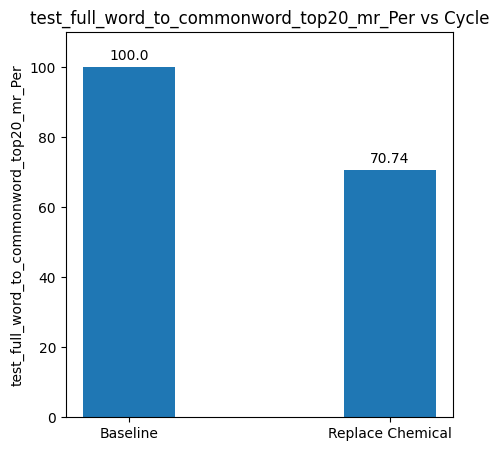

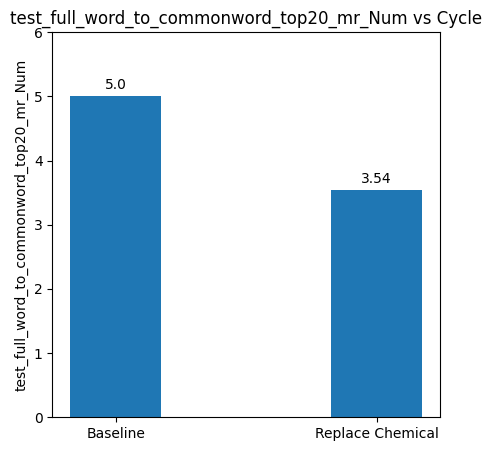

In [107]:
input_f1 = 'test_full'
input_f2 = 'test_full_word_to_commonword_top20_mr'
output_file = 'test_full_word_to_commonword_top20_mr'
x_axis_label = 'Baseline'
y_axis_label = 'Replace Chemical'
metric = cal_itersection_percent(input_f1, input_f2, output_file)
generate_graph(output_file, metric, x_axis_label, y_axis_label)
print(metric)

In [283]:
def group_label_intersection(src_file_path, des_file_path, mr_scenario):
    src_df = pd.read_csv(src_file_path)
    des_df = pd.read_csv(des_file_path)
    gender_list = list(src_df['gender'])
    # metric_df = pd.DataFrame()
    des_df.insert(len(des_df.columns), 'gender', gender_list)
    input_df = des_df
    metrics_agg = input_df.groupby(["Cycle","gender"], as_index=False).agg(No_of_intersecting_labels=('# of intersecting_labels', 'mean'), intersecting_percentage = ('intersecting_percentage', 'mean'))
    metrics_agg.insert(len(metrics_agg.columns),'mr_scenario',np.repeat(mr_scenario, len(src_df['gender'].unique())))
    return metrics_agg

In [289]:
con_metric_df = pd.DataFrame(columns=['cycle','gender','No_of_intersecting_labels','intersecting_percentage','mr_scenario'])

In [290]:
des_files_list = ['test_full_word_to_commonword_top5_mr_K5', 'test_full_word_to_commonword_top8_mr_K5', 'test_full_word_to_commonword_top10_mr_K5',
               'test_full_word_to_commonword_top15_mr_K5', 'test_full_word_to_commonword_top20_mr_K5']
src_file_path = '../data/mimic3/test_full_gender_group.csv'
for des_file_name in des_files_list:
  des_file_path = f'../Report/{des_file_name}.csv'
  mr_scenario = [des_file_name]
  metric_df = group_label_intersection(src_file_path, des_file_path, mr_scenario)
  for i in range(len(metric_df)):
    con_metric_df.loc[len(con_metric_df)] = list(metric_df.loc[i])

In [292]:
con_metric_df.to_clipboard()

In [ ]:
mr_scenario_list = ['test_full_acronym_to_word_top5_mr_K5', 'test_full_acronym_to_word_top8_mr_K5', 'test_full_acronym_to_word_top10_mr_K5',
               'test_full_acronym_to_word_top15_mr_K5', 'test_full_acronym_to_word_top20_mr_K5'] #acronym_to_word
mr_scenario_list = ['test_full_word_to_acronym_top5_mr_K5', 'test_full_word_to_acronym_top8_mr_K5', 'test_full_word_to_acronym_top10_mr_K5',
               'test_full_word_to_acronym_top15_mr_K5', 'test_full_word_to_acronym_top20_mr_K5'] #word_to_acronym
mr_scenario_list = ['test_full_word_to_commonword_top5_mr_K5', 'test_full_word_to_commonword_top8_mr_K5', 'test_full_word_to_commonword_top10_mr_K5',
               'test_full_word_to_commonword_top15_mr_K5', 'test_full_word_to_commonword_top20_mr_K5'] #chemical_to_common word
mr_scenario_list = ['test_full_add_mr_1_3_new_K5',
'test_full_add_mr_2_3_new_K5',
'test_full_add_mr_3_3_new_K5',
'test_full_add_mr_1_4_new_K5',
'test_full_add_mr_2_4_new_K5',
'test_full_add_mr_3_4_new_K5',
'test_full_add_mr_1_4_existing_K5',
'test_full_add_mr_2_4_existing_K5',
'test_full_add_mr_3_4_existing_K5',
'test_full_add_mr_1_3_existing_K5',
'test_full_add_mr_2_3_existing_K5',
'test_full_add_mr_3_3_existing_K5',
'test_full_add_mr_5_3_existing_K5',
'test_full_add_mr_10_3_existing_K5',
'test_full_add_mr_5_4_existing_K5',
'test_full_add_mr_10_4_existing_K5',
'test_full_add_mr_5_3_new_K5',
'test_full_add_mr_10_3_new_K5',
'test_full_add_mr_5_4_new_K5',
'test_full_add_mr_10_4_new_K5'] #add_word

mr_scenario_list = ['test_full_swap_mr_1_60_K5',
'test_full_swap_mr_1_70_K5',
'test_full_swap_mr_2_60_K5',
'test_full_swap_mr_2_70_K5',
'test_full_swap_mr_3_60_K5',
'test_full_swap_mr_3_70_K5',
'test_full_swap_mr_5_60_K5',
'test_full_swap_mr_5_70_K5',
'test_full_swap_mr_10_60_K5',
'test_full_swap_mr_10_70_K5'] #swap_word

mr_scenario_list = ['test_full_gender_blank_mr_K5',
'test_full_gender_change_mr_K5',
'test_full_gender_genderswap_mf_mr_K5',
'test_full_gender_patient_all_mr_K5',
'test_full_gender_patient_mr_K5',
'test_full_gender_blank_all_mr_K5'] #fairness

mr_scenario_list = ['test_full_mistake_mr_1_3_1_add_K5',
'test_full_mistake_mr_1_3_1_change_K5',
'test_full_mistake_mr_1_3_1_remove_K5',
'test_full_mistake_mr_1_3_2_add_K5',
'test_full_mistake_mr_1_3_2_change_K5',
'test_full_mistake_mr_1_3_2_remove_K5',
'test_full_mistake_mr_2_3_1_add_K5',
'test_full_mistake_mr_2_3_1_change_K5',
'test_full_mistake_mr_2_3_1_remove_K5',
'test_full_mistake_mr_2_3_2_add_K5',
'test_full_mistake_mr_2_3_2_change_K5',
'test_full_mistake_mr_2_3_2_remove_K5',
'test_full_mistake_mr_3_3_1_add_K5',
'test_full_mistake_mr_3_3_1_change_K5',
'test_full_mistake_mr_3_3_1_remove_K5',
'test_full_mistake_mr_3_3_2_add_K5',
'test_full_mistake_mr_3_3_2_change_K5',
'test_full_mistake_mr_3_3_2_remove_K5',
'test_full_mistake_mr_5_3_1_add_K5',
'test_full_mistake_mr_5_3_1_change_K5',
'test_full_mistake_mr_5_3_1_remove_K5',
'test_full_mistake_mr_5_3_2_add_K5',
'test_full_mistake_mr_5_3_2_change_K5',
'test_full_mistake_mr_5_3_2_remove_K5',
'test_full_mistake_mr_10_3_1_add_K5',
'test_full_mistake_mr_10_3_1_change_K5',
'test_full_mistake_mr_10_3_1_remove_K5',
'test_full_mistake_mr_10_3_2_add_K5',
'test_full_mistake_mr_10_3_2_change_K5',
'test_full_mistake_mr_10_3_2_remove_K5'] #mistake word

mr_scenario_list = ['test_full_remove_mr_1_3_k5',
'test_full_remove_mr_2_3_k5',
'test_full_remove_mr_3_3_k5',
'test_full_remove_mr_5_3_k5',
'test_full_remove_mr_10_3_k5',
'test_full_remove_mr_1_4_k5',
'test_full_remove_mr_2_4_k5',
'test_full_remove_mr_3_4_k5',
'test_full_remove_mr_5_4_k5',
'test_full_remove_mr_10_4_k5']

In [ ]:
gender_group_result =pd.DataFrame()

In [280]:
mr_scenario_list = ['test_full_acronym_to_word_top5_mr_K5', 'test_full_acronym_to_word_top8_mr_K5', 'test_full_acronym_to_word_top10_mr_K5',
               'test_full_acronym_to_word_top15_mr_K5', 'test_full_acronym_to_word_top20_mr_K5']
mr_template = 'replace_acronym'
test_status_report_path = f'../Report/test_status/{mr_template}.csv'
test_status_df = pd.DataFrame(columns=['mr_template','mr_scenario','0','1','2','3','4','5','test_pass','test_fail'])
for mr_scenario in mr_scenario_list:
  report_file_path = f'../Report/{mr_scenario}.csv'
  test_pass = 0
  test_fail = 0
  one, two, three, four, five = 0, 0, 0, 0, 0
  
  src_file_path = '../data/mimic3/test_full_gender_group.csv'
  src_df = pd.read_csv(src_file_path)
  des_df = pd.read_csv(report_file_path)
  gender_list = list(src_df['gender'])
  des_df.insert(len(des_df.columns), 'gender', gender_list)

  # report_df = pd.read_csv(report_file_path)
  report_df = des_df
  label_intersect_series = report_df['# of intersecting_labels']
  intersecting_label_pivot = report_df.pivot_table(values='Input',index='gender',columns=['# of intersecting_labels'], aggfunc="count")
  zero = intersecting_label_pivot.iloc[0][0] or 0
  one = intersecting_label_pivot.iloc[0][1] or 0
  two = intersecting_label_pivot.iloc[0][2] or 0
  three = intersecting_label_pivot.iloc[0][3] or 0
  four = intersecting_label_pivot.iloc[0][4] or 0
  five = intersecting_label_pivot.iloc[0][5] or 0
  intersecting_label_pivot.insert(len(intersecting_label_pivot.columns),'mr_scenario',np.repeat(mr_scenario, len(src_df['gender'].unique())))
  for intersect_label in label_intersect_series:
    if intersect_label == 5:
      test_pass += 1
    else:
      test_fail += 1
  gender_group_result = pd.concat([gender_group_result,intersecting_label_pivot]) 
  test_status_values = [mr_template, mr_scenario, zero, one, two, three, four, five, test_pass, test_fail]
  test_status_df.loc[len(test_status_df)] = test_status_values
# test_status_df.to_csv(test_status_report_path,index=False)

In [282]:
gender_group_result.to_csv('../Report/GenderVsF_MR.csv')

In [75]:
consolidate_label = pd.DataFrame()

In [ ]:
mr_scenario_list = ['test_full_gender_blank_mr_K5',
'test_full_gender_change_mr_K5',
'test_full_gender_genderswap_mf_mr_K5',
'test_full_gender_patient_all_mr_K5',
'test_full_gender_patient_mr_K5',
'test_full_gender_blank_all_mr_K5']
test_status_report_path = f'../Report/test_status/{mr_template}.csv'
pos = 0
for mr_scenario in mr_scenario_list:
  report_file_path = f'../Report/{mr_scenario}.csv'
  report_df = pd.read_csv(report_file_path)
  label_intersect_series = report_df['# of intersecting_labels']
  consolidate_label.insert(pos, mr_scenario, label_intersect_series)
  pos += 1
consolidate_label

In [90]:
mr_scenario_list = ['test_full_gender_blank_mr_K5',
'test_full_gender_change_mr_K5',
'test_full_gender_genderswap_mf_mr_K5',
'test_full_gender_patient_all_mr_K5',
'test_full_gender_patient_mr_K5',
'test_full_gender_blank_all_mr_K5']

#  Gender Terms Removed
#  Gender Terms Replaced
#  Pronouns Swapped
#  Pronouns Removed
#  Pronouns Replaced
#  Gender Swapped
mr_scenario_name_list = ['Pronouns Removed',
'Pronouns Swapped',
'Gender Swapped',
'Gender Terms Replaced',
'Pronouns Replaced',
'Gender Terms Removed']
test_status_report_path = f'../Report/test_status/{mr_template}.csv'
pos = 0
consolidate_label_dict = {}
for i in range(len(mr_scenario_list)):
  report_file_path = f'../Report/{mr_scenario_list[i]}.csv'
  report_df = pd.read_csv(report_file_path)
  label_intersect_series = report_df['# of intersecting_labels']
  # consolidate_label.insert(pos, mr_scenario, label_intersect_series)
  # pos += 1
  consolidate_label_dict[mr_scenario_name_list[i]] = list(label_intersect_series)
# consolidate_label_dict

In [83]:
consolidate_label.to_csv('../Report/consolidated_label_intersection.csv')

## MISC

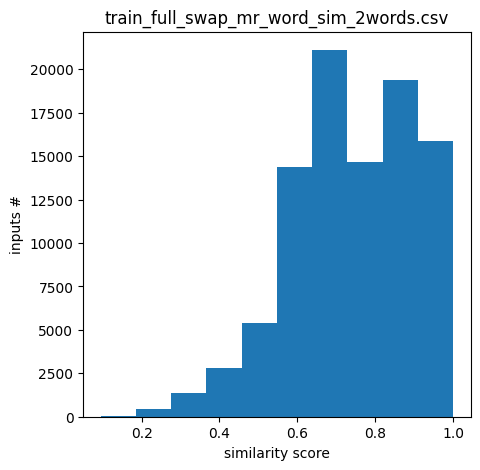

In [134]:
graph_file_name = 'train_full_swap_mr_word_sim_2words.csv'
sim_distribution_df = pd.read_csv(filepath_or_buffer='../sim_analysis/train_full_swap_mr_word_sim_2word.csv')
sim_distribution_array = np.array(sim_distribution_df['similarity_Score'])
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title(graph_file_name)
ax.set_ylabel('inputs #')
ax.set_xlabel('similarity score')
plt.hist(sim_distribution_array)
plt.grid(False)
plt.savefig("../output/Graphs/"+graph_file_name+".png")
plt.show()

In [56]:
def distribution_plot(input_filepath, output_graph_filename):
  distribution_df = pd.read_csv(filepath_or_buffer=input_filepath)
  distribution_array = np.array(distribution_df['# of intersecting_labels'])
  fig, ax = plt.subplots(figsize = (5, 5))
  ax.set_title(output_graph_filename)
  ax.set_ylabel('inputs #')
  ax.set_xlabel('# of intersecting_labels')
  # ax.grid(True)
  plt.hist(distribution_array)
  plt.grid(True, which='major', axis='y')
  plt.savefig("../output/Graphs/"+output_graph_filename+".png")
  plt.show()
  

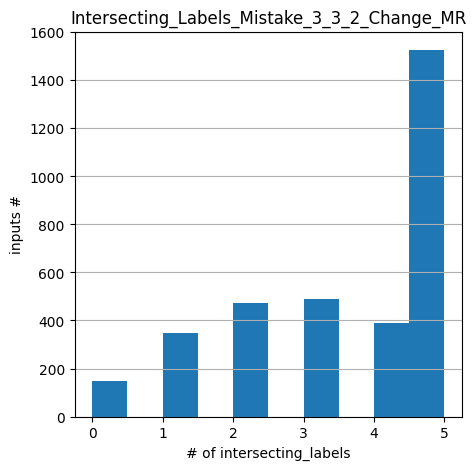

In [64]:
distribution_plot('../Report/test_full_mistake_mr_3_3_2_change_K5_all.csv', 'Intersecting_Labels_Mistake_3_3_2_Change_MR')

In [36]:
import csv

def compare_sentences(sentence1, sentence2):
    words1 = sentence1.split()
    words2 = sentence2.split()
    
    # Find words in sentence1 that are not in sentence2
    diff_in_sentence1 = [word for word in words1 if word not in words2]
    
    # Find words in sentence2 that are not in sentence1
    diff_in_sentence2 = [word for word in words2 if word not in words1]
    print([diff_in_sentence1, diff_in_sentence2])
    return [diff_in_sentence1, diff_in_sentence2]

def write_diff_to_csv(sentence1, sentence2, csv_filename):
    diff1 = compare_sentences(sentence1, sentence2)
    
    # Prepare data for CSV writing
    # headers = ['Sentence 1 Differences', 'Sentence 2 Differences']
    # data = list(zip(diff1, diff2))  # Combine the differences into pairs
    
    # Write to CSV
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        # writer.writerow(headers)
        writer.writerows(diff1)

In [ ]:
csv_filename = "../output/csv/sentence_diff.csv"
input_filepath = '../output/csv/sample_output_for_sme.csv'
df = pd.read_csv(input_filepath)
actual_text_series = df['actual_Text']	
modified_text_series = df['modified_text']
for i in range(len(actual_text_series)):
  actual_text = actual_text_series[i]
  modified_text = modified_text_series[i]
  # print(actual_text)
  # print(modified_text)
  write_diff_to_csv(actual_text, modified_text, csv_filename)

In [73]:
def word_frequency(input_file_path):
  from collections import Counter
  input_df = pd.read_csv(input_file_path)
  text_list = list(input_df['text'])
  print(text_list)
  word_freq = Counter(text_list)
  # return(word_freq)

In [ ]:
word_frequency('../data/mimic3/test_full.csv')

In [148]:
label_to_id_dict = {'003.0': 0, '003.1': 1, '003.8': 2, '003.9': 3, '004.1': 4, '004.8': 5, '004.9': 6, '005.1': 7, '005.81': 8, '005.9': 9, '007.1': 10, '007.4': 11, '008.04': 12, '008.41': 13, '008.43': 14, '008.45': 15, '008.47': 16, '008.5': 17, '008.61': 18, '008.62': 19, '008.63': 20, '008.69': 21, '008.8': 22, '009.0': 23, '009.1': 24, '009.2': 25, '009.3': 26, '010.85': 27, '011.23': 28, '011.36': 29, '011.64': 30, '011.86': 31, '011.90': 32, '011.93': 33, '011.94': 34, '012.05': 35, '012.15': 36, '013.00': 37, '013.04': 38, '013.25': 39, '013.30': 40, '013.54': 41, '014.02': 42, '014.05': 43, '014.85': 44, '015.04': 45, '015.05': 46, '018.03': 47, '018.05': 48, '018.80': 49, '018.90': 50, '018.94': 51, '018.95': 52, '018.96': 53, '021.8': 54, '023.9': 55, '027.0': 56, '027.2': 57, '027.9': 58, '030.9': 59, '031.0': 60, '031.1': 61, '031.2': 62, '031.8': 63, '031.9': 64, '032.85': 65, '032.89': 66, '032.9': 67, '033.8': 68, '034.0': 69, '035': 70, '036.0': 71, '036.2': 72, '036.41': 73, '038.0': 74, '038.10': 75, '038.11': 76, '038.12': 77, '038.19': 78, '038.2': 79, '038.3': 80, '038.40': 81, '038.41': 82, '038.42': 83, '038.43': 84, '038.44': 85, '038.49': 86, '038.8': 87, '038.9': 88, '039.1': 89, '039.2': 90, '039.8': 91, '040.0': 92, '040.82': 93, '040.89': 94, '041.00': 95, '041.01': 96, '041.02': 97, '041.03': 98, '041.04': 99, '041.05': 100, '041.09': 101, '041.10': 102, '041.11': 103, '041.12': 104, '041.19': 105, '041.2': 106, '041.3': 107, '041.4': 108, '041.49': 109, '041.5': 110, '041.6': 111, '041.7': 112, '041.82': 113, '041.83': 114, '041.84': 115, '041.85': 116, '041.86': 117, '041.89': 118, '041.9': 119, '042': 120, '045.90': 121, '046.3': 122, '046.71': 123, '047.0': 124, '047.8': 125, '047.9': 126, '048': 127, '049.0': 128, '049.1': 129, '049.8': 130, '049.9': 131, '052.0': 132, '052.1': 133, '052.7': 134, '052.9': 135, '053.0': 136, '053.11': 137, '053.12': 138, '053.13': 139, '053.14': 140, '053.19': 141, '053.20': 142, '053.29': 143, '053.71': 144, '053.79': 145, '053.9': 146, '054.0': 147, '054.10': 148, '054.12': 149, '054.13': 150, '054.19': 151, '054.2': 152, '054.3': 153, '054.40': 154, '054.43': 155, '054.5': 156, '054.71': 157, '054.72': 158, '054.79': 159, '054.9': 160, '057.8': 161, '057.9': 162, '058.21': 163, '058.29': 164, '058.81': 165, '058.89': 166, '062.2': 167, '066.41': 168, '066.42': 169, '070.0': 170, '070.1': 171, '070.20': 172, '070.22': 173, '070.30': 174, '070.31': 175, '070.32': 176, '070.33': 177, '070.41': 178, '070.44': 179, '070.49': 180, '070.51': 181, '070.52': 182, '070.53': 183, '070.54': 184, '070.59': 185, '070.70': 186, '070.71': 187, '070.9': 188, '075': 189, '077.8': 190, '077.99': 191, '078.0': 192, '078.10': 193, '078.11': 194, '078.19': 195, '078.5': 196, '078.89': 197, '079.0': 198, '079.3': 199, '079.4': 200, '079.51': 201, '079.53': 202, '079.6': 203, '079.83': 204, '079.89': 205, '079.98': 206, '079.99': 207, '082.40': 208, '082.49': 209, '083.9': 210, '084.0': 211, '084.4': 212, '084.6': 213, '084.9': 214, '085.9': 215, '086.0': 216, '088.0': 217, '088.81': 218, '088.82': 219, '090.2': 220, '091.2': 221, '091.52': 222, '091.81': 223, '091.9': 224, '093.1': 225, '094.0': 226, '094.9': 227, '096': 228, '097.0': 229, '097.1': 230, '097.9': 231, '098.0': 232, '099.3': 233, '10.0': 234, '10.1': 235, '10.2': 236, '10.6': 237, '10.9': 238, '11.': 239, '11.0': 240, '11.3': 241, '11.4': 242, '11.49': 243, '11.51': 244, '11.8': 245, '110.0': 246, '110.1': 247, '110.3': 248, '110.4': 249, '110.5': 250, '110.6': 251, '110.8': 252, '110.9': 253, '111.0': 254, '111.8': 255, '111.9': 256, '112.0': 257, '112.1': 258, '112.2': 259, '112.3': 260, '112.4': 261, '112.5': 262, '112.81': 263, '112.83': 264, '112.84': 265, '112.85': 266, '112.89': 267, '112.9': 268, '114.0': 269, '114.9': 270, '115.05': 271, '115.19': 272, '115.90': 273, '115.99': 274, '116.0': 275, '117.3': 276, '117.4': 277, '117.5': 278, '117.7': 279, '117.9': 280, '118': 281, '12.': 282, '12.0': 283, '12.1': 284, '12.2': 285, '12.3': 286, '12.4': 287, '12.5': 288, '12.6': 289, '12.64': 290, '12.7': 291, '12.73': 292, '12.8': 293, '12.81': 294, '12.91': 295, '12.92': 296, '120.8': 297, '120.9': 298, '121.1': 299, '122.8': 300, '123.1': 301, '125.1': 302, '127.0': 303, '127.2': 304, '127.3': 305, '13.': 306, '13.0': 307, '13.1': 308, '13.2': 309, '13.41': 310, '13.71': 311, '13.9': 312, '130.0': 313, '130.7': 314, '130.8': 315, '130.9': 316, '131.01': 317, '131.02': 318, '131.09': 319, '132.0': 320, '132.9': 321, '133.0': 322, '134.8': 323, '135': 324, '136.1': 325, '136.3': 326, '136.9': 327, '137.0': 328, '137.3': 329, '138': 330, '139.0': 331, '139.8': 332, '14.': 333, '14.0': 334, '14.22': 335, '14.24': 336, '14.34': 337, '14.41': 338, '14.54': 339, '14.59': 340, '14.73': 341, '14.74': 342, '14.75': 343, '14.79': 344, '14.9': 345, '140.0': 346, '140.1': 347, '140.9': 348, '141.0': 349, '141.4': 350, '141.8': 351, '141.9': 352, '142.0': 353, '142.9': 354, '143.0': 355, '143.1': 356, '144.0': 357, '144.8': 358, '144.9': 359, '145.0': 360, '145.2': 361, '145.3': 362, '145.5': 363, '145.8': 364, '146.0': 365, '146.1': 366, '146.3': 367, '146.4': 368, '146.7': 369, '146.8': 370, '146.9': 371, '147.1': 372, '147.8': 373, '147.9': 374, '148.1': 375, '148.8': 376, '148.9': 377, '149.0': 378, '149.8': 379, '15.': 380, '15.0': 381, '15.1': 382, '15.2': 383, '15.3': 384, '15.7': 385, '15.9': 386, '150.0': 387, '150.1': 388, '150.3': 389, '150.4': 390, '150.5': 391, '150.8': 392, '150.9': 393, '151.0': 394, '151.1': 395, '151.2': 396, '151.3': 397, '151.4': 398, '151.5': 399, '151.6': 400, '151.8': 401, '151.9': 402, '152.0': 403, '152.1': 404, '152.2': 405, '152.8': 406, '152.9': 407, '153.0': 408, '153.1': 409, '153.2': 410, '153.3': 411, '153.4': 412, '153.5': 413, '153.6': 414, '153.7': 415, '153.8': 416, '153.9': 417, '154.0': 418, '154.1': 419, '154.2': 420, '154.3': 421, '154.8': 422, '155.0': 423, '155.1': 424, '155.2': 425, '156.0': 426, '156.1': 427, '156.2': 428, '156.8': 429, '156.9': 430, '157.0': 431, '157.1': 432, '157.2': 433, '157.3': 434, '157.4': 435, '157.8': 436, '157.9': 437, '158.0': 438, '158.8': 439, '158.9': 440, '159.8': 441, '159.9': 442, '16.': 443, '16.0': 444, '16.09': 445, '16.31': 446, '16.49': 447, '16.51': 448, '16.52': 449, '16.59': 450, '16.63': 451, '16.81': 452, '16.82': 453, '160.2': 454, '160.3': 455, '160.8': 456, '160.9': 457, '161.0': 458, '161.1': 459, '161.2': 460, '161.3': 461, '161.8': 462, '161.9': 463, '162.0': 464, '162.2': 465, '162.3': 466, '162.4': 467, '162.5': 468, '162.8': 469, '162.9': 470, '163.0': 471, '163.8': 472, '163.9': 473, '164.0': 474, '164.1': 475, '164.2': 476, '164.3': 477, '164.8': 478, '164.9': 479, '17.': 480, '17.0': 481, '17.33': 482, '17.35': 483, '17.36': 484, '17.41': 485, '17.42': 486, '17.55': 487, '17.56': 488, '17.7': 489, '17.71': 490, '170.0': 491, '170.2': 492, '170.3': 493, '170.7': 494, '171.0': 495, '171.2': 496, '171.3': 497, '171.4': 498, '171.5': 499, '171.6': 500, '171.7': 501, '171.8': 502, '172.0': 503, '172.3': 504, '172.4': 505, '172.5': 506, '172.6': 507, '172.7': 508, '172.8': 509, '172.9': 510, '173.0': 511, '173.1': 512, '173.2': 513, '173.22': 514, '173.3': 515, '173.31': 516, '173.32': 517, '173.4': 518, '173.41': 519, '173.42': 520, '173.5': 521, '173.6': 522, '173.7': 523, '173.72': 524, '173.8': 525, '173.9': 526, '174.3': 527, '174.4': 528, '174.5': 529, '174.8': 530, '174.9': 531, '175.9': 532, '176.0': 533, '176.1': 534, '176.3': 535, '176.4': 536, '176.5': 537, '176.8': 538, '176.9': 539, '179': 540, '18.0': 541, '18.09': 542, '18.11': 543, '18.12': 544, '18.21': 545, '18.29': 546, '18.39': 547, '18.4': 548, '18.79': 549, '180.0': 550, '180.8': 551, '180.9': 552, '182.0': 553, '183.0': 554, '183.2': 555, '183.8': 556, '184.0': 557, '184.4': 558, '184.8': 559, '185': 560, '186.9': 561, '187.4': 562, '188.0': 563, '188.1': 564, '188.2': 565, '188.3': 566, '188.4': 567, '188.5': 568, '188.8': 569, '188.9': 570, '189.0': 571, '189.1': 572, '189.2': 573, '189.3': 574, '189.8': 575, '19.9': 576, '190.5': 577, '190.6': 578, '191.0': 579, '191.1': 580, '191.2': 581, '191.3': 582, '191.4': 583, '191.5': 584, '191.6': 585, '191.7': 586, '191.8': 587, '191.9': 588, '192.0': 589, '192.1': 590, '192.2': 591, '193': 592, '194.0': 593, '194.1': 594, '194.3': 595, '194.5': 596, '195.0': 597, '195.1': 598, '195.2': 599, '195.3': 600, '195.8': 601, '196.0': 602, '196.1': 603, '196.2': 604, '196.3': 605, '196.5': 606, '196.6': 607, '196.8': 608, '196.9': 609, '197.0': 610, '197.1': 611, '197.2': 612, '197.3': 613, '197.4': 614, '197.5': 615, '197.6': 616, '197.7': 617, '197.8': 618, '198.0': 619, '198.1': 620, '198.2': 621, '198.3': 622, '198.4': 623, '198.5': 624, '198.6': 625, '198.7': 626, '198.81': 627, '198.82': 628, '198.89': 629, '199.0': 630, '199.1': 631, '20.01': 632, '20.09': 633, '20.2': 634, '20.3': 635, '20.4': 636, '20.41': 637, '20.49': 638, '20.5': 639, '20.59': 640, '20.6': 641, '20.61': 642, '20.7': 643, '200.00': 644, '200.01': 645, '200.02': 646, '200.03': 647, '200.05': 648, '200.08': 649, '200.10': 650, '200.11': 651, '200.18': 652, '200.20': 653, '200.21': 654, '200.22': 655, '200.23': 656, '200.24': 657, '200.28': 658, '200.30': 659, '200.33': 660, '200.37': 661, '200.40': 662, '200.42': 663, '200.47': 664, '200.48': 665, '200.50': 666, '200.60': 667, '200.70': 668, '200.71': 669, '200.78': 670, '200.80': 671, '201.48': 672, '201.50': 673, '201.52': 674, '201.58': 675, '201.90': 676, '201.91': 677, '201.92': 678, '201.98': 679, '202.00': 680, '202.01': 681, '202.03': 682, '202.05': 683, '202.06': 684, '202.08': 685, '202.10': 686, '202.11': 687, '202.12': 688, '202.13': 689, '202.18': 690, '202.20': 691, '202.40': 692, '202.43': 693, '202.52': 694, '202.60': 695, '202.70': 696, '202.78': 697, '202.80': 698, '202.81': 699, '202.82': 700, '202.83': 701, '202.85': 702, '202.87': 703, '202.88': 704, '202.90': 705, '203.00': 706, '203.01': 707, '203.02': 708, '203.10': 709, '203.12': 710, '203.80': 711, '203.82': 712, '204.00': 713, '204.01': 714, '204.02': 715, '204.10': 716, '204.11': 717, '204.12': 718, '204.80': 719, '204.90': 720, '205.00': 721, '205.01': 722, '205.02': 723, '205.10': 724, '205.11': 725, '205.12': 726, '205.30': 727, '205.90': 728, '206.00': 729, '207.22': 730, '207.80': 731, '208.00': 732, '208.90': 733, '208.91': 734, '209.03': 735, '209.17': 736, '209.20': 737, '209.21': 738, '209.25': 739, '209.29': 740, '209.30': 741, '209.36': 742, '209.43': 743, '209.51': 744, '209.57': 745, '209.61': 746, '209.63': 747, '209.69': 748, '209.71': 749, '209.72': 750, '209.73': 751, '209.74': 752, '209.75': 753, '209.79': 754, '21.0': 755, '21.00': 756, '21.01': 757, '21.02': 758, '21.03': 759, '21.09': 760, '21.1': 761, '21.2': 762, '21.21': 763, '21.22': 764, '21.3': 765, '21.32': 766, '21.4': 767, '21.5': 768, '21.61': 769, '21.62': 770, '21.69': 771, '21.71': 772, '21.72': 773, '21.81': 774, '21.83': 775, '21.86': 776, '21.88': 777, '21.89': 778, '210.1': 779, '210.2': 780, '210.4': 781, '211.0': 782, '211.1': 783, '211.2': 784, '211.3': 785, '211.4': 786, '211.5': 787, '211.6': 788, '211.7': 789, '211.8': 790, '211.9': 791, '212.0': 792, '212.1': 793, '212.2': 794, '212.3': 795, '212.5': 796, '212.6': 797, '212.7': 798, '213.0': 799, '213.2': 800, '213.7': 801, '214.0': 802, '214.1': 803, '214.2': 804, '214.3': 805, '214.4': 806, '214.8': 807, '214.9': 808, '215.0': 809, '215.3': 810, '215.4': 811, '215.5': 812, '215.6': 813, '216.3': 814, '216.4': 815, '216.5': 816, '216.6': 817, '216.7': 818, '216.9': 819, '217': 820, '218.0': 821, '218.1': 822, '218.2': 823, '218.9': 824, '219.1': 825, '22.': 826, '22.0': 827, '22.01': 828, '22.1': 829, '22.11': 830, '22.19': 831, '22.2': 832, '22.41': 833, '22.42': 834, '22.5': 835, '22.52': 836, '22.6': 837, '22.62': 838, '22.63': 839, '22.64': 840, '22.79': 841, '22.9': 842, '220': 843, '221.0': 844, '221.8': 845, '223.0': 846, '225.0': 847, '225.1': 848, '225.2': 849, '225.3': 850, '225.4': 851, '226': 852, '227.0': 853, '227.1': 854, '227.3': 855, '228.01': 856, '228.02': 857, '228.04': 858, '228.09': 859, '228.1': 860, '229.8': 861, '23.0': 862, '23.01': 863, '23.09': 864, '23.1': 865, '23.11': 866, '23.19': 867, '23.3': 868, '23.4': 869, '23.73': 870, '23.9': 871, '230.0': 872, '230.1': 873, '230.2': 874, '230.6': 875, '230.8': 876, '230.9': 877, '231.2': 878, '232.5': 879, '232.9': 880, '233.0': 881, '233.1': 882, '233.3': 883, '233.31': 884, '233.4': 885, '233.7': 886, '233.9': 887, '235.2': 888, '235.3': 889, '235.4': 890, '235.5': 891, '235.6': 892, '235.7': 893, '235.8': 894, '236.0': 895, '236.2': 896, '236.7': 897, '236.91': 898, '237.0': 899, '237.1': 900, '237.3': 901, '237.5': 902, '237.6': 903, '237.70': 904, '237.71': 905, '237.72': 906, '237.73': 907, '237.9': 908, '238.0': 909, '238.1': 910, '238.2': 911, '238.4': 912, '238.6': 913, '238.7': 914, '238.71': 915, '238.72': 916, '238.73': 917, '238.74': 918, '238.75': 919, '238.76': 920, '238.77': 921, '238.79': 922, '238.8': 923, '239.0': 924, '239.1': 925, '239.2': 926, '239.4': 927, '239.5': 928, '239.6': 929, '239.7': 930, '239.89': 931, '24.0': 932, '24.11': 933, '24.2': 934, '24.3': 935, '24.32': 936, '24.4': 937, '24.5': 938, '24.7': 939, '240.9': 940, '241.0': 941, '241.1': 942, '241.9': 943, '242.00': 944, '242.01': 945, '242.10': 946, '242.20': 947, '242.21': 948, '242.30': 949, '242.80': 950, '242.81': 951, '242.90': 952, '242.91': 953, '243': 954, '244.0': 955, '244.1': 956, '244.2': 957, '244.3': 958, '244.8': 959, '244.9': 960, '245.2': 961, '245.4': 962, '245.8': 963, '245.9': 964, '246.2': 965, '246.8': 966, '246.9': 967, '249.00': 968, '249.01': 969, '249.11': 970, '249.50': 971, '249.60': 972, '249.80': 973, '249.81': 974, '249.90': 975, '249.91': 976, '25.01': 977, '25.02': 978, '25.1': 979, '25.2': 980, '25.3': 981, '25.51': 982, '25.59': 983, '25.92': 984, '250.00': 985, '250.01': 986, '250.02': 987, '250.03': 988, '250.10': 989, '250.11': 990, '250.12': 991, '250.13': 992, '250.20': 993, '250.21': 994, '250.22': 995, '250.23': 996, '250.30': 997, '250.31': 998, '250.32': 999, '250.33': 1000, '250.40': 1001, '250.41': 1002, '250.42': 1003, '250.43': 1004, '250.50': 1005, '250.51': 1006, '250.52': 1007, '250.53': 1008, '250.60': 1009, '250.61': 1010, '250.62': 1011, '250.63': 1012, '250.70': 1013, '250.71': 1014, '250.72': 1015, '250.73': 1016, '250.80': 1017, '250.81': 1018, '250.82': 1019, '250.83': 1020, '250.90': 1021, '250.91': 1022, '250.92': 1023, '250.93': 1024, '251.0': 1025, '251.1': 1026, '251.2': 1027, '251.3': 1028, '251.5': 1029, '251.8': 1030, '251.9': 1031, '252.0': 1032, '252.00': 1033, '252.01': 1034, '252.02': 1035, '252.08': 1036, '252.1': 1037, '252.8': 1038, '253.0': 1039, '253.1': 1040, '253.2': 1041, '253.3': 1042, '253.4': 1043, '253.5': 1044, '253.6': 1045, '253.7': 1046, '253.8': 1047, '253.9': 1048, '254.0': 1049, '254.1': 1050, '254.8': 1051, '255.0': 1052, '255.10': 1053, '255.12': 1054, '255.2': 1055, '255.3': 1056, '255.4': 1057, '255.41': 1058, '255.42': 1059, '255.5': 1060, '255.8': 1061, '255.9': 1062, '256.1': 1063, '256.39': 1064, '256.4': 1065, '257.1': 1066, '257.2': 1067, '258.01': 1068, '258.1': 1069, '258.8': 1070, '258.9': 1071, '259.2': 1072, '259.4': 1073, '259.8': 1074, '259.9': 1075, '26.0': 1076, '26.11': 1077, '26.21': 1078, '26.3': 1079, '26.30': 1080, '26.31': 1081, '26.32': 1082, '26.91': 1083, '26.99': 1084, '260': 1085, '261': 1086, '262': 1087, '263.0': 1088, '263.1': 1089, '263.8': 1090, '263.9': 1091, '265.0': 1092, '265.1': 1093, '265.2': 1094, '266.2': 1095, '266.9': 1096, '267': 1097, '268.2': 1098, '268.9': 1099, '269.0': 1100, '269.2': 1101, '269.3': 1102, '269.8': 1103, '269.9': 1104, '27.0': 1105, '27.22': 1106, '27.23': 1107, '27.24': 1108, '27.31': 1109, '27.42': 1110, '27.49': 1111, '27.51': 1112, '27.52': 1113, '27.53': 1114, '27.55': 1115, '27.56': 1116, '27.57': 1117, '27.59': 1118, '27.61': 1119, '27.69': 1120, '27.72': 1121, '27.92': 1122, '270.0': 1123, '270.2': 1124, '270.4': 1125, '270.6': 1126, '270.7': 1127, '271.0': 1128, '271.3': 1129, '271.8': 1130, '272.0': 1131, '272.1': 1132, '272.2': 1133, '272.4': 1134, '272.5': 1135, '272.6': 1136, '272.7': 1137, '272.8': 1138, '272.9': 1139, '273.0': 1140, '273.1': 1141, '273.2': 1142, '273.3': 1143, '273.4': 1144, '273.8': 1145, '273.9': 1146, '274.0': 1147, '274.00': 1148, '274.01': 1149, '274.02': 1150, '274.03': 1151, '274.11': 1152, '274.82': 1153, '274.89': 1154, '274.9': 1155, '275.0': 1156, '275.01': 1157, '275.02': 1158, '275.03': 1159, '275.09': 1160, '275.1': 1161, '275.2': 1162, '275.3': 1163, '275.40': 1164, '275.41': 1165, '275.42': 1166, '275.49': 1167, '275.5': 1168, '275.8': 1169, '275.9': 1170, '276.0': 1171, '276.1': 1172, '276.2': 1173, '276.3': 1174, '276.4': 1175, '276.5': 1176, '276.50': 1177, '276.51': 1178, '276.52': 1179, '276.6': 1180, '276.61': 1181, '276.69': 1182, '276.7': 1183, '276.8': 1184, '276.9': 1185, '277.00': 1186, '277.02': 1187, '277.09': 1188, '277.1': 1189, '277.3': 1190, '277.30': 1191, '277.31': 1192, '277.39': 1193, '277.4': 1194, '277.6': 1195, '277.7': 1196, '277.8': 1197, '277.87': 1198, '277.88': 1199, '277.89': 1200, '277.9': 1201, '278.00': 1202, '278.01': 1203, '278.02': 1204, '278.03': 1205, '278.1': 1206, '278.8': 1207, '279.00': 1208, '279.01': 1209, '279.03': 1210, '279.06': 1211, '279.11': 1212, '279.3': 1213, '279.4': 1214, '279.41': 1215, '279.49': 1216, '279.50': 1217, '279.51': 1218, '279.52': 1219, '279.53': 1220, '279.8': 1221, '279.9': 1222, '28.0': 1223, '28.11': 1224, '28.2': 1225, '28.7': 1226, '280.0': 1227, '280.8': 1228, '280.9': 1229, '281.0': 1230, '281.1': 1231, '281.2': 1232, '281.3': 1233, '281.8': 1234, '281.9': 1235, '282.0': 1236, '282.1': 1237, '282.2': 1238, '282.3': 1239, '282.4': 1240, '282.40': 1241, '282.41': 1242, '282.43': 1243, '282.44': 1244, '282.46': 1245, '282.49': 1246, '282.5': 1247, '282.60': 1248, '282.62': 1249, '282.64': 1250, '282.7': 1251, '282.8': 1252, '282.9': 1253, '283.0': 1254, '283.10': 1255, '283.11': 1256, '283.19': 1257, '283.2': 1258, '283.9': 1259, '284.0': 1260, '284.1': 1261, '284.11': 1262, '284.12': 1263, '284.19': 1264, '284.2': 1265, '284.8': 1266, '284.89': 1267, '284.9': 1268, '285.1': 1269, '285.21': 1270, '285.22': 1271, '285.29': 1272, '285.3': 1273, '285.8': 1274, '285.9': 1275, '286.0': 1276, '286.1': 1277, '286.2': 1278, '286.3': 1279, '286.4': 1280, '286.5': 1281, '286.52': 1282, '286.6': 1283, '286.7': 1284, '286.9': 1285, '287.0': 1286, '287.1': 1287, '287.2': 1288, '287.3': 1289, '287.30': 1290, '287.31': 1291, '287.32': 1292, '287.33': 1293, '287.4': 1294, '287.49': 1295, '287.5': 1296, '287.9': 1297, '288.0': 1298, '288.00': 1299, '288.01': 1300, '288.02': 1301, '288.03': 1302, '288.04': 1303, '288.09': 1304, '288.1': 1305, '288.2': 1306, '288.3': 1307, '288.4': 1308, '288.50': 1309, '288.51': 1310, '288.59': 1311, '288.60': 1312, '288.61': 1313, '288.62': 1314, '288.63': 1315, '288.66': 1316, '288.8': 1317, '288.9': 1318, '289.0': 1319, '289.1': 1320, '289.3': 1321, '289.4': 1322, '289.50': 1323, '289.51': 1324, '289.52': 1325, '289.59': 1326, '289.7': 1327, '289.8': 1328, '289.81': 1329, '289.82': 1330, '289.83': 1331, '289.84': 1332, '289.89': 1333, '289.9': 1334, '29.0': 1335, '29.1': 1336, '29.11': 1337, '29.12': 1338, '29.2': 1339, '29.3': 1340, '29.31': 1341, '29.32': 1342, '29.33': 1343, '29.39': 1344, '29.4': 1345, '29.5': 1346, '29.51': 1347, '29.59': 1348, '29.6': 1349, '29.9': 1350, '290.0': 1351, '290.10': 1352, '290.12': 1353, '290.3': 1354, '290.40': 1355, '290.41': 1356, '290.42': 1357, '290.43': 1358, '291.0': 1359, '291.1': 1360, '291.2': 1361, '291.3': 1362, '291.81': 1363, '291.89': 1364, '292.0': 1365, '292.11': 1366, '292.12': 1367, '292.81': 1368, '292.82': 1369, '292.84': 1370, '292.85': 1371, '292.89': 1372, '292.9': 1373, '293.0': 1374, '293.1': 1375, '293.81': 1376, '293.82': 1377, '293.83': 1378, '293.84': 1379, '293.89': 1380, '293.9': 1381, '294.0': 1382, '294.10': 1383, '294.11': 1384, '294.20': 1385, '294.21': 1386, '294.8': 1387, '294.9': 1388, '295.02': 1389, '295.12': 1390, '295.20': 1391, '295.22': 1392, '295.24': 1393, '295.30': 1394, '295.32': 1395, '295.40': 1396, '295.44': 1397, '295.60': 1398, '295.62': 1399, '295.64': 1400, '295.70': 1401, '295.72': 1402, '295.73': 1403, '295.74': 1404, '295.75': 1405, '295.80': 1406, '295.90': 1407, '295.92': 1408, '296.00': 1409, '296.04': 1410, '296.14': 1411, '296.20': 1412, '296.21': 1413, '296.22': 1414, '296.23': 1415, '296.24': 1416, '296.25': 1417, '296.30': 1418, '296.31': 1419, '296.32': 1420, '296.33': 1421, '296.34': 1422, '296.40': 1423, '296.44': 1424, '296.50': 1425, '296.51': 1426, '296.53': 1427, '296.54': 1428, '296.7': 1429, '296.80': 1430, '296.81': 1431, '296.89': 1432, '296.90': 1433, '296.99': 1434, '297.1': 1435, '297.2': 1436, '297.8': 1437, '297.9': 1438, '298.0': 1439, '298.2': 1440, '298.4': 1441, '298.9': 1442, '299.00': 1443, '299.80': 1444, '299.90': 1445, '30.09': 1446, '30.2': 1447, '30.29': 1448, '30.3': 1449, '30.4': 1450, '30.9': 1451, '300.00': 1452, '300.01': 1453, '300.02': 1454, '300.09': 1455, '300.11': 1456, '300.12': 1457, '300.14': 1458, '300.15': 1459, '300.16': 1460, '300.21': 1461, '300.22': 1462, '300.29': 1463, '300.3': 1464, '300.4': 1465, '300.7': 1466, '300.89': 1467, '300.9': 1468, '301.0': 1469, '301.13': 1470, '301.20': 1471, '301.22': 1472, '301.3': 1473, '301.4': 1474, '301.50': 1475, '301.51': 1476, '301.7': 1477, '301.81': 1478, '301.83': 1479, '301.9': 1480, '302.50': 1481, '302.85': 1482, '302.9': 1483, '303.00': 1484, '303.01': 1485, '303.02': 1486, '303.03': 1487, '303.90': 1488, '303.91': 1489, '303.92': 1490, '303.93': 1491, '304.00': 1492, '304.01': 1493, '304.02': 1494, '304.03': 1495, '304.10': 1496, '304.11': 1497, '304.20': 1498, '304.21': 1499, '304.22': 1500, '304.23': 1501, '304.30': 1502, '304.31': 1503, '304.40': 1504, '304.41': 1505, '304.43': 1506, '304.60': 1507, '304.61': 1508, '304.70': 1509, '304.71': 1510, '304.72': 1511, '304.73': 1512, '304.80': 1513, '304.81': 1514, '304.83': 1515, '304.90': 1516, '304.91': 1517, '304.93': 1518, '305.00': 1519, '305.01': 1520, '305.02': 1521, '305.03': 1522, '305.1': 1523, '305.20': 1524, '305.21': 1525, '305.22': 1526, '305.23': 1527, '305.30': 1528, '305.31': 1529, '305.40': 1530, '305.41': 1531, '305.43': 1532, '305.50': 1533, '305.51': 1534, '305.52': 1535, '305.53': 1536, '305.60': 1537, '305.61': 1538, '305.62': 1539, '305.63': 1540, '305.70': 1541, '305.71': 1542, '305.73': 1543, '305.80': 1544, '305.83': 1545, '305.90': 1546, '305.91': 1547, '305.92': 1548, '305.93': 1549, '306.0': 1550, '306.1': 1551, '306.2': 1552, '306.8': 1553, '306.9': 1554, '307.1': 1555, '307.23': 1556, '307.42': 1557, '307.47': 1558, '307.49': 1559, '307.50': 1560, '307.51': 1561, '307.52': 1562, '307.59': 1563, '307.6': 1564, '307.81': 1565, '307.89': 1566, '307.9': 1567, '308.0': 1568, '308.1': 1569, '308.2': 1570, '308.3': 1571, '308.9': 1572, '309.0': 1573, '309.1': 1574, '309.24': 1575, '309.28': 1576, '309.3': 1577, '309.4': 1578, '309.81': 1579, '309.89': 1580, '309.9': 1581, '31.0': 1582, '31.1': 1583, '31.29': 1584, '31.3': 1585, '31.41': 1586, '31.42': 1587, '31.43': 1588, '31.44': 1589, '31.45': 1590, '31.48': 1591, '31.49': 1592, '31.5': 1593, '31.61': 1594, '31.62': 1595, '31.64': 1596, '31.69': 1597, '31.71': 1598, '31.72': 1599, '31.73': 1600, '31.74': 1601, '31.75': 1602, '31.79': 1603, '31.92': 1604, '31.93': 1605, '31.95': 1606, '31.98': 1607, '31.99': 1608, '310.0': 1609, '310.1': 1610, '310.2': 1611, '310.8': 1612, '310.9': 1613, '311': 1614, '312.30': 1615, '312.34': 1616, '312.39': 1617, '312.89': 1618, '312.9': 1619, '313.81': 1620, '314.00': 1621, '314.01': 1622, '315.2': 1623, '315.31': 1624, '315.39': 1625, '315.4': 1626, '315.8': 1627, '315.9': 1628, '316': 1629, '317': 1630, '318.0': 1631, '318.1': 1632, '318.2': 1633, '319': 1634, '32.': 1635, '32.0': 1636, '32.01': 1637, '32.09': 1638, '32.1': 1639, '32.2': 1640, '32.22': 1641, '32.24': 1642, '32.27': 1643, '32.28': 1644, '32.29': 1645, '32.3': 1646, '32.39': 1647, '32.4': 1648, '32.41': 1649, '32.49': 1650, '32.5': 1651, '32.59': 1652, '32.6': 1653, '32.9': 1654, '320.0': 1655, '320.1': 1656, '320.2': 1657, '320.3': 1658, '320.7': 1659, '320.82': 1660, '320.89': 1661, '320.9': 1662, '321.0': 1663, '321.2': 1664, '322.0': 1665, '322.1': 1666, '322.2': 1667, '322.9': 1668, '323.4': 1669, '323.41': 1670, '323.51': 1671, '323.6': 1672, '323.61': 1673, '323.62': 1674, '323.72': 1675, '323.8': 1676, '323.81': 1677, '323.82': 1678, '323.9': 1679, '324.0': 1680, '324.1': 1681, '324.9': 1682, '325': 1683, '326': 1684, '327.13': 1685, '327.19': 1686, '327.20': 1687, '327.21': 1688, '327.23': 1689, '327.24': 1690, '327.25': 1691, '327.26': 1692, '327.27': 1693, '327.37': 1694, '327.42': 1695, '33.0': 1696, '33.1': 1697, '33.2': 1698, '33.21': 1699, '33.22': 1700, '33.23': 1701, '33.24': 1702, '33.26': 1703, '33.27': 1704, '33.28': 1705, '33.29': 1706, '33.34': 1707, '33.39': 1708, '33.41': 1709, '33.42': 1710, '33.43': 1711, '33.48': 1712, '33.49': 1713, '33.71': 1714, '33.73': 1715, '33.78': 1716, '33.79': 1717, '33.9': 1718, '33.91': 1719, '33.92': 1720, '33.93': 1721, '33.99': 1722, '330.0': 1723, '330.1': 1724, '330.8': 1725, '331.0': 1726, '331.19': 1727, '331.3': 1728, '331.4': 1729, '331.5': 1730, '331.82': 1731, '331.83': 1732, '331.89': 1733, '331.9': 1734, '332.0': 1735, '332.1': 1736, '333.0': 1737, '333.1': 1738, '333.2': 1739, '333.4': 1740, '333.5': 1741, '333.6': 1742, '333.7': 1743, '333.72': 1744, '333.79': 1745, '333.81': 1746, '333.82': 1747, '333.84': 1748, '333.85': 1749, '333.90': 1750, '333.91': 1751, '333.92': 1752, '333.94': 1753, '333.99': 1754, '334.0': 1755, '334.1': 1756, '334.2': 1757, '334.3': 1758, '334.4': 1759, '334.8': 1760, '334.9': 1761, '335.10': 1762, '335.11': 1763, '335.20': 1764, '335.22': 1765, '335.23': 1766, '336.0': 1767, '336.1': 1768, '336.3': 1769, '336.8': 1770, '336.9': 1771, '337.0': 1772, '337.01': 1773, '337.09': 1774, '337.1': 1775, '337.20': 1776, '337.21': 1777, '337.22': 1778, '337.29': 1779, '337.3': 1780, '337.9': 1781, '338.0': 1782, '338.11': 1783, '338.12': 1784, '338.18': 1785, '338.19': 1786, '338.21': 1787, '338.22': 1788, '338.28': 1789, '338.29': 1790, '338.3': 1791, '338.4': 1792, '339.00': 1793, '339.02': 1794, '339.12': 1795, '339.20': 1796, '339.3': 1797, '339.89': 1798, '34.': 1799, '34.0': 1800, '34.01': 1801, '34.02': 1802, '34.03': 1803, '34.04': 1804, '34.06': 1805, '34.09': 1806, '34.1': 1807, '34.2': 1808, '34.21': 1809, '34.22': 1810, '34.23': 1811, '34.24': 1812, '34.25': 1813, '34.26': 1814, '34.27': 1815, '34.3': 1816, '34.4': 1817, '34.51': 1818, '34.52': 1819, '34.59': 1820, '34.6': 1821, '34.71': 1822, '34.72': 1823, '34.73': 1824, '34.79': 1825, '34.81': 1826, '34.82': 1827, '34.83': 1828, '34.84': 1829, '34.91': 1830, '34.92': 1831, '34.93': 1832, '34.99': 1833, '340': 1834, '341.0': 1835, '341.1': 1836, '341.20': 1837, '341.8': 1838, '341.9': 1839, '342.00': 1840, '342.01': 1841, '342.02': 1842, '342.10': 1843, '342.11': 1844, '342.12': 1845, '342.80': 1846, '342.81': 1847, '342.82': 1848, '342.90': 1849, '342.91': 1850, '342.92': 1851, '343.0': 1852, '343.1': 1853, '343.2': 1854, '343.4': 1855, '343.8': 1856, '343.9': 1857, '344.00': 1858, '344.01': 1859, '344.02': 1860, '344.03': 1861, '344.04': 1862, '344.09': 1863, '344.1': 1864, '344.2': 1865, '344.30': 1866, '344.31': 1867, '344.40': 1868, '344.41': 1869, '344.42': 1870, '344.5': 1871, '344.60': 1872, '344.61': 1873, '344.81': 1874, '344.89': 1875, '344.9': 1876, '345.00': 1877, '345.01': 1878, '345.10': 1879, '345.11': 1880, '345.2': 1881, '345.3': 1882, '345.40': 1883, '345.41': 1884, '345.50': 1885, '345.51': 1886, '345.70': 1887, '345.71': 1888, '345.80': 1889, '345.81': 1890, '345.90': 1891, '345.91': 1892, '346.00': 1893, '346.20': 1894, '346.70': 1895, '346.80': 1896, '346.90': 1897, '346.91': 1898, '346.93': 1899, '347.00': 1900, '347.01': 1901, '347.10': 1902, '348.0': 1903, '348.1': 1904, '348.2': 1905, '348.3': 1906, '348.30': 1907, '348.31': 1908, '348.39': 1909, '348.4': 1910, '348.5': 1911, '348.8': 1912, '348.81': 1913, '348.82': 1914, '348.89': 1915, '348.9': 1916, '349.0': 1917, '349.1': 1918, '349.2': 1919, '349.31': 1920, '349.39': 1921, '349.81': 1922, '349.82': 1923, '349.89': 1924, '349.9': 1925, '35.05': 1926, '35.1': 1927, '35.11': 1928, '35.12': 1929, '35.14': 1930, '35.21': 1931, '35.22': 1932, '35.23': 1933, '35.24': 1934, '35.25': 1935, '35.27': 1936, '35.28': 1937, '35.3': 1938, '35.31': 1939, '35.32': 1940, '35.33': 1941, '35.35': 1942, '35.39': 1943, '35.41': 1944, '35.42': 1945, '35.5': 1946, '35.51': 1947, '35.52': 1948, '35.53': 1949, '35.55': 1950, '35.61': 1951, '35.62': 1952, '35.7': 1953, '35.70': 1954, '35.71': 1955, '35.72': 1956, '35.82': 1957, '35.9': 1958, '35.91': 1959, '35.93': 1960, '35.95': 1961, '35.96': 1962, '35.98': 1963, '35.99': 1964, '350.1': 1965, '350.2': 1966, '350.9': 1967, '351.0': 1968, '351.8': 1969, '351.9': 1970, '352.2': 1971, '352.3': 1972, '352.4': 1973, '352.6': 1974, '352.9': 1975, '353.0': 1976, '353.6': 1977, '354.0': 1978, '354.1': 1979, '354.2': 1980, '354.3': 1981, '354.5': 1982, '354.8': 1983, '354.9': 1984, '355.0': 1985, '355.1': 1986, '355.2': 1987, '355.3': 1988, '355.5': 1989, '355.6': 1990, '355.71': 1991, '355.79': 1992, '355.8': 1993, '355.9': 1994, '356.1': 1995, '356.2': 1996, '356.8': 1997, '356.9': 1998, '357.0': 1999, '357.1': 2000, '357.2': 2001, '357.3': 2002, '357.4': 2003, '357.5': 2004, '357.6': 2005, '357.7': 2006, '357.8': 2007, '357.81': 2008, '357.82': 2009, '357.89': 2010, '358.0': 2011, '358.00': 2012, '358.01': 2013, '358.1': 2014, '358.8': 2015, '358.9': 2016, '359.0': 2017, '359.1': 2018, '359.2': 2019, '359.21': 2020, '359.22': 2021, '359.3': 2022, '359.4': 2023, '359.5': 2024, '359.71': 2025, '359.81': 2026, '359.89': 2027, '359.9': 2028, '36.01': 2029, '36.02': 2030, '36.03': 2031, '36.04': 2032, '36.05': 2033, '36.06': 2034, '36.07': 2035, '36.09': 2036, '36.11': 2037, '36.12': 2038, '36.13': 2039, '36.14': 2040, '36.15': 2041, '36.16': 2042, '36.17': 2043, '36.19': 2044, '36.2': 2045, '36.31': 2046, '36.91': 2047, '36.99': 2048, '360.00': 2049, '360.01': 2050, '360.02': 2051, '360.03': 2052, '360.12': 2053, '360.19': 2054, '360.40': 2055, '360.43': 2056, '361.00': 2057, '361.01': 2058, '361.05': 2059, '361.06': 2060, '361.07': 2061, '361.2': 2062, '361.89': 2063, '361.9': 2064, '362.01': 2065, '362.02': 2066, '362.03': 2067, '362.04': 2068, '362.05': 2069, '362.06': 2070, '362.07': 2071, '362.10': 2072, '362.11': 2073, '362.13': 2074, '362.17': 2075, '362.21': 2076, '362.30': 2077, '362.31': 2078, '362.32': 2079, '362.33': 2080, '362.34': 2081, '362.41': 2082, '362.50': 2083, '362.51': 2084, '362.52': 2085, '362.53': 2086, '362.74': 2087, '362.75': 2088, '362.81': 2089, '362.83': 2090, '362.84': 2091, '362.89': 2092, '362.9': 2093, '363.15': 2094, '363.20': 2095, '363.62': 2096, '363.72': 2097, '364.00': 2098, '364.03': 2099, '364.3': 2100, '364.41': 2101, '364.70': 2102, '364.9': 2103, '365.00': 2104, '365.10': 2105, '365.11': 2106, '365.12': 2107, '365.20': 2108, '365.22': 2109, '365.23': 2110, '365.44': 2111, '365.52': 2112, '365.63': 2113, '365.65': 2114, '365.70': 2115, '365.73': 2116, '365.89': 2117, '365.9': 2118, '366.16': 2119, '366.41': 2120, '366.46': 2121, '366.8': 2122, '366.9': 2123, '367.1': 2124, '367.4': 2125, '368.00': 2126, '368.01': 2127, '368.11': 2128, '368.12': 2129, '368.13': 2130, '368.15': 2131, '368.16': 2132, '368.2': 2133, '368.40': 2134, '368.41': 2135, '368.44': 2136, '368.46': 2137, '368.47': 2138, '368.59': 2139, '368.8': 2140, '368.9': 2141, '369.00': 2142, '369.01': 2143, '369.10': 2144, '369.3': 2145, '369.4': 2146, '369.60': 2147, '369.70': 2148, '369.8': 2149, '369.9': 2150, '37.0': 2151, '37.1': 2152, '37.11': 2153, '37.12': 2154, '37.2': 2155, '37.21': 2156, '37.22': 2157, '37.23': 2158, '37.24': 2159, '37.25': 2160, '37.26': 2161, '37.27': 2162, '37.28': 2163, '37.29': 2164, '37.31': 2165, '37.32': 2166, '37.33': 2167, '37.34': 2168, '37.36': 2169, '37.4': 2170, '37.49': 2171, '37.61': 2172, '37.62': 2173, '37.63': 2174, '37.64': 2175, '37.65': 2176, '37.66': 2177, '37.68': 2178, '37.71': 2179, '37.72': 2180, '37.73': 2181, '37.74': 2182, '37.75': 2183, '37.76': 2184, '37.77': 2185, '37.78': 2186, '37.79': 2187, '37.81': 2188, '37.82': 2189, '37.83': 2190, '37.85': 2191, '37.86': 2192, '37.87': 2193, '37.89': 2194, '37.9': 2195, '37.91': 2196, '37.92': 2197, '37.94': 2198, '37.95': 2199, '37.96': 2200, '37.97': 2201, '37.98': 2202, '37.99': 2203, '370.00': 2204, '370.05': 2205, '370.24': 2206, '370.34': 2207, '370.8': 2208, '370.9': 2209, '371.40': 2210, '371.43': 2211, '371.82': 2212, '371.89': 2213, '372.00': 2214, '372.03': 2215, '372.10': 2216, '372.14': 2217, '372.30': 2218, '372.39': 2219, '372.40': 2220, '372.72': 2221, '372.73': 2222, '372.74': 2223, '372.75': 2224, '372.89': 2225, '372.9': 2226, '373.00': 2227, '373.11': 2228, '373.12': 2229, '373.13': 2230, '373.2': 2231, '373.9': 2232, '374.10': 2233, '374.20': 2234, '374.30': 2235, '374.31': 2236, '374.32': 2237, '374.43': 2238, '374.52': 2239, '374.82': 2240, '374.89': 2241, '374.9': 2242, '375.00': 2243, '375.01': 2244, '375.15': 2245, '375.20': 2246, '375.30': 2247, '375.55': 2248, '375.56': 2249, '375.9': 2250, '376.01': 2251, '376.03': 2252, '376.11': 2253, '376.12': 2254, '376.30': 2255, '376.32': 2256, '376.33': 2257, '376.35': 2258, '376.52': 2259, '376.89': 2260, '376.9': 2261, '377.00': 2262, '377.01': 2263, '377.02': 2264, '377.10': 2265, '377.16': 2266, '377.30': 2267, '377.33': 2268, '377.39': 2269, '377.41': 2270, '377.49': 2271, '377.51': 2272, '377.75': 2273, '378.00': 2274, '378.10': 2275, '378.20': 2276, '378.42': 2277, '378.50': 2278, '378.51': 2279, '378.52': 2280, '378.53': 2281, '378.54': 2282, '378.55': 2283, '378.71': 2284, '378.81': 2285, '378.82': 2286, '378.86': 2287, '378.87': 2288, '378.9': 2289, '379.00': 2290, '379.09': 2291, '379.21': 2292, '379.22': 2293, '379.23': 2294, '379.24': 2295, '379.40': 2296, '379.41': 2297, '379.42': 2298, '379.43': 2299, '379.50': 2300, '379.52': 2301, '379.55': 2302, '379.56': 2303, '379.8': 2304, '379.90': 2305, '379.91': 2306, '379.92': 2307, '379.93': 2308, '379.99': 2309, '38.01': 2310, '38.02': 2311, '38.03': 2312, '38.04': 2313, '38.05': 2314, '38.06': 2315, '38.07': 2316, '38.08': 2317, '38.09': 2318, '38.12': 2319, '38.14': 2320, '38.15': 2321, '38.16': 2322, '38.18': 2323, '38.21': 2324, '38.22': 2325, '38.29': 2326, '38.33': 2327, '38.34': 2328, '38.35': 2329, '38.36': 2330, '38.37': 2331, '38.38': 2332, '38.42': 2333, '38.43': 2334, '38.44': 2335, '38.45': 2336, '38.46': 2337, '38.47': 2338, '38.48': 2339, '38.57': 2340, '38.61': 2341, '38.62': 2342, '38.63': 2343, '38.65': 2344, '38.66': 2345, '38.67': 2346, '38.68': 2347, '38.69': 2348, '38.7': 2349, '38.8': 2350, '38.80': 2351, '38.81': 2352, '38.82': 2353, '38.83': 2354, '38.84': 2355, '38.85': 2356, '38.86': 2357, '38.87': 2358, '38.88': 2359, '38.89': 2360, '38.91': 2361, '38.92': 2362, '38.93': 2363, '38.94': 2364, '38.95': 2365, '38.97': 2366, '38.98': 2367, '38.99': 2368, '380.00': 2369, '380.03': 2370, '380.10': 2371, '380.14': 2372, '380.15': 2373, '380.21': 2374, '380.22': 2375, '380.23': 2376, '380.39': 2377, '380.4': 2378, '381.00': 2379, '381.4': 2380, '382.00': 2381, '382.01': 2382, '382.4': 2383, '382.9': 2384, '383.00': 2385, '383.02': 2386, '383.1': 2387, '383.21': 2388, '383.9': 2389, '384.01': 2390, '384.20': 2391, '385.82': 2392, '385.89': 2393, '386.00': 2394, '386.10': 2395, '386.11': 2396, '386.12': 2397, '386.19': 2398, '386.2': 2399, '386.30': 2400, '386.9': 2401, '387.9': 2402, '388.30': 2403, '388.32': 2404, '388.42': 2405, '388.5': 2406, '388.60': 2407, '388.61': 2408, '388.69': 2409, '388.70': 2410, '388.71': 2411, '388.72': 2412, '388.8': 2413, '389.00': 2414, '389.03': 2415, '389.05': 2416, '389.06': 2417, '389.08': 2418, '389.10': 2419, '389.12': 2420, '389.15': 2421, '389.17': 2422, '389.18': 2423, '389.21': 2424, '389.22': 2425, '389.7': 2426, '389.8': 2427, '389.9': 2428, '39.0': 2429, '39.1': 2430, '39.2': 2431, '39.21': 2432, '39.22': 2433, '39.23': 2434, '39.24': 2435, '39.25': 2436, '39.26': 2437, '39.27': 2438, '39.28': 2439, '39.29': 2440, '39.3': 2441, '39.30': 2442, '39.31': 2443, '39.32': 2444, '39.4': 2445, '39.41': 2446, '39.42': 2447, '39.43': 2448, '39.49': 2449, '39.5': 2450, '39.50': 2451, '39.51': 2452, '39.52': 2453, '39.53': 2454, '39.54': 2455, '39.55': 2456, '39.56': 2457, '39.57': 2458, '39.58': 2459, '39.59': 2460, '39.61': 2461, '39.62': 2462, '39.63': 2463, '39.64': 2464, '39.65': 2465, '39.66': 2466, '39.71': 2467, '39.72': 2468, '39.73': 2469, '39.74': 2470, '39.75': 2471, '39.76': 2472, '39.77': 2473, '39.78': 2474, '39.79': 2475, '39.8': 2476, '39.89': 2477, '39.9': 2478, '39.90': 2479, '39.91': 2480, '39.92': 2481, '39.93': 2482, '39.95': 2483, '39.98': 2484, '39.99': 2485, '390': 2486, '391.0': 2487, '391.1': 2488, '391.8': 2489, '393': 2490, '394.0': 2491, '394.1': 2492, '394.2': 2493, '394.9': 2494, '395.0': 2495, '395.1': 2496, '395.2': 2497, '395.9': 2498, '396.0': 2499, '396.1': 2500, '396.2': 2501, '396.3': 2502, '396.8': 2503, '396.9': 2504, '397.0': 2505, '397.1': 2506, '398.90': 2507, '398.91': 2508, '398.99': 2509, '40.0': 2510, '40.1': 2511, '40.11': 2512, '40.19': 2513, '40.2': 2514, '40.21': 2515, '40.22': 2516, '40.23': 2517, '40.24': 2518, '40.29': 2519, '40.3': 2520, '40.4': 2521, '40.41': 2522, '40.42': 2523, '40.52': 2524, '40.53': 2525, '40.54': 2526, '40.59': 2527, '40.64': 2528, '40.69': 2529, '40.7': 2530, '40.9': 2531, '401.0': 2532, '401.1': 2533, '401.9': 2534, '402.00': 2535, '402.01': 2536, '402.10': 2537, '402.11': 2538, '402.90': 2539, '402.91': 2540, '403.00': 2541, '403.01': 2542, '403.10': 2543, '403.11': 2544, '403.90': 2545, '403.91': 2546, '404.00': 2547, '404.01': 2548, '404.03': 2549, '404.11': 2550, '404.13': 2551, '404.90': 2552, '404.91': 2553, '404.92': 2554, '404.93': 2555, '405.01': 2556, '405.11': 2557, '405.91': 2558, '405.99': 2559, '41.0': 2560, '41.01': 2561, '41.03': 2562, '41.04': 2563, '41.05': 2564, '41.06': 2565, '41.08': 2566, '41.1': 2567, '41.2': 2568, '41.31': 2569, '41.32': 2570, '41.39': 2571, '41.42': 2572, '41.43': 2573, '41.5': 2574, '41.91': 2575, '41.93': 2576, '41.95': 2577, '41.98': 2578, '41.99': 2579, '410.00': 2580, '410.01': 2581, '410.02': 2582, '410.10': 2583, '410.11': 2584, '410.12': 2585, '410.20': 2586, '410.21': 2587, '410.22': 2588, '410.31': 2589, '410.32': 2590, '410.40': 2591, '410.41': 2592, '410.42': 2593, '410.51': 2594, '410.61': 2595, '410.71': 2596, '410.72': 2597, '410.81': 2598, '410.82': 2599, '410.90': 2600, '410.91': 2601, '410.92': 2602, '411.0': 2603, '411.1': 2604, '411.81': 2605, '411.89': 2606, '412': 2607, '413.1': 2608, '413.9': 2609, '414.00': 2610, '414.01': 2611, '414.02': 2612, '414.03': 2613, '414.04': 2614, '414.05': 2615, '414.10': 2616, '414.11': 2617, '414.12': 2618, '414.19': 2619, '414.2': 2620, '414.4': 2621, '414.8': 2622, '414.9': 2623, '415.0': 2624, '415.11': 2625, '415.12': 2626, '415.13': 2627, '415.19': 2628, '416.0': 2629, '416.2': 2630, '416.8': 2631, '416.9': 2632, '417.0': 2633, '417.1': 2634, '417.8': 2635, '417.9': 2636, '42.0': 2637, '42.1': 2638, '42.10': 2639, '42.11': 2640, '42.22': 2641, '42.23': 2642, '42.24': 2643, '42.32': 2644, '42.33': 2645, '42.4': 2646, '42.41': 2647, '42.42': 2648, '42.51': 2649, '42.52': 2650, '42.54': 2651, '42.55': 2652, '42.58': 2653, '42.59': 2654, '42.62': 2655, '42.65': 2656, '42.69': 2657, '42.7': 2658, '42.81': 2659, '42.82': 2660, '42.83': 2661, '42.84': 2662, '42.87': 2663, '42.89': 2664, '42.91': 2665, '42.92': 2666, '420.0': 2667, '420.90': 2668, '420.91': 2669, '420.99': 2670, '421.0': 2671, '421.9': 2672, '422.0': 2673, '422.90': 2674, '422.91': 2675, '422.92': 2676, '422.93': 2677, '423.0': 2678, '423.1': 2679, '423.2': 2680, '423.3': 2681, '423.8': 2682, '423.9': 2683, '424.0': 2684, '424.1': 2685, '424.2': 2686, '424.3': 2687, '424.90': 2688, '424.91': 2689, '425.1': 2690, '425.11': 2691, '425.18': 2692, '425.3': 2693, '425.4': 2694, '425.5': 2695, '425.7': 2696, '425.8': 2697, '425.9': 2698, '426.0': 2699, '426.10': 2700, '426.11': 2701, '426.12': 2702, '426.13': 2703, '426.2': 2704, '426.3': 2705, '426.4': 2706, '426.50': 2707, '426.51': 2708, '426.52': 2709, '426.53': 2710, '426.54': 2711, '426.6': 2712, '426.7': 2713, '426.82': 2714, '426.89': 2715, '426.9': 2716, '427.0': 2717, '427.1': 2718, '427.2': 2719, '427.31': 2720, '427.32': 2721, '427.41': 2722, '427.42': 2723, '427.5': 2724, '427.60': 2725, '427.61': 2726, '427.69': 2727, '427.81': 2728, '427.89': 2729, '427.9': 2730, '428.0': 2731, '428.1': 2732, '428.20': 2733, '428.21': 2734, '428.22': 2735, '428.23': 2736, '428.30': 2737, '428.31': 2738, '428.32': 2739, '428.33': 2740, '428.40': 2741, '428.41': 2742, '428.42': 2743, '428.43': 2744, '428.9': 2745, '429.0': 2746, '429.1': 2747, '429.2': 2748, '429.3': 2749, '429.4': 2750, '429.5': 2751, '429.6': 2752, '429.71': 2753, '429.79': 2754, '429.81': 2755, '429.83': 2756, '429.89': 2757, '429.9': 2758, '43.': 2759, '43.0': 2760, '43.11': 2761, '43.19': 2762, '43.3': 2763, '43.41': 2764, '43.42': 2765, '43.49': 2766, '43.5': 2767, '43.6': 2768, '43.7': 2769, '43.82': 2770, '43.89': 2771, '43.91': 2772, '43.99': 2773, '430': 2774, '431': 2775, '432.0': 2776, '432.1': 2777, '432.9': 2778, '433.00': 2779, '433.01': 2780, '433.10': 2781, '433.11': 2782, '433.20': 2783, '433.21': 2784, '433.30': 2785, '433.31': 2786, '433.80': 2787, '433.81': 2788, '433.91': 2789, '434.00': 2790, '434.01': 2791, '434.10': 2792, '434.11': 2793, '434.90': 2794, '434.91': 2795, '435.0': 2796, '435.1': 2797, '435.2': 2798, '435.3': 2799, '435.8': 2800, '435.9': 2801, '436': 2802, '437.0': 2803, '437.1': 2804, '437.2': 2805, '437.3': 2806, '437.4': 2807, '437.5': 2808, '437.6': 2809, '437.7': 2810, '437.8': 2811, '437.9': 2812, '438.0': 2813, '438.10': 2814, '438.11': 2815, '438.12': 2816, '438.13': 2817, '438.14': 2818, '438.19': 2819, '438.20': 2820, '438.21': 2821, '438.22': 2822, '438.30': 2823, '438.31': 2824, '438.40': 2825, '438.50': 2826, '438.52': 2827, '438.53': 2828, '438.6': 2829, '438.7': 2830, '438.81': 2831, '438.82': 2832, '438.83': 2833, '438.84': 2834, '438.85': 2835, '438.89': 2836, '438.9': 2837, '44.0': 2838, '44.01': 2839, '44.02': 2840, '44.03': 2841, '44.1': 2842, '44.11': 2843, '44.12': 2844, '44.13': 2845, '44.14': 2846, '44.15': 2847, '44.19': 2848, '44.2': 2849, '44.22': 2850, '44.29': 2851, '44.3': 2852, '44.31': 2853, '44.32': 2854, '44.38': 2855, '44.39': 2856, '44.41': 2857, '44.42': 2858, '44.43': 2859, '44.44': 2860, '44.49': 2861, '44.5': 2862, '44.61': 2863, '44.62': 2864, '44.63': 2865, '44.64': 2866, '44.66': 2867, '44.67': 2868, '44.68': 2869, '44.69': 2870, '44.9': 2871, '44.91': 2872, '44.92': 2873, '44.93': 2874, '44.95': 2875, '44.96': 2876, '44.97': 2877, '44.99': 2878, '440.0': 2879, '440.1': 2880, '440.20': 2881, '440.21': 2882, '440.22': 2883, '440.23': 2884, '440.24': 2885, '440.29': 2886, '440.30': 2887, '440.31': 2888, '440.32': 2889, '440.4': 2890, '440.8': 2891, '440.9': 2892, '441.00': 2893, '441.01': 2894, '441.02': 2895, '441.03': 2896, '441.1': 2897, '441.2': 2898, '441.3': 2899, '441.4': 2900, '441.6': 2901, '441.7': 2902, '441.9': 2903, '442.0': 2904, '442.1': 2905, '442.2': 2906, '442.3': 2907, '442.81': 2908, '442.82': 2909, '442.83': 2910, '442.84': 2911, '442.89': 2912, '443.0': 2913, '443.1': 2914, '443.21': 2915, '443.22': 2916, '443.23': 2917, '443.24': 2918, '443.29': 2919, '443.81': 2920, '443.82': 2921, '443.89': 2922, '443.9': 2923, '444.0': 2924, '444.09': 2925, '444.1': 2926, '444.21': 2927, '444.22': 2928, '444.81': 2929, '444.89': 2930, '444.9': 2931, '445.02': 2932, '445.81': 2933, '445.89': 2934, '446.0': 2935, '446.20': 2936, '446.21': 2937, '446.29': 2938, '446.4': 2939, '446.5': 2940, '446.6': 2941, '446.7': 2942, '447.0': 2943, '447.1': 2944, '447.2': 2945, '447.3': 2946, '447.4': 2947, '447.5': 2948, '447.6': 2949, '447.71': 2950, '447.72': 2951, '447.73': 2952, '447.8': 2953, '447.9': 2954, '448.0': 2955, '448.1': 2956, '448.9': 2957, '449': 2958, '45.': 2959, '45.0': 2960, '45.00': 2961, '45.01': 2962, '45.02': 2963, '45.03': 2964, '45.11': 2965, '45.12': 2966, '45.13': 2967, '45.14': 2968, '45.15': 2969, '45.16': 2970, '45.19': 2971, '45.21': 2972, '45.22': 2973, '45.23': 2974, '45.24': 2975, '45.25': 2976, '45.26': 2977, '45.28': 2978, '45.29': 2979, '45.3': 2980, '45.30': 2981, '45.31': 2982, '45.33': 2983, '45.34': 2984, '45.41': 2985, '45.42': 2986, '45.43': 2987, '45.49': 2988, '45.51': 2989, '45.52': 2990, '45.61': 2991, '45.62': 2992, '45.63': 2993, '45.71': 2994, '45.72': 2995, '45.73': 2996, '45.74': 2997, '45.75': 2998, '45.76': 2999, '45.79': 3000, '45.8': 3001, '45.81': 3002, '45.82': 3003, '45.83': 3004, '45.9': 3005, '45.91': 3006, '45.92': 3007, '45.93': 3008, '45.94': 3009, '45.95': 3010, '451.0': 3011, '451.11': 3012, '451.19': 3013, '451.2': 3014, '451.81': 3015, '451.82': 3016, '451.83': 3017, '451.84': 3018, '451.89': 3019, '451.9': 3020, '452': 3021, '453.0': 3022, '453.1': 3023, '453.2': 3024, '453.3': 3025, '453.40': 3026, '453.41': 3027, '453.42': 3028, '453.50': 3029, '453.51': 3030, '453.52': 3031, '453.6': 3032, '453.71': 3033, '453.72': 3034, '453.74': 3035, '453.75': 3036, '453.76': 3037, '453.77': 3038, '453.79': 3039, '453.8': 3040, '453.81': 3041, '453.82': 3042, '453.83': 3043, '453.84': 3044, '453.85': 3045, '453.86': 3046, '453.87': 3047, '453.89': 3048, '453.9': 3049, '454.0': 3050, '454.1': 3051, '454.2': 3052, '454.8': 3053, '454.9': 3054, '455.0': 3055, '455.1': 3056, '455.2': 3057, '455.3': 3058, '455.4': 3059, '455.5': 3060, '455.6': 3061, '455.8': 3062, '455.9': 3063, '456.0': 3064, '456.1': 3065, '456.20': 3066, '456.21': 3067, '456.8': 3068, '457.0': 3069, '457.1': 3070, '457.2': 3071, '457.8': 3072, '458.0': 3073, '458.1': 3074, '458.2': 3075, '458.21': 3076, '458.29': 3077, '458.8': 3078, '458.9': 3079, '459.0': 3080, '459.10': 3081, '459.2': 3082, '459.81': 3083, '459.89': 3084, '459.9': 3085, '46.0': 3086, '46.01': 3087, '46.03': 3088, '46.1': 3089, '46.10': 3090, '46.11': 3091, '46.13': 3092, '46.14': 3093, '46.2': 3094, '46.20': 3095, '46.21': 3096, '46.22': 3097, '46.23': 3098, '46.32': 3099, '46.39': 3100, '46.4': 3101, '46.41': 3102, '46.42': 3103, '46.43': 3104, '46.51': 3105, '46.52': 3106, '46.62': 3107, '46.63': 3108, '46.64': 3109, '46.71': 3110, '46.72': 3111, '46.73': 3112, '46.74': 3113, '46.75': 3114, '46.76': 3115, '46.79': 3116, '46.8': 3117, '46.81': 3118, '46.82': 3119, '46.85': 3120, '46.86': 3121, '46.93': 3122, '46.94': 3123, '46.95': 3124, '46.96': 3125, '460': 3126, '461.0': 3127, '461.1': 3128, '461.2': 3129, '461.3': 3130, '461.8': 3131, '461.9': 3132, '462': 3133, '463': 3134, '464.00': 3135, '464.10': 3136, '464.11': 3137, '464.30': 3138, '464.31': 3139, '464.50': 3140, '464.51': 3141, '465.9': 3142, '466.0': 3143, '466.11': 3144, '466.19': 3145, '47.0': 3146, '47.01': 3147, '47.09': 3148, '47.19': 3149, '47.2': 3150, '47.4': 3151, '47.9': 3152, '47.91': 3153, '470': 3154, '471.0': 3155, '471.8': 3156, '471.9': 3157, '472.0': 3158, '473.0': 3159, '473.1': 3160, '473.2': 3161, '473.3': 3162, '473.8': 3163, '473.9': 3164, '474.00': 3165, '474.11': 3166, '474.12': 3167, '474.8': 3168, '474.9': 3169, '475': 3170, '477.0': 3171, '477.2': 3172, '477.8': 3173, '477.9': 3174, '478.0': 3175, '478.1': 3176, '478.11': 3177, '478.19': 3178, '478.20': 3179, '478.21': 3180, '478.22': 3181, '478.24': 3182, '478.25': 3183, '478.29': 3184, '478.30': 3185, '478.31': 3186, '478.32': 3187, '478.33': 3188, '478.34': 3189, '478.4': 3190, '478.5': 3191, '478.6': 3192, '478.70': 3193, '478.71': 3194, '478.74': 3195, '478.75': 3196, '478.79': 3197, '478.9': 3198, '48.0': 3199, '48.1': 3200, '48.23': 3201, '48.24': 3202, '48.25': 3203, '48.29': 3204, '48.32': 3205, '48.35': 3206, '48.36': 3207, '48.49': 3208, '48.5': 3209, '48.51': 3210, '48.52': 3211, '48.62': 3212, '48.63': 3213, '48.69': 3214, '48.71': 3215, '48.73': 3216, '48.75': 3217, '48.76': 3218, '48.79': 3219, '48.81': 3220, '48.82': 3221, '48.9': 3222, '480.1': 3223, '480.2': 3224, '480.8': 3225, '480.9': 3226, '481': 3227, '482.0': 3228, '482.1': 3229, '482.2': 3230, '482.30': 3231, '482.31': 3232, '482.32': 3233, '482.39': 3234, '482.40': 3235, '482.41': 3236, '482.42': 3237, '482.49': 3238, '482.81': 3239, '482.82': 3240, '482.83': 3241, '482.84': 3242, '482.89': 3243, '482.9': 3244, '483.0': 3245, '483.8': 3246, '484.1': 3247, '484.3': 3248, '484.6': 3249, '484.7': 3250, '484.8': 3251, '485': 3252, '486': 3253, '487.0': 3254, '487.1': 3255, '487.8': 3256, '488.01': 3257, '488.1': 3258, '49.01': 3259, '49.02': 3260, '49.03': 3261, '49.04': 3262, '49.11': 3263, '49.2': 3264, '49.21': 3265, '49.23': 3266, '49.31': 3267, '49.39': 3268, '49.42': 3269, '49.45': 3270, '49.46': 3271, '49.47': 3272, '49.49': 3273, '49.71': 3274, '49.74': 3275, '49.79': 3276, '49.93': 3277, '49.95': 3278, '490': 3279, '491.0': 3280, '491.20': 3281, '491.21': 3282, '491.22': 3283, '491.8': 3284, '491.9': 3285, '492.0': 3286, '492.8': 3287, '493.00': 3288, '493.01': 3289, '493.02': 3290, '493.20': 3291, '493.21': 3292, '493.22': 3293, '493.81': 3294, '493.82': 3295, '493.90': 3296, '493.91': 3297, '493.92': 3298, '494.0': 3299, '494.1': 3300, '495.7': 3301, '495.8': 3302, '495.9': 3303, '496': 3304, '50.': 3305, '50.0': 3306, '50.11': 3307, '50.12': 3308, '50.13': 3309, '50.14': 3310, '50.19': 3311, '50.22': 3312, '50.23': 3313, '50.24': 3314, '50.29': 3315, '50.3': 3316, '50.4': 3317, '50.51': 3318, '50.59': 3319, '50.61': 3320, '50.69': 3321, '50.91': 3322, '50.93': 3323, '50.94': 3324, '500': 3325, '501': 3326, '502': 3327, '506.0': 3328, '507.0': 3329, '507.1': 3330, '507.8': 3331, '508.0': 3332, '508.1': 3333, '508.2': 3334, '508.8': 3335, '51.': 3336, '51.0': 3337, '51.01': 3338, '51.02': 3339, '51.03': 3340, '51.04': 3341, '51.1': 3342, '51.10': 3343, '51.11': 3344, '51.12': 3345, '51.13': 3346, '51.14': 3347, '51.21': 3348, '51.22': 3349, '51.23': 3350, '51.24': 3351, '51.32': 3352, '51.36': 3353, '51.37': 3354, '51.41': 3355, '51.42': 3356, '51.43': 3357, '51.49': 3358, '51.51': 3359, '51.59': 3360, '51.62': 3361, '51.63': 3362, '51.64': 3363, '51.69': 3364, '51.79': 3365, '51.83': 3366, '51.84': 3367, '51.85': 3368, '51.86': 3369, '51.87': 3370, '51.88': 3371, '51.93': 3372, '51.94': 3373, '51.96': 3374, '51.98': 3375, '51.99': 3376, '510.0': 3377, '510.9': 3378, '511.0': 3379, '511.1': 3380, '511.8': 3381, '511.81': 3382, '511.89': 3383, '511.9': 3384, '512.0': 3385, '512.1': 3386, '512.2': 3387, '512.8': 3388, '512.83': 3389, '512.84': 3390, '512.89': 3391, '513.0': 3392, '513.1': 3393, '514': 3394, '515': 3395, '516.0': 3396, '516.1': 3397, '516.3': 3398, '516.31': 3399, '516.33': 3400, '516.34': 3401, '516.36': 3402, '516.4': 3403, '516.8': 3404, '516.9': 3405, '517.2': 3406, '517.3': 3407, '517.8': 3408, '518.0': 3409, '518.1': 3410, '518.3': 3411, '518.4': 3412, '518.5': 3413, '518.51': 3414, '518.52': 3415, '518.53': 3416, '518.6': 3417, '518.7': 3418, '518.81': 3419, '518.82': 3420, '518.83': 3421, '518.84': 3422, '518.89': 3423, '519.00': 3424, '519.01': 3425, '519.02': 3426, '519.09': 3427, '519.1': 3428, '519.11': 3429, '519.19': 3430, '519.2': 3431, '519.3': 3432, '519.4': 3433, '519.8': 3434, '519.9': 3435, '52.': 3436, '52.0': 3437, '52.01': 3438, '52.09': 3439, '52.11': 3440, '52.12': 3441, '52.13': 3442, '52.19': 3443, '52.21': 3444, '52.22': 3445, '52.4': 3446, '52.51': 3447, '52.52': 3448, '52.53': 3449, '52.59': 3450, '52.6': 3451, '52.7': 3452, '52.8': 3453, '52.80': 3454, '52.82': 3455, '52.83': 3456, '52.9': 3457, '52.92': 3458, '52.93': 3459, '52.95': 3460, '52.96': 3461, '52.98': 3462, '52.99': 3463, '520.0': 3464, '520.6': 3465, '521.00': 3466, '521.01': 3467, '521.08': 3468, '521.09': 3469, '521.81': 3470, '521.9': 3471, '522.4': 3472, '522.5': 3473, '522.6': 3474, '523.10': 3475, '523.3': 3476, '523.30': 3477, '523.31': 3478, '523.33': 3479, '523.4': 3480, '523.40': 3481, '523.42': 3482, '523.5': 3483, '523.8': 3484, '523.9': 3485, '524.00': 3486, '524.06': 3487, '524.10': 3488, '524.4': 3489, '524.60': 3490, '524.62': 3491, '524.69': 3492, '524.89': 3493, '525.10': 3494, '525.11': 3495, '525.12': 3496, '525.3': 3497, '525.40': 3498, '525.50': 3499, '525.63': 3500, '525.79': 3501, '525.8': 3502, '525.9': 3503, '526.0': 3504, '526.2': 3505, '526.4': 3506, '526.5': 3507, '526.89': 3508, '526.9': 3509, '527.2': 3510, '527.3': 3511, '527.5': 3512, '527.7': 3513, '527.8': 3514, '527.9': 3515, '528.0': 3516, '528.00': 3517, '528.01': 3518, '528.09': 3519, '528.2': 3520, '528.3': 3521, '528.5': 3522, '528.9': 3523, '529.0': 3524, '529.1': 3525, '529.3': 3526, '529.6': 3527, '529.8': 3528, '53.0': 3529, '53.00': 3530, '53.01': 3531, '53.02': 3532, '53.03': 3533, '53.04': 3534, '53.05': 3535, '53.1': 3536, '53.10': 3537, '53.11': 3538, '53.12': 3539, '53.14': 3540, '53.21': 3541, '53.29': 3542, '53.31': 3543, '53.41': 3544, '53.42': 3545, '53.43': 3546, '53.49': 3547, '53.51': 3548, '53.59': 3549, '53.61': 3550, '53.62': 3551, '53.69': 3552, '53.7': 3553, '53.71': 3554, '53.72': 3555, '53.8': 3556, '53.80': 3557, '53.81': 3558, '53.83': 3559, '53.84': 3560, '53.9': 3561, '530.0': 3562, '530.10': 3563, '530.11': 3564, '530.12': 3565, '530.13': 3566, '530.19': 3567, '530.2': 3568, '530.20': 3569, '530.21': 3570, '530.3': 3571, '530.4': 3572, '530.5': 3573, '530.6': 3574, '530.7': 3575, '530.81': 3576, '530.82': 3577, '530.84': 3578, '530.85': 3579, '530.87': 3580, '530.89': 3581, '530.9': 3582, '531.00': 3583, '531.01': 3584, '531.10': 3585, '531.11': 3586, '531.20': 3587, '531.30': 3588, '531.40': 3589, '531.41': 3590, '531.50': 3591, '531.60': 3592, '531.70': 3593, '531.71': 3594, '531.90': 3595, '531.91': 3596, '532.00': 3597, '532.01': 3598, '532.10': 3599, '532.11': 3600, '532.20': 3601, '532.30': 3602, '532.40': 3603, '532.41': 3604, '532.50': 3605, '532.51': 3606, '532.60': 3607, '532.61': 3608, '532.70': 3609, '532.90': 3610, '532.91': 3611, '533.00': 3612, '533.11': 3613, '533.40': 3614, '533.41': 3615, '533.70': 3616, '533.90': 3617, '534.00': 3618, '534.01': 3619, '534.10': 3620, '534.30': 3621, '534.40': 3622, '534.41': 3623, '534.50': 3624, '534.90': 3625, '535.00': 3626, '535.01': 3627, '535.10': 3628, '535.11': 3629, '535.20': 3630, '535.21': 3631, '535.30': 3632, '535.31': 3633, '535.40': 3634, '535.41': 3635, '535.50': 3636, '535.51': 3637, '535.60': 3638, '535.61': 3639, '535.70': 3640, '536.1': 3641, '536.2': 3642, '536.3': 3643, '536.40': 3644, '536.41': 3645, '536.42': 3646, '536.49': 3647, '536.8': 3648, '536.9': 3649, '537.0': 3650, '537.1': 3651, '537.3': 3652, '537.4': 3653, '537.81': 3654, '537.82': 3655, '537.83': 3656, '537.84': 3657, '537.89': 3658, '537.9': 3659, '538': 3660, '539.89': 3661, '54.': 3662, '54.0': 3663, '54.11': 3664, '54.12': 3665, '54.19': 3666, '54.21': 3667, '54.23': 3668, '54.24': 3669, '54.25': 3670, '54.29': 3671, '54.3': 3672, '54.4': 3673, '54.51': 3674, '54.59': 3675, '54.61': 3676, '54.62': 3677, '54.63': 3678, '54.64': 3679, '54.71': 3680, '54.72': 3681, '54.73': 3682, '54.74': 3683, '54.75': 3684, '54.91': 3685, '54.92': 3686, '54.93': 3687, '54.95': 3688, '54.97': 3689, '54.98': 3690, '54.99': 3691, '540.0': 3692, '540.1': 3693, '540.9': 3694, '541': 3695, '542': 3696, '543.9': 3697, '55.': 3698, '55.0': 3699, '55.01': 3700, '55.02': 3701, '55.03': 3702, '55.04': 3703, '55.12': 3704, '55.21': 3705, '55.22': 3706, '55.23': 3707, '55.24': 3708, '55.39': 3709, '55.4': 3710, '55.51': 3711, '55.53': 3712, '55.54': 3713, '55.69': 3714, '55.81': 3715, '55.86': 3716, '55.92': 3717, '55.93': 3718, '550.00': 3719, '550.01': 3720, '550.10': 3721, '550.11': 3722, '550.12': 3723, '550.90': 3724, '550.91': 3725, '550.92': 3726, '550.93': 3727, '551.00': 3728, '551.1': 3729, '551.20': 3730, '551.21': 3731, '551.29': 3732, '551.3': 3733, '551.8': 3734, '552.00': 3735, '552.02': 3736, '552.1': 3737, '552.20': 3738, '552.21': 3739, '552.29': 3740, '552.3': 3741, '552.8': 3742, '552.9': 3743, '553.00': 3744, '553.1': 3745, '553.20': 3746, '553.21': 3747, '553.29': 3748, '553.3': 3749, '553.8': 3750, '553.9': 3751, '555.0': 3752, '555.1': 3753, '555.2': 3754, '555.9': 3755, '556.0': 3756, '556.1': 3757, '556.2': 3758, '556.3': 3759, '556.4': 3760, '556.5': 3761, '556.6': 3762, '556.8': 3763, '556.9': 3764, '557.0': 3765, '557.1': 3766, '557.9': 3767, '558.1': 3768, '558.2': 3769, '558.3': 3770, '558.41': 3771, '558.9': 3772, '56.0': 3773, '56.2': 3774, '56.31': 3775, '56.41': 3776, '56.42': 3777, '56.51': 3778, '56.52': 3779, '56.61': 3780, '56.62': 3781, '56.71': 3782, '56.72': 3783, '56.74': 3784, '56.75': 3785, '56.82': 3786, '56.84': 3787, '56.89': 3788, '56.91': 3789, '560.0': 3790, '560.1': 3791, '560.2': 3792, '560.30': 3793, '560.31': 3794, '560.32': 3795, '560.39': 3796, '560.81': 3797, '560.89': 3798, '560.9': 3799, '562.00': 3800, '562.01': 3801, '562.02': 3802, '562.10': 3803, '562.11': 3804, '562.12': 3805, '562.13': 3806, '564.0': 3807, '564.00': 3808, '564.01': 3809, '564.09': 3810, '564.1': 3811, '564.2': 3812, '564.3': 3813, '564.4': 3814, '564.6': 3815, '564.7': 3816, '564.81': 3817, '564.89': 3818, '565.0': 3819, '565.1': 3820, '566': 3821, '567.0': 3822, '567.1': 3823, '567.2': 3824, '567.21': 3825, '567.22': 3826, '567.23': 3827, '567.29': 3828, '567.31': 3829, '567.38': 3830, '567.8': 3831, '567.81': 3832, '567.82': 3833, '567.89': 3834, '567.9': 3835, '568.0': 3836, '568.81': 3837, '568.82': 3838, '568.89': 3839, '569.0': 3840, '569.1': 3841, '569.2': 3842, '569.3': 3843, '569.41': 3844, '569.42': 3845, '569.44': 3846, '569.49': 3847, '569.5': 3848, '569.60': 3849, '569.61': 3850, '569.62': 3851, '569.69': 3852, '569.71': 3853, '569.81': 3854, '569.82': 3855, '569.83': 3856, '569.84': 3857, '569.85': 3858, '569.86': 3859, '569.87': 3860, '569.89': 3861, '569.9': 3862, '57.0': 3863, '57.11': 3864, '57.17': 3865, '57.18': 3866, '57.19': 3867, '57.31': 3868, '57.32': 3869, '57.33': 3870, '57.34': 3871, '57.49': 3872, '57.51': 3873, '57.59': 3874, '57.6': 3875, '57.71': 3876, '57.79': 3877, '57.81': 3878, '57.83': 3879, '57.84': 3880, '57.87': 3881, '57.89': 3882, '57.92': 3883, '57.93': 3884, '57.94': 3885, '57.95': 3886, '570': 3887, '571.0': 3888, '571.1': 3889, '571.2': 3890, '571.3': 3891, '571.40': 3892, '571.42': 3893, '571.49': 3894, '571.5': 3895, '571.6': 3896, '571.8': 3897, '571.9': 3898, '572.0': 3899, '572.1': 3900, '572.2': 3901, '572.3': 3902, '572.4': 3903, '572.8': 3904, '573.0': 3905, '573.1': 3906, '573.3': 3907, '573.4': 3908, '573.5': 3909, '573.8': 3910, '573.9': 3911, '574.00': 3912, '574.01': 3913, '574.10': 3914, '574.11': 3915, '574.20': 3916, '574.21': 3917, '574.30': 3918, '574.31': 3919, '574.40': 3920, '574.41': 3921, '574.50': 3922, '574.51': 3923, '574.60': 3924, '574.61': 3925, '574.70': 3926, '574.71': 3927, '574.80': 3928, '574.81': 3929, '574.90': 3930, '574.91': 3931, '575.0': 3932, '575.10': 3933, '575.11': 3934, '575.12': 3935, '575.2': 3936, '575.3': 3937, '575.4': 3938, '575.5': 3939, '575.6': 3940, '575.8': 3941, '575.9': 3942, '576.0': 3943, '576.1': 3944, '576.2': 3945, '576.3': 3946, '576.4': 3947, '576.8': 3948, '576.9': 3949, '577.0': 3950, '577.1': 3951, '577.2': 3952, '577.8': 3953, '577.9': 3954, '578.0': 3955, '578.1': 3956, '578.9': 3957, '579.0': 3958, '579.3': 3959, '579.8': 3960, '579.9': 3961, '58.0': 3962, '58.22': 3963, '58.23': 3964, '58.31': 3965, '58.39': 3966, '58.41': 3967, '58.5': 3968, '58.6': 3969, '58.91': 3970, '58.93': 3971, '580.0': 3972, '580.4': 3973, '580.81': 3974, '580.89': 3975, '580.9': 3976, '581.0': 3977, '581.1': 3978, '581.2': 3979, '581.81': 3980, '581.89': 3981, '581.9': 3982, '582.0': 3983, '582.1': 3984, '582.2': 3985, '582.4': 3986, '582.81': 3987, '582.89': 3988, '582.9': 3989, '583.0': 3990, '583.1': 3991, '583.2': 3992, '583.4': 3993, '583.81': 3994, '583.89': 3995, '583.9': 3996, '584.5': 3997, '584.6': 3998, '584.7': 3999, '584.8': 4000, '584.9': 4001, '585': 4002, '585.1': 4003, '585.2': 4004, '585.3': 4005, '585.4': 4006, '585.5': 4007, '585.6': 4008, '585.9': 4009, '586': 4010, '587': 4011, '588.0': 4012, '588.1': 4013, '588.8': 4014, '588.81': 4015, '588.89': 4016, '589.0': 4017, '59.0': 4018, '59.02': 4019, '59.09': 4020, '59.11': 4021, '59.79': 4022, '59.8': 4023, '59.93': 4024, '59.94': 4025, '59.95': 4026, '59.99': 4027, '590.00': 4028, '590.01': 4029, '590.10': 4030, '590.11': 4031, '590.2': 4032, '590.80': 4033, '590.9': 4034, '591': 4035, '592.0': 4036, '592.1': 4037, '592.9': 4038, '593.1': 4039, '593.2': 4040, '593.3': 4041, '593.4': 4042, '593.5': 4043, '593.70': 4044, '593.71': 4045, '593.73': 4046, '593.81': 4047, '593.82': 4048, '593.89': 4049, '593.9': 4050, '594.0': 4051, '594.1': 4052, '594.2': 4053, '594.9': 4054, '595.0': 4055, '595.1': 4056, '595.2': 4057, '595.81': 4058, '595.82': 4059, '595.89': 4060, '595.9': 4061, '596.0': 4062, '596.1': 4063, '596.3': 4064, '596.4': 4065, '596.51': 4066, '596.54': 4067, '596.55': 4068, '596.59': 4069, '596.6': 4070, '596.7': 4071, '596.8': 4072, '596.89': 4073, '596.9': 4074, '597.0': 4075, '597.89': 4076, '598.00': 4077, '598.1': 4078, '598.2': 4079, '598.8': 4080, '598.9': 4081, '599.0': 4082, '599.1': 4083, '599.3': 4084, '599.4': 4085, '599.5': 4086, '599.6': 4087, '599.60': 4088, '599.69': 4089, '599.7': 4090, '599.70': 4091, '599.71': 4092, '599.72': 4093, '599.84': 4094, '60.0': 4095, '60.1': 4096, '60.11': 4097, '60.12': 4098, '60.2': 4099, '60.21': 4100, '60.29': 4101, '60.3': 4102, '60.4': 4103, '60.5': 4104, '60.62': 4105, '60.71': 4106, '60.9': 4107, '60.91': 4108, '60.94': 4109, '60.95': 4110, '60.99': 4111, '600.0': 4112, '600.00': 4113, '600.01': 4114, '600.10': 4115, '600.11': 4116, '600.2': 4117, '600.9': 4118, '600.90': 4119, '600.91': 4120, '601.0': 4121, '601.1': 4122, '601.2': 4123, '601.8': 4124, '601.9': 4125, '602.1': 4126, '602.3': 4127, '602.8': 4128, '603.1': 4129, '603.8': 4130, '603.9': 4131, '604.0': 4132, '604.90': 4133, '604.99': 4134, '605': 4135, '607.1': 4136, '607.2': 4137, '607.3': 4138, '607.81': 4139, '607.82': 4140, '607.83': 4141, '607.84': 4142, '607.85': 4143, '607.89': 4144, '607.9': 4145, '608.0': 4146, '608.2': 4147, '608.20': 4148, '608.4': 4149, '608.83': 4150, '608.86': 4151, '608.89': 4152, '608.9': 4153, '61.': 4154, '61.0': 4155, '61.1': 4156, '61.2': 4157, '61.3': 4158, '61.41': 4159, '61.42': 4160, '61.49': 4161, '610.1': 4162, '611.0': 4163, '611.1': 4164, '611.6': 4165, '611.71': 4166, '611.72': 4167, '611.79': 4168, '611.8': 4169, '611.89': 4170, '611.9': 4171, '614.0': 4172, '614.1': 4173, '614.2': 4174, '614.3': 4175, '614.4': 4176, '614.5': 4177, '614.6': 4178, '614.9': 4179, '615.0': 4180, '615.1': 4181, '615.9': 4182, '616.0': 4183, '616.10': 4184, '616.2': 4185, '616.4': 4186, '616.50': 4187, '616.8': 4188, '616.89': 4189, '616.9': 4190, '617.0': 4191, '617.1': 4192, '617.2': 4193, '617.3': 4194, '617.5': 4195, '617.8': 4196, '617.9': 4197, '618.0': 4198, '618.00': 4199, '618.01': 4200, '618.04': 4201, '618.1': 4202, '618.2': 4203, '618.3': 4204, '618.4': 4205, '618.5': 4206, '618.8': 4207, '618.82': 4208, '619.0': 4209, '619.1': 4210, '619.2': 4211, '619.8': 4212, '62.0': 4213, '62.2': 4214, '62.3': 4215, '62.41': 4216, '62.5': 4217, '62.61': 4218, '62.69': 4219, '62.99': 4220, '620.0': 4221, '620.1': 4222, '620.2': 4223, '620.3': 4224, '620.5': 4225, '620.8': 4226, '620.9': 4227, '621.0': 4228, '621.2': 4229, '621.3': 4230, '621.30': 4231, '621.4': 4232, '621.8': 4233, '622.1': 4234, '622.10': 4235, '622.11': 4236, '623.2': 4237, '623.5': 4238, '623.8': 4239, '624.02': 4240, '624.8': 4241, '624.9': 4242, '625.1': 4243, '625.3': 4244, '625.4': 4245, '625.5': 4246, '625.6': 4247, '625.70': 4248, '625.8': 4249, '625.9': 4250, '626.0': 4251, '626.1': 4252, '626.2': 4253, '626.4': 4254, '626.6': 4255, '626.8': 4256, '626.9': 4257, '627.0': 4258, '627.1': 4259, '627.2': 4260, '627.3': 4261, '627.4': 4262, '627.8': 4263, '627.9': 4264, '628.9': 4265, '629.81': 4266, '629.89': 4267, '63.': 4268, '63.0': 4269, '63.09': 4270, '63.1': 4271, '63.2': 4272, '63.3': 4273, '63.81': 4274, '63.9': 4275, '632': 4276, '633.11': 4277, '633.20': 4278, '633.80': 4279, '634.01': 4280, '634.11': 4281, '634.12': 4282, '634.21': 4283, '634.51': 4284, '634.91': 4285, '635.02': 4286, '635.12': 4287, '635.22': 4288, '635.52': 4289, '635.72': 4290, '635.92': 4291, '639.0': 4292, '639.1': 4293, '639.2': 4294, '639.6': 4295, '639.8': 4296, '64.': 4297, '64.0': 4298, '64.11': 4299, '64.2': 4300, '64.3': 4301, '64.41': 4302, '64.49': 4303, '64.91': 4304, '64.96': 4305, '64.97': 4306, '64.98': 4307, '641.01': 4308, '641.03': 4309, '641.11': 4310, '641.21': 4311, '641.31': 4312, '641.33': 4313, '642.01': 4314, '642.03': 4315, '642.04': 4316, '642.14': 4317, '642.24': 4318, '642.31': 4319, '642.33': 4320, '642.34': 4321, '642.41': 4322, '642.43': 4323, '642.44': 4324, '642.51': 4325, '642.52': 4326, '642.54': 4327, '642.61': 4328, '642.63': 4329, '642.64': 4330, '642.71': 4331, '642.74': 4332, '642.92': 4333, '642.93': 4334, '642.94': 4335, '643.03': 4336, '643.13': 4337, '644.03': 4338, '644.21': 4339, '645.11': 4340, '646.21': 4341, '646.23': 4342, '646.53': 4343, '646.61': 4344, '646.63': 4345, '646.64': 4346, '646.71': 4347, '646.73': 4348, '646.81': 4349, '646.82': 4350, '646.83': 4351, '647.61': 4352, '647.81': 4353, '647.82': 4354, '647.83': 4355, '647.84': 4356, '647.93': 4357, '648.01': 4358, '648.03': 4359, '648.04': 4360, '648.11': 4361, '648.13': 4362, '648.14': 4363, '648.21': 4364, '648.22': 4365, '648.23': 4366, '648.24': 4367, '648.31': 4368, '648.33': 4369, '648.41': 4370, '648.42': 4371, '648.43': 4372, '648.44': 4373, '648.52': 4374, '648.61': 4375, '648.62': 4376, '648.63': 4377, '648.64': 4378, '648.81': 4379, '648.83': 4380, '648.84': 4381, '648.91': 4382, '648.92': 4383, '648.93': 4384, '648.94': 4385, '649.03': 4386, '649.04': 4387, '649.13': 4388, '649.14': 4389, '649.31': 4390, '649.33': 4391, '649.34': 4392, '649.43': 4393, '649.44': 4394, '65.0': 4395, '65.1': 4396, '65.11': 4397, '65.2': 4398, '65.29': 4399, '65.39': 4400, '65.49': 4401, '65.51': 4402, '65.52': 4403, '65.61': 4404, '65.62': 4405, '65.63': 4406, '65.79': 4407, '65.89': 4408, '65.91': 4409, '651.01': 4410, '652.21': 4411, '652.51': 4412, '652.61': 4413, '654.04': 4414, '654.11': 4415, '654.14': 4416, '654.21': 4417, '654.23': 4418, '654.41': 4419, '654.44': 4420, '654.51': 4421, '655.71': 4422, '655.83': 4423, '656.13': 4424, '656.41': 4425, '656.51': 4426, '656.61': 4427, '656.71': 4428, '657.01': 4429, '658.01': 4430, '658.21': 4431, '659.21': 4432, '659.51': 4433, '659.53': 4434, '659.61': 4435, '659.63': 4436, '659.71': 4437, '66.0': 4438, '66.32': 4439, '66.61': 4440, '66.62': 4441, '66.69': 4442, '660.01': 4443, '660.21': 4444, '661.11': 4445, '661.31': 4446, '663.31': 4447, '664.01': 4448, '664.11': 4449, '665.11': 4450, '665.24': 4451, '665.31': 4452, '665.34': 4453, '665.41': 4454, '665.51': 4455, '665.54': 4456, '665.61': 4457, '665.74': 4458, '665.82': 4459, '666.02': 4460, '666.04': 4461, '666.12': 4462, '666.14': 4463, '666.22': 4464, '666.24': 4465, '666.32': 4466, '666.34': 4467, '668.11': 4468, '668.22': 4469, '669.11': 4470, '669.14': 4471, '669.21': 4472, '669.32': 4473, '669.34': 4474, '669.41': 4475, '669.42': 4476, '669.44': 4477, '67.12': 4478, '67.39': 4479, '67.61': 4480, '670.02': 4481, '670.04': 4482, '670.12': 4483, '670.14': 4484, '671.53': 4485, '671.54': 4486, '672.02': 4487, '672.04': 4488, '673.11': 4489, '673.23': 4490, '673.24': 4491, '673.33': 4492, '674.01': 4493, '674.02': 4494, '674.03': 4495, '674.04': 4496, '674.12': 4497, '674.14': 4498, '674.32': 4499, '674.34': 4500, '674.51': 4501, '674.54': 4502, '674.82': 4503, '674.84': 4504, '677': 4505, '68.0': 4506, '68.1': 4507, '68.12': 4508, '68.16': 4509, '68.23': 4510, '68.25': 4511, '68.29': 4512, '68.3': 4513, '68.31': 4514, '68.39': 4515, '68.4': 4516, '68.41': 4517, '68.49': 4518, '68.51': 4519, '68.59': 4520, '68.6': 4521, '68.69': 4522, '68.8': 4523, '68.9': 4524, '680.2': 4525, '680.5': 4526, '680.6': 4527, '680.9': 4528, '681.00': 4529, '681.01': 4530, '681.02': 4531, '681.10': 4532, '681.11': 4533, '682.0': 4534, '682.1': 4535, '682.2': 4536, '682.3': 4537, '682.4': 4538, '682.5': 4539, '682.6': 4540, '682.7': 4541, '682.8': 4542, '682.9': 4543, '683': 4544, '684': 4545, '685.0': 4546, '685.1': 4547, '686.01': 4548, '686.09': 4549, '686.1': 4550, '686.8': 4551, '686.9': 4552, '69.0': 4553, '69.01': 4554, '69.02': 4555, '69.09': 4556, '69.29': 4557, '69.3': 4558, '69.41': 4559, '69.49': 4560, '69.5': 4561, '69.51': 4562, '69.52': 4563, '69.59': 4564, '69.7': 4565, '69.93': 4566, '69.96': 4567, '69.98': 4568, '690.10': 4569, '690.12': 4570, '690.18': 4571, '691.0': 4572, '691.8': 4573, '692.0': 4574, '692.3': 4575, '692.4': 4576, '692.6': 4577, '692.79': 4578, '692.82': 4579, '692.89': 4580, '692.9': 4581, '693.0': 4582, '693.1': 4583, '693.8': 4584, '694.0': 4585, '694.4': 4586, '694.5': 4587, '694.8': 4588, '695.0': 4589, '695.1': 4590, '695.10': 4591, '695.12': 4592, '695.13': 4593, '695.14': 4594, '695.15': 4595, '695.2': 4596, '695.3': 4597, '695.4': 4598, '695.50': 4599, '695.51': 4600, '695.81': 4601, '695.89': 4602, '695.9': 4603, '696.0': 4604, '696.1': 4605, '696.2': 4606, '696.3': 4607, '696.5': 4608, '697.0': 4609, '697.9': 4610, '698.1': 4611, '698.2': 4612, '698.3': 4613, '698.4': 4614, '698.8': 4615, '698.9': 4616, '70.0': 4617, '70.12': 4618, '70.23': 4619, '70.24': 4620, '70.33': 4621, '70.4': 4622, '70.5': 4623, '70.50': 4624, '70.51': 4625, '70.52': 4626, '70.61': 4627, '70.62': 4628, '70.71': 4629, '70.72': 4630, '70.74': 4631, '70.75': 4632, '70.77': 4633, '70.79': 4634, '70.8': 4635, '70.92': 4636, '700': 4637, '701.0': 4638, '701.1': 4639, '701.2': 4640, '701.3': 4641, '701.5': 4642, '701.8': 4643, '701.9': 4644, '702.0': 4645, '702.19': 4646, '702.8': 4647, '703.0': 4648, '703.8': 4649, '704.00': 4650, '704.01': 4651, '704.09': 4652, '704.1': 4653, '704.8': 4654, '705.1': 4655, '705.21': 4656, '705.83': 4657, '706.1': 4658, '706.2': 4659, '706.8': 4660, '706.9': 4661, '707.0': 4662, '707.00': 4663, '707.01': 4664, '707.02': 4665, '707.03': 4666, '707.04': 4667, '707.05': 4668, '707.06': 4669, '707.07': 4670, '707.09': 4671, '707.10': 4672, '707.11': 4673, '707.12': 4674, '707.13': 4675, '707.14': 4676, '707.15': 4677, '707.19': 4678, '707.20': 4679, '707.21': 4680, '707.22': 4681, '707.23': 4682, '707.24': 4683, '707.25': 4684, '707.8': 4685, '707.9': 4686, '708.0': 4687, '708.3': 4688, '708.8': 4689, '708.9': 4690, '709.00': 4691, '709.01': 4692, '709.09': 4693, '709.2': 4694, '709.3': 4695, '709.4': 4696, '709.8': 4697, '709.9': 4698, '71.0': 4699, '71.09': 4700, '71.1': 4701, '71.11': 4702, '71.22': 4703, '71.23': 4704, '71.3': 4705, '71.4': 4706, '71.5': 4707, '71.6': 4708, '71.61': 4709, '71.71': 4710, '71.79': 4711, '710.0': 4712, '710.1': 4713, '710.2': 4714, '710.3': 4715, '710.4': 4716, '710.5': 4717, '710.8': 4718, '710.9': 4719, '711.01': 4720, '711.02': 4721, '711.03': 4722, '711.04': 4723, '711.05': 4724, '711.06': 4725, '711.07': 4726, '711.08': 4727, '711.09': 4728, '711.20': 4729, '711.55': 4730, '711.80': 4731, '711.91': 4732, '711.95': 4733, '711.98': 4734, '712.13': 4735, '712.16': 4736, '712.22': 4737, '712.26': 4738, '712.30': 4739, '712.33': 4740, '712.35': 4741, '712.36': 4742, '712.37': 4743, '712.38': 4744, '712.39': 4745, '712.96': 4746, '713.1': 4747, '713.2': 4748, '713.5': 4749, '713.8': 4750, '714.0': 4751, '714.1': 4752, '714.2': 4753, '714.30': 4754, '714.32': 4755, '714.81': 4756, '714.89': 4757, '714.9': 4758, '715.00': 4759, '715.09': 4760, '715.15': 4761, '715.16': 4762, '715.30': 4763, '715.31': 4764, '715.33': 4765, '715.34': 4766, '715.35': 4767, '715.36': 4768, '715.37': 4769, '715.80': 4770, '715.89': 4771, '715.90': 4772, '715.91': 4773, '715.92': 4774, '715.93': 4775, '715.94': 4776, '715.95': 4777, '715.96': 4778, '715.97': 4779, '715.98': 4780, '716.15': 4781, '716.16': 4782, '716.50': 4783, '716.66': 4784, '716.80': 4785, '716.87': 4786, '716.90': 4787, '716.91': 4788, '716.93': 4789, '716.94': 4790, '716.95': 4791, '716.96': 4792, '716.97': 4793, '716.98': 4794, '716.99': 4795, '717.6': 4796, '717.84': 4797, '718.15': 4798, '718.21': 4799, '718.28': 4800, '718.31': 4801, '718.35': 4802, '718.40': 4803, '718.42': 4804, '718.43': 4805, '718.44': 4806, '718.45': 4807, '718.46': 4808, '718.47': 4809, '718.48': 4810, '718.49': 4811, '718.55': 4812, '718.56': 4813, '718.65': 4814, '718.87': 4815, '718.88': 4816, '718.91': 4817, '718.95': 4818, '718.97': 4819, '719.01': 4820, '719.02': 4821, '719.03': 4822, '719.04': 4823, '719.05': 4824, '719.06': 4825, '719.07': 4826, '719.09': 4827, '719.11': 4828, '719.12': 4829, '719.13': 4830, '719.16': 4831, '719.17': 4832, '719.18': 4833, '719.26': 4834, '719.30': 4835, '719.40': 4836, '719.41': 4837, '719.42': 4838, '719.43': 4839, '719.44': 4840, '719.45': 4841, '719.46': 4842, '719.47': 4843, '719.49': 4844, '719.50': 4845, '719.58': 4846, '719.65': 4847, '719.66': 4848, '719.7': 4849, '719.70': 4850, '719.85': 4851, '719.86': 4852, '719.90': 4853, '719.96': 4854, '72.0': 4855, '72.1': 4856, '72.2': 4857, '72.9': 4858, '720.0': 4859, '720.2': 4860, '720.9': 4861, '721.0': 4862, '721.1': 4863, '721.2': 4864, '721.3': 4865, '721.41': 4866, '721.42': 4867, '721.7': 4868, '721.8': 4869, '721.90': 4870, '721.91': 4871, '722.0': 4872, '722.10': 4873, '722.11': 4874, '722.2': 4875, '722.30': 4876, '722.4': 4877, '722.51': 4878, '722.52': 4879, '722.6': 4880, '722.70': 4881, '722.71': 4882, '722.72': 4883, '722.73': 4884, '722.83': 4885, '722.90': 4886, '722.91': 4887, '722.92': 4888, '722.93': 4889, '723.0': 4890, '723.1': 4891, '723.4': 4892, '723.5': 4893, '723.6': 4894, '723.7': 4895, '723.8': 4896, '724.00': 4897, '724.01': 4898, '724.02': 4899, '724.03': 4900, '724.09': 4901, '724.2': 4902, '724.3': 4903, '724.4': 4904, '724.5': 4905, '724.6': 4906, '724.8': 4907, '724.9': 4908, '725': 4909, '726.0': 4910, '726.10': 4911, '726.11': 4912, '726.12': 4913, '726.19': 4914, '726.2': 4915, '726.32': 4916, '726.33': 4917, '726.5': 4918, '726.60': 4919, '726.64': 4920, '726.65': 4921, '726.69': 4922, '726.71': 4923, '726.72': 4924, '726.73': 4925, '726.79': 4926, '726.90': 4927, '726.91': 4928, '727.00': 4929, '727.03': 4930, '727.04': 4931, '727.05': 4932, '727.06': 4933, '727.09': 4934, '727.1': 4935, '727.3': 4936, '727.40': 4937, '727.41': 4938, '727.42': 4939, '727.43': 4940, '727.51': 4941, '727.61': 4942, '727.62': 4943, '727.63': 4944, '727.81': 4945, '727.82': 4946, '727.89': 4947, '727.9': 4948, '728.0': 4949, '728.13': 4950, '728.2': 4951, '728.3': 4952, '728.4': 4953, '728.6': 4954, '728.71': 4955, '728.79': 4956, '728.82': 4957, '728.83': 4958, '728.84': 4959, '728.85': 4960, '728.86': 4961, '728.87': 4962, '728.88': 4963, '728.89': 4964, '728.9': 4965, '729.1': 4966, '729.2': 4967, '729.30': 4968, '729.39': 4969, '729.4': 4970, '729.5': 4971, '729.6': 4972, '729.71': 4973, '729.72': 4974, '729.73': 4975, '729.81': 4976, '729.82': 4977, '729.89': 4978, '729.9': 4979, '729.90': 4980, '729.91': 4981, '729.92': 4982, '729.99': 4983, '73.0': 4984, '73.09': 4985, '73.4': 4986, '73.59': 4987, '73.6': 4988, '730.01': 4989, '730.02': 4990, '730.04': 4991, '730.05': 4992, '730.06': 4993, '730.07': 4994, '730.08': 4995, '730.09': 4996, '730.12': 4997, '730.13': 4998, '730.15': 4999, '730.16': 5000, '730.17': 5001, '730.18': 5002, '730.19': 5003, '730.20': 5004, '730.22': 5005, '730.23': 5006, '730.24': 5007, '730.25': 5008, '730.26': 5009, '730.27': 5010, '730.28': 5011, '730.29': 5012, '730.88': 5013, '730.89': 5014, '730.97': 5015, '731.0': 5016, '731.3': 5017, '731.8': 5018, '732.0': 5019, '732.1': 5020, '732.3': 5021, '732.4': 5022, '732.5': 5023, '733.00': 5024, '733.01': 5025, '733.02': 5026, '733.09': 5027, '733.11': 5028, '733.12': 5029, '733.13': 5030, '733.14': 5031, '733.15': 5032, '733.16': 5033, '733.19': 5034, '733.20': 5035, '733.29': 5036, '733.3': 5037, '733.40': 5038, '733.41': 5039, '733.42': 5040, '733.45': 5041, '733.49': 5042, '733.5': 5043, '733.6': 5044, '733.81': 5045, '733.82': 5046, '733.90': 5047, '733.93': 5048, '733.96': 5049, '733.99': 5050, '734': 5051, '735.0': 5052, '735.4': 5053, '735.5': 5054, '735.8': 5055, '735.9': 5056, '736.00': 5057, '736.05': 5058, '736.09': 5059, '736.20': 5060, '736.29': 5061, '736.30': 5062, '736.6': 5063, '736.70': 5064, '736.71': 5065, '736.72': 5066, '736.79': 5067, '736.81': 5068, '736.89': 5069, '737.10': 5070, '737.11': 5071, '737.12': 5072, '737.19': 5073, '737.22': 5074, '737.29': 5075, '737.30': 5076, '737.32': 5077, '737.33': 5078, '737.34': 5079, '737.39': 5080, '737.41': 5081, '737.43': 5082, '738.0': 5083, '738.10': 5084, '738.19': 5085, '738.3': 5086, '738.4': 5087, '738.5': 5088, '738.6': 5089, '738.8': 5090, '74.0': 5091, '74.1': 5092, '74.3': 5093, '74.4': 5094, '740.2': 5095, '741.00': 5096, '741.01': 5097, '741.03': 5098, '741.90': 5099, '741.93': 5100, '742.0': 5101, '742.1': 5102, '742.2': 5103, '742.3': 5104, '742.4': 5105, '742.59': 5106, '742.8': 5107, '742.9': 5108, '743.20': 5109, '743.30': 5110, '743.43': 5111, '743.49': 5112, '743.53': 5113, '743.59': 5114, '743.61': 5115, '743.62': 5116, '743.63': 5117, '743.65': 5118, '744.01': 5119, '744.1': 5120, '744.23': 5121, '744.29': 5122, '744.3': 5123, '744.41': 5124, '744.42': 5125, '744.89': 5126, '744.9': 5127, '745.0': 5128, '745.10': 5129, '745.11': 5130, '745.12': 5131, '745.2': 5132, '745.4': 5133, '745.5': 5134, '745.60': 5135, '745.61': 5136, '745.69': 5137, '745.8': 5138, '745.9': 5139, '746.00': 5140, '746.01': 5141, '746.02': 5142, '746.09': 5143, '746.1': 5144, '746.2': 5145, '746.3': 5146, '746.4': 5147, '746.6': 5148, '746.7': 5149, '746.81': 5150, '746.82': 5151, '746.83': 5152, '746.84': 5153, '746.85': 5154, '746.86': 5155, '746.87': 5156, '746.89': 5157, '746.9': 5158, '747.0': 5159, '747.10': 5160, '747.11': 5161, '747.20': 5162, '747.21': 5163, '747.22': 5164, '747.29': 5165, '747.3': 5166, '747.32': 5167, '747.40': 5168, '747.41': 5169, '747.42': 5170, '747.49': 5171, '747.5': 5172, '747.61': 5173, '747.62': 5174, '747.63': 5175, '747.69': 5176, '747.81': 5177, '747.82': 5178, '747.83': 5179, '747.89': 5180, '748.0': 5181, '748.1': 5182, '748.2': 5183, '748.3': 5184, '748.4': 5185, '748.5': 5186, '748.60': 5187, '748.61': 5188, '748.69': 5189, '748.8': 5190, '749.00': 5191, '749.02': 5192, '749.10': 5193, '749.12': 5194, '749.20': 5195, '749.22': 5196, '749.23': 5197, '75.0': 5198, '75.1': 5199, '75.32': 5200, '75.34': 5201, '75.4': 5202, '75.51': 5203, '75.52': 5204, '75.61': 5205, '75.69': 5206, '75.8': 5207, '75.99': 5208, '750.0': 5209, '750.10': 5210, '750.16': 5211, '750.19': 5212, '750.26': 5213, '750.29': 5214, '750.3': 5215, '750.4': 5216, '750.5': 5217, '750.8': 5218, '750.9': 5219, '751.0': 5220, '751.1': 5221, '751.2': 5222, '751.3': 5223, '751.4': 5224, '751.5': 5225, '751.60': 5226, '751.62': 5227, '751.69': 5228, '751.7': 5229, '752.0': 5230, '752.19': 5231, '752.2': 5232, '752.3': 5233, '752.49': 5234, '752.51': 5235, '752.61': 5236, '752.62': 5237, '752.63': 5238, '752.65': 5239, '752.69': 5240, '752.89': 5241, '752.9': 5242, '753.0': 5243, '753.10': 5244, '753.11': 5245, '753.12': 5246, '753.13': 5247, '753.14': 5248, '753.15': 5249, '753.17': 5250, '753.19': 5251, '753.20': 5252, '753.21': 5253, '753.22': 5254, '753.23': 5255, '753.29': 5256, '753.3': 5257, '753.4': 5258, '753.5': 5259, '753.6': 5260, '753.7': 5261, '753.8': 5262, '753.9': 5263, '754.0': 5264, '754.1': 5265, '754.2': 5266, '754.30': 5267, '754.31': 5268, '754.32': 5269, '754.33': 5270, '754.40': 5271, '754.50': 5272, '754.53': 5273, '754.60': 5274, '754.61': 5275, '754.70': 5276, '754.79': 5277, '754.81': 5278, '754.82': 5279, '754.89': 5280, '755.00': 5281, '755.01': 5282, '755.02': 5283, '755.10': 5284, '755.11': 5285, '755.13': 5286, '755.20': 5287, '755.21': 5288, '755.22': 5289, '755.26': 5290, '755.29': 5291, '755.30': 5292, '755.31': 5293, '755.39': 5294, '755.50': 5295, '755.55': 5296, '755.57': 5297, '755.59': 5298, '755.60': 5299, '755.63': 5300, '755.64': 5301, '755.66': 5302, '755.67': 5303, '755.69': 5304, '756.0': 5305, '756.10': 5306, '756.11': 5307, '756.12': 5308, '756.13': 5309, '756.14': 5310, '756.15': 5311, '756.16': 5312, '756.17': 5313, '756.19': 5314, '756.3': 5315, '756.4': 5316, '756.51': 5317, '756.6': 5318, '756.71': 5319, '756.79': 5320, '756.83': 5321, '756.89': 5322, '756.9': 5323, '757.0': 5324, '757.1': 5325, '757.2': 5326, '757.32': 5327, '757.33': 5328, '757.39': 5329, '757.5': 5330, '758.0': 5331, '758.1': 5332, '758.2': 5333, '758.3': 5334, '758.39': 5335, '758.5': 5336, '758.6': 5337, '758.7': 5338, '758.81': 5339, '758.89': 5340, '758.9': 5341, '759.0': 5342, '759.2': 5343, '759.3': 5344, '759.5': 5345, '759.6': 5346, '759.7': 5347, '759.81': 5348, '759.82': 5349, '759.83': 5350, '759.89': 5351, '759.9': 5352, '76.0': 5353, '76.01': 5354, '76.09': 5355, '76.1': 5356, '76.11': 5357, '76.2': 5358, '76.3': 5359, '76.31': 5360, '76.39': 5361, '76.4': 5362, '76.43': 5363, '76.45': 5364, '76.46': 5365, '76.5': 5366, '76.63': 5367, '76.64': 5368, '76.69': 5369, '76.72': 5370, '76.73': 5371, '76.74': 5372, '76.75': 5373, '76.76': 5374, '76.77': 5375, '76.78': 5376, '76.79': 5377, '76.91': 5378, '76.92': 5379, '76.93': 5380, '76.97': 5381, '76.99': 5382, '760.0': 5383, '760.1': 5384, '760.2': 5385, '760.70': 5386, '760.72': 5387, '760.75': 5388, '760.76': 5389, '760.77': 5390, '760.79': 5391, '760.8': 5392, '761.0': 5393, '761.1': 5394, '761.2': 5395, '761.3': 5396, '761.5': 5397, '761.7': 5398, '761.8': 5399, '762.0': 5400, '762.1': 5401, '762.2': 5402, '762.3': 5403, '762.4': 5404, '762.5': 5405, '762.6': 5406, '762.7': 5407, '762.8': 5408, '763.0': 5409, '763.1': 5410, '763.3': 5411, '763.4': 5412, '763.5': 5413, '763.6': 5414, '763.81': 5415, '763.82': 5416, '763.83': 5417, '763.84': 5418, '763.89': 5419, '764.01': 5420, '764.02': 5421, '764.03': 5422, '764.04': 5423, '764.05': 5424, '764.06': 5425, '764.07': 5426, '764.08': 5427, '764.09': 5428, '764.16': 5429, '764.91': 5430, '764.92': 5431, '764.93': 5432, '764.94': 5433, '764.95': 5434, '764.96': 5435, '764.97': 5436, '764.98': 5437, '764.99': 5438, '765.01': 5439, '765.02': 5440, '765.03': 5441, '765.04': 5442, '765.05': 5443, '765.06': 5444, '765.08': 5445, '765.10': 5446, '765.11': 5447, '765.12': 5448, '765.13': 5449, '765.14': 5450, '765.15': 5451, '765.16': 5452, '765.17': 5453, '765.18': 5454, '765.19': 5455, '765.21': 5456, '765.22': 5457, '765.23': 5458, '765.24': 5459, '765.25': 5460, '765.26': 5461, '765.27': 5462, '765.28': 5463, '765.29': 5464, '766.0': 5465, '766.1': 5466, '766.2': 5467, '766.21': 5468, '767.0': 5469, '767.1': 5470, '767.11': 5471, '767.19': 5472, '767.2': 5473, '767.3': 5474, '767.6': 5475, '767.8': 5476, '768.3': 5477, '768.5': 5478, '768.6': 5479, '768.7': 5480, '768.9': 5481, '769': 5482, '77.0': 5483, '77.01': 5484, '77.02': 5485, '77.09': 5486, '77.1': 5487, '77.11': 5488, '77.12': 5489, '77.19': 5490, '77.2': 5491, '77.31': 5492, '77.33': 5493, '77.35': 5494, '77.39': 5495, '77.41': 5496, '77.42': 5497, '77.43': 5498, '77.45': 5499, '77.47': 5500, '77.48': 5501, '77.49': 5502, '77.56': 5503, '77.58': 5504, '77.59': 5505, '77.6': 5506, '77.61': 5507, '77.62': 5508, '77.63': 5509, '77.64': 5510, '77.65': 5511, '77.66': 5512, '77.67': 5513, '77.68': 5514, '77.69': 5515, '77.7': 5516, '77.71': 5517, '77.73': 5518, '77.75': 5519, '77.77': 5520, '77.78': 5521, '77.79': 5522, '77.81': 5523, '77.82': 5524, '77.84': 5525, '77.85': 5526, '77.87': 5527, '77.88': 5528, '77.89': 5529, '77.91': 5530, '77.95': 5531, '77.98': 5532, '77.99': 5533, '770.0': 5534, '770.1': 5535, '770.12': 5536, '770.16': 5537, '770.18': 5538, '770.2': 5539, '770.3': 5540, '770.4': 5541, '770.5': 5542, '770.6': 5543, '770.7': 5544, '770.8': 5545, '770.81': 5546, '770.82': 5547, '770.83': 5548, '770.84': 5549, '770.87': 5550, '770.88': 5551, '770.89': 5552, '770.9': 5553, '771.1': 5554, '771.2': 5555, '771.4': 5556, '771.6': 5557, '771.7': 5558, '771.8': 5559, '771.81': 5560, '771.82': 5561, '771.83': 5562, '771.89': 5563, '772.0': 5564, '772.1': 5565, '772.10': 5566, '772.11': 5567, '772.12': 5568, '772.13': 5569, '772.14': 5570, '772.2': 5571, '772.4': 5572, '772.6': 5573, '772.8': 5574, '773.0': 5575, '773.1': 5576, '773.2': 5577, '774.1': 5578, '774.2': 5579, '774.30': 5580, '774.31': 5581, '774.39': 5582, '774.4': 5583, '774.6': 5584, '775.0': 5585, '775.3': 5586, '775.4': 5587, '775.5': 5588, '775.6': 5589, '775.7': 5590, '775.8': 5591, '775.81': 5592, '775.89': 5593, '775.9': 5594, '776.0': 5595, '776.1': 5596, '776.2': 5597, '776.3': 5598, '776.4': 5599, '776.5': 5600, '776.6': 5601, '776.7': 5602, '776.8': 5603, '777.1': 5604, '777.3': 5605, '777.4': 5606, '777.5': 5607, '777.6': 5608, '777.8': 5609, '777.9': 5610, '778.0': 5611, '778.3': 5612, '778.4': 5613, '778.5': 5614, '778.6': 5615, '778.8': 5616, '778.9': 5617, '779.0': 5618, '779.1': 5619, '779.2': 5620, '779.3': 5621, '779.5': 5622, '779.6': 5623, '779.7': 5624, '779.8': 5625, '779.81': 5626, '779.82': 5627, '779.85': 5628, '779.89': 5629, '779.9': 5630, '78.0': 5631, '78.02': 5632, '78.03': 5633, '78.04': 5634, '78.05': 5635, '78.07': 5636, '78.08': 5637, '78.09': 5638, '78.1': 5639, '78.11': 5640, '78.12': 5641, '78.13': 5642, '78.14': 5643, '78.15': 5644, '78.16': 5645, '78.17': 5646, '78.18': 5647, '78.19': 5648, '78.2': 5649, '78.29': 5650, '78.33': 5651, '78.37': 5652, '78.38': 5653, '78.41': 5654, '78.43': 5655, '78.45': 5656, '78.47': 5657, '78.48': 5658, '78.49': 5659, '78.51': 5660, '78.52': 5661, '78.53': 5662, '78.54': 5663, '78.55': 5664, '78.56': 5665, '78.57': 5666, '78.58': 5667, '78.59': 5668, '78.61': 5669, '78.62': 5670, '78.63': 5671, '78.64': 5672, '78.65': 5673, '78.66': 5674, '78.67': 5675, '78.68': 5676, '78.69': 5677, '780.01': 5678, '780.02': 5679, '780.03': 5680, '780.09': 5681, '780.1': 5682, '780.2': 5683, '780.31': 5684, '780.33': 5685, '780.39': 5686, '780.4': 5687, '780.50': 5688, '780.51': 5689, '780.52': 5690, '780.53': 5691, '780.54': 5692, '780.55': 5693, '780.57': 5694, '780.59': 5695, '780.6': 5696, '780.60': 5697, '780.61': 5698, '780.62': 5699, '780.64': 5700, '780.65': 5701, '780.66': 5702, '780.71': 5703, '780.72': 5704, '780.79': 5705, '780.8': 5706, '780.9': 5707, '780.93': 5708, '780.94': 5709, '780.96': 5710, '780.97': 5711, '780.99': 5712, '781.0': 5713, '781.1': 5714, '781.2': 5715, '781.3': 5716, '781.6': 5717, '781.7': 5718, '781.8': 5719, '781.94': 5720, '781.99': 5721, '782.0': 5722, '782.1': 5723, '782.2': 5724, '782.3': 5725, '782.4': 5726, '782.5': 5727, '782.61': 5728, '782.62': 5729, '782.7': 5730, '782.8': 5731, '783.0': 5732, '783.1': 5733, '783.21': 5734, '783.3': 5735, '783.40': 5736, '783.41': 5737, '783.43': 5738, '783.5': 5739, '783.6': 5740, '783.7': 5741, '784.0': 5742, '784.1': 5743, '784.2': 5744, '784.3': 5745, '784.41': 5746, '784.42': 5747, '784.43': 5748, '784.49': 5749, '784.5': 5750, '784.51': 5751, '784.59': 5752, '784.61': 5753, '784.69': 5754, '784.7': 5755, '784.91': 5756, '784.92': 5757, '784.99': 5758, '785.0': 5759, '785.1': 5760, '785.2': 5761, '785.4': 5762, '785.50': 5763, '785.51': 5764, '785.52': 5765, '785.59': 5766, '785.6': 5767, '785.9': 5768, '786.00': 5769, '786.01': 5770, '786.02': 5771, '786.03': 5772, '786.04': 5773, '786.05': 5774, '786.06': 5775, '786.07': 5776, '786.09': 5777, '786.1': 5778, '786.2': 5779, '786.3': 5780, '786.30': 5781, '786.39': 5782, '786.4': 5783, '786.50': 5784, '786.51': 5785, '786.52': 5786, '786.59': 5787, '786.6': 5788, '786.8': 5789, '786.9': 5790, '787.01': 5791, '787.02': 5792, '787.03': 5793, '787.04': 5794, '787.1': 5795, '787.2': 5796, '787.20': 5797, '787.21': 5798, '787.22': 5799, '787.23': 5800, '787.24': 5801, '787.29': 5802, '787.3': 5803, '787.4': 5804, '787.6': 5805, '787.60': 5806, '787.91': 5807, '787.99': 5808, '788.1': 5809, '788.20': 5810, '788.21': 5811, '788.29': 5812, '788.30': 5813, '788.31': 5814, '788.32': 5815, '788.33': 5816, '788.34': 5817, '788.37': 5818, '788.38': 5819, '788.39': 5820, '788.41': 5821, '788.42': 5822, '788.43': 5823, '788.5': 5824, '788.62': 5825, '788.63': 5826, '788.64': 5827, '788.65': 5828, '788.69': 5829, '788.7': 5830, '788.8': 5831, '788.91': 5832, '788.99': 5833, '789.00': 5834, '789.01': 5835, '789.02': 5836, '789.03': 5837, '789.04': 5838, '789.05': 5839, '789.06': 5840, '789.07': 5841, '789.09': 5842, '789.1': 5843, '789.2': 5844, '789.30': 5845, '789.31': 5846, '789.32': 5847, '789.33': 5848, '789.34': 5849, '789.37': 5850, '789.39': 5851, '789.40': 5852, '789.47': 5853, '789.5': 5854, '789.51': 5855, '789.59': 5856, '789.60': 5857, '789.61': 5858, '79.01': 5859, '79.02': 5860, '79.03': 5861, '79.04': 5862, '79.05': 5863, '79.06': 5864, '79.07': 5865, '79.08': 5866, '79.09': 5867, '79.11': 5868, '79.12': 5869, '79.13': 5870, '79.14': 5871, '79.15': 5872, '79.16': 5873, '79.17': 5874, '79.18': 5875, '79.19': 5876, '79.21': 5877, '79.22': 5878, '79.25': 5879, '79.26': 5880, '79.27': 5881, '79.29': 5882, '79.31': 5883, '79.32': 5884, '79.33': 5885, '79.34': 5886, '79.35': 5887, '79.36': 5888, '79.37': 5889, '79.38': 5890, '79.39': 5891, '79.42': 5892, '79.46': 5893, '79.52': 5894, '79.55': 5895, '79.56': 5896, '79.61': 5897, '79.62': 5898, '79.63': 5899, '79.64': 5900, '79.65': 5901, '79.66': 5902, '79.67': 5903, '79.68': 5904, '79.69': 5905, '79.71': 5906, '79.72': 5907, '79.73': 5908, '79.74': 5909, '79.75': 5910, '79.76': 5911, '79.78': 5912, '79.79': 5913, '79.82': 5914, '79.83': 5915, '79.84': 5916, '79.85': 5917, '79.86': 5918, '79.87': 5919, '79.88': 5920, '79.89': 5921, '790.01': 5922, '790.09': 5923, '790.1': 5924, '790.2': 5925, '790.21': 5926, '790.22': 5927, '790.29': 5928, '790.4': 5929, '790.5': 5930, '790.6': 5931, '790.7': 5932, '790.8': 5933, '790.92': 5934, '790.93': 5935, '790.94': 5936, '790.95': 5937, '790.99': 5938, '791.0': 5939, '791.2': 5940, '791.3': 5941, '791.5': 5942, '791.6': 5943, '791.9': 5944, '792.0': 5945, '792.1': 5946, '792.9': 5947, '793.0': 5948, '793.1': 5949, '793.11': 5950, '793.19': 5951, '793.2': 5952, '793.3': 5953, '793.4': 5954, '793.5': 5955, '793.6': 5956, '793.7': 5957, '793.80': 5958, '793.81': 5959, '793.89': 5960, '793.99': 5961, '794.00': 5962, '794.01': 5963, '794.02': 5964, '794.09': 5965, '794.15': 5966, '794.2': 5967, '794.31': 5968, '794.39': 5969, '794.4': 5970, '794.5': 5971, '794.6': 5972, '794.7': 5973, '794.8': 5974, '794.9': 5975, '795.00': 5976, '795.09': 5977, '795.10': 5978, '795.39': 5979, '795.5': 5980, '795.51': 5981, '795.52': 5982, '795.79': 5983, '795.89': 5984, '796.0': 5985, '796.1': 5986, '796.2': 5987, '796.3': 5988, '796.4': 5989, '796.71': 5990, '796.9': 5991, '798.1': 5992, '799.0': 5993, '799.01': 5994, '799.02': 5995, '799.1': 5996, '799.2': 5997, '799.23': 5998, '799.29': 5999, '799.3': 6000, '799.4': 6001, '799.53': 6002, '799.55': 6003, '799.59': 6004, '799.89': 6005, '80.0': 6006, '80.05': 6007, '80.06': 6008, '80.11': 6009, '80.12': 6010, '80.13': 6011, '80.14': 6012, '80.15': 6013, '80.16': 6014, '80.17': 6015, '80.21': 6016, '80.26': 6017, '80.31': 6018, '80.33': 6019, '80.35': 6020, '80.36': 6021, '80.39': 6022, '80.41': 6023, '80.46': 6024, '80.47': 6025, '80.49': 6026, '80.5': 6027, '80.51': 6028, '80.54': 6029, '80.6': 6030, '80.71': 6031, '80.73': 6032, '80.75': 6033, '80.76': 6034, '80.79': 6035, '80.81': 6036, '80.82': 6037, '80.83': 6038, '80.84': 6039, '80.85': 6040, '80.86': 6041, '80.87': 6042, '80.88': 6043, '80.89': 6044, '80.91': 6045, '80.95': 6046, '80.96': 6047, '80.98': 6048, '80.99': 6049, '800.00': 6050, '800.01': 6051, '800.02': 6052, '800.06': 6053, '800.09': 6054, '800.10': 6055, '800.11': 6056, '800.12': 6057, '800.13': 6058, '800.15': 6059, '800.16': 6060, '800.20': 6061, '800.21': 6062, '800.22': 6063, '800.23': 6064, '800.24': 6065, '800.25': 6066, '800.26': 6067, '800.30': 6068, '800.31': 6069, '800.32': 6070, '800.34': 6071, '800.36': 6072, '800.60': 6073, '800.61': 6074, '800.70': 6075, '800.71': 6076, '800.75': 6077, '800.76': 6078, '800.80': 6079, '800.82': 6080, '800.85': 6081, '801.00': 6082, '801.01': 6083, '801.02': 6084, '801.05': 6085, '801.06': 6086, '801.09': 6087, '801.10': 6088, '801.11': 6089, '801.12': 6090, '801.13': 6091, '801.14': 6092, '801.15': 6093, '801.16': 6094, '801.19': 6095, '801.20': 6096, '801.21': 6097, '801.22': 6098, '801.23': 6099, '801.24': 6100, '801.25': 6101, '801.26': 6102, '801.30': 6103, '801.31': 6104, '801.32': 6105, '801.35': 6106, '801.36': 6107, '801.41': 6108, '801.42': 6109, '801.44': 6110, '801.45': 6111, '801.46': 6112, '801.50': 6113, '801.51': 6114, '801.52': 6115, '801.60': 6116, '801.61': 6117, '801.62': 6118, '801.64': 6119, '801.65': 6120, '801.70': 6121, '801.71': 6122, '801.72': 6123, '801.74': 6124, '801.75': 6125, '801.76': 6126, '801.80': 6127, '801.82': 6128, '801.96': 6129, '802.0': 6130, '802.1': 6131, '802.20': 6132, '802.21': 6133, '802.22': 6134, '802.23': 6135, '802.24': 6136, '802.25': 6137, '802.26': 6138, '802.27': 6139, '802.28': 6140, '802.29': 6141, '802.30': 6142, '802.32': 6143, '802.34': 6144, '802.35': 6145, '802.36': 6146, '802.38': 6147, '802.39': 6148, '802.4': 6149, '802.5': 6150, '802.6': 6151, '802.7': 6152, '802.8': 6153, '802.9': 6154, '803.01': 6155, '803.06': 6156, '803.11': 6157, '803.12': 6158, '803.15': 6159, '803.16': 6160, '803.20': 6161, '803.21': 6162, '803.22': 6163, '803.24': 6164, '803.25': 6165, '803.26': 6166, '803.32': 6167, '803.36': 6168, '803.41': 6169, '803.50': 6170, '803.60': 6171, '803.62': 6172, '803.66': 6173, '803.72': 6174, '803.75': 6175, '803.76': 6176, '804.00': 6177, '804.10': 6178, '804.12': 6179, '804.16': 6180, '804.20': 6181, '804.21': 6182, '804.22': 6183, '804.23': 6184, '804.25': 6185, '804.26': 6186, '804.30': 6187, '804.32': 6188, '804.35': 6189, '804.36': 6190, '804.41': 6191, '804.66': 6192, '804.70': 6193, '804.73': 6194, '804.75': 6195, '804.76': 6196, '804.85': 6197, '805.00': 6198, '805.01': 6199, '805.02': 6200, '805.03': 6201, '805.04': 6202, '805.05': 6203, '805.06': 6204, '805.07': 6205, '805.08': 6206, '805.2': 6207, '805.3': 6208, '805.4': 6209, '805.5': 6210, '805.6': 6211, '805.8': 6212, '806.00': 6213, '806.01': 6214, '806.02': 6215, '806.03': 6216, '806.04': 6217, '806.05': 6218, '806.06': 6219, '806.07': 6220, '806.08': 6221, '806.09': 6222, '806.10': 6223, '806.16': 6224, '806.20': 6225, '806.21': 6226, '806.22': 6227, '806.23': 6228, '806.24': 6229, '806.25': 6230, '806.26': 6231, '806.29': 6232, '806.31': 6233, '806.39': 6234, '806.4': 6235, '806.5': 6236, '806.60': 6237, '806.62': 6238, '806.8': 6239, '807.00': 6240, '807.01': 6241, '807.02': 6242, '807.03': 6243, '807.04': 6244, '807.05': 6245, '807.06': 6246, '807.07': 6247, '807.08': 6248, '807.09': 6249, '807.10': 6250, '807.11': 6251, '807.18': 6252, '807.2': 6253, '807.3': 6254, '807.4': 6255, '807.5': 6256, '807.6': 6257, '808.0': 6258, '808.1': 6259, '808.2': 6260, '808.3': 6261, '808.41': 6262, '808.42': 6263, '808.43': 6264, '808.49': 6265, '808.51': 6266, '808.53': 6267, '808.59': 6268, '808.8': 6269, '808.9': 6270, '81.0': 6271, '81.01': 6272, '81.02': 6273, '81.03': 6274, '81.04': 6275, '81.05': 6276, '81.06': 6277, '81.07': 6278, '81.08': 6279, '81.1': 6280, '81.11': 6281, '81.12': 6282, '81.13': 6283, '81.14': 6284, '81.15': 6285, '81.16': 6286, '81.17': 6287, '81.22': 6288, '81.28': 6289, '81.29': 6290, '81.32': 6291, '81.33': 6292, '81.34': 6293, '81.35': 6294, '81.36': 6295, '81.37': 6296, '81.38': 6297, '81.40': 6298, '81.44': 6299, '81.45': 6300, '81.46': 6301, '81.47': 6302, '81.49': 6303, '81.51': 6304, '81.52': 6305, '81.53': 6306, '81.54': 6307, '81.55': 6308, '81.57': 6309, '81.62': 6310, '81.63': 6311, '81.64': 6312, '81.65': 6313, '81.66': 6314, '81.71': 6315, '81.72': 6316, '81.74': 6317, '81.75': 6318, '81.79': 6319, '81.8': 6320, '81.81': 6321, '81.82': 6322, '81.83': 6323, '81.84': 6324, '81.85': 6325, '81.91': 6326, '81.92': 6327, '81.93': 6328, '81.95': 6329, '81.97': 6330, '81.99': 6331, '810.00': 6332, '810.01': 6333, '810.02': 6334, '810.03': 6335, '810.10': 6336, '810.12': 6337, '811.00': 6338, '811.01': 6339, '811.02': 6340, '811.03': 6341, '811.09': 6342, '811.10': 6343, '812.00': 6344, '812.01': 6345, '812.02': 6346, '812.03': 6347, '812.09': 6348, '812.10': 6349, '812.12': 6350, '812.19': 6351, '812.20': 6352, '812.21': 6353, '812.30': 6354, '812.31': 6355, '812.40': 6356, '812.41': 6357, '812.42': 6358, '812.43': 6359, '812.44': 6360, '812.49': 6361, '812.50': 6362, '812.51': 6363, '812.52': 6364, '812.54': 6365, '812.59': 6366, '813.01': 6367, '813.02': 6368, '813.03': 6369, '813.05': 6370, '813.07': 6371, '813.08': 6372, '813.11': 6373, '813.13': 6374, '813.14': 6375, '813.18': 6376, '813.21': 6377, '813.22': 6378, '813.23': 6379, '813.31': 6380, '813.32': 6381, '813.33': 6382, '813.41': 6383, '813.42': 6384, '813.43': 6385, '813.44': 6386, '813.51': 6387, '813.52': 6388, '813.53': 6389, '813.54': 6390, '813.81': 6391, '813.82': 6392, '813.83': 6393, '813.91': 6394, '813.92': 6395, '813.93': 6396, '814.00': 6397, '814.01': 6398, '814.02': 6399, '814.03': 6400, '814.04': 6401, '814.05': 6402, '814.06': 6403, '814.07': 6404, '814.08': 6405, '814.09': 6406, '814.11': 6407, '814.12': 6408, '814.18': 6409, '814.19': 6410, '815.00': 6411, '815.01': 6412, '815.02': 6413, '815.03': 6414, '815.04': 6415, '815.09': 6416, '815.10': 6417, '815.11': 6418, '815.12': 6419, '815.13': 6420, '815.14': 6421, '815.19': 6422, '816.00': 6423, '816.01': 6424, '816.02': 6425, '816.03': 6426, '816.10': 6427, '816.11': 6428, '816.12': 6429, '816.13': 6430, '817.0': 6431, '817.1': 6432, '819.0': 6433, '819.1': 6434, '82.0': 6435, '82.01': 6436, '82.09': 6437, '82.11': 6438, '82.12': 6439, '82.19': 6440, '82.21': 6441, '82.22': 6442, '82.29': 6443, '82.33': 6444, '82.35': 6445, '82.36': 6446, '82.41': 6447, '82.43': 6448, '82.44': 6449, '82.45': 6450, '82.46': 6451, '82.51': 6452, '82.56': 6453, '82.57': 6454, '82.69': 6455, '82.72': 6456, '82.79': 6457, '82.81': 6458, '82.86': 6459, '82.89': 6460, '820.01': 6461, '820.02': 6462, '820.03': 6463, '820.09': 6464, '820.19': 6465, '820.20': 6466, '820.21': 6467, '820.22': 6468, '820.30': 6469, '820.32': 6470, '820.8': 6471, '820.9': 6472, '821.00': 6473, '821.01': 6474, '821.10': 6475, '821.11': 6476, '821.20': 6477, '821.21': 6478, '821.22': 6479, '821.23': 6480, '821.29': 6481, '821.30': 6482, '821.31': 6483, '821.32': 6484, '821.33': 6485, '821.39': 6486, '822.0': 6487, '822.1': 6488, '823.00': 6489, '823.01': 6490, '823.02': 6491, '823.10': 6492, '823.12': 6493, '823.20': 6494, '823.21': 6495, '823.22': 6496, '823.30': 6497, '823.31': 6498, '823.32': 6499, '823.42': 6500, '823.80': 6501, '823.81': 6502, '823.82': 6503, '823.90': 6504, '823.92': 6505, '824.0': 6506, '824.1': 6507, '824.2': 6508, '824.3': 6509, '824.4': 6510, '824.5': 6511, '824.6': 6512, '824.7': 6513, '824.8': 6514, '824.9': 6515, '825.0': 6516, '825.1': 6517, '825.20': 6518, '825.21': 6519, '825.22': 6520, '825.23': 6521, '825.24': 6522, '825.25': 6523, '825.29': 6524, '825.31': 6525, '825.32': 6526, '825.34': 6527, '825.35': 6528, '825.39': 6529, '826.0': 6530, '826.1': 6531, '828.0': 6532, '828.1': 6533, '83.0': 6534, '83.01': 6535, '83.02': 6536, '83.03': 6537, '83.09': 6538, '83.11': 6539, '83.13': 6540, '83.14': 6541, '83.19': 6542, '83.21': 6543, '83.31': 6544, '83.32': 6545, '83.39': 6546, '83.42': 6547, '83.43': 6548, '83.44': 6549, '83.45': 6550, '83.49': 6551, '83.5': 6552, '83.61': 6553, '83.62': 6554, '83.63': 6555, '83.64': 6556, '83.65': 6557, '83.75': 6558, '83.77': 6559, '83.79': 6560, '83.82': 6561, '83.85': 6562, '83.86': 6563, '83.87': 6564, '83.88': 6565, '83.94': 6566, '83.95': 6567, '830.0': 6568, '831.00': 6569, '831.01': 6570, '831.03': 6571, '831.04': 6572, '831.09': 6573, '831.14': 6574, '832.00': 6575, '832.02': 6576, '832.09': 6577, '833.00': 6578, '833.01': 6579, '833.02': 6580, '833.03': 6581, '833.05': 6582, '833.09': 6583, '833.11': 6584, '833.13': 6585, '834.00': 6586, '834.01': 6587, '834.02': 6588, '834.11': 6589, '835.00': 6590, '835.01': 6591, '835.03': 6592, '836.0': 6593, '836.1': 6594, '836.2': 6595, '836.3': 6596, '836.4': 6597, '836.50': 6598, '836.51': 6599, '836.52': 6600, '836.60': 6601, '836.61': 6602, '837.0': 6603, '837.1': 6604, '838.01': 6605, '838.05': 6606, '838.09': 6607, '838.13': 6608, '839.00': 6609, '839.01': 6610, '839.02': 6611, '839.03': 6612, '839.04': 6613, '839.05': 6614, '839.06': 6615, '839.07': 6616, '839.08': 6617, '839.20': 6618, '839.21': 6619, '839.42': 6620, '839.61': 6621, '839.69': 6622, '839.79': 6623, '84.0': 6624, '84.01': 6625, '84.02': 6626, '84.03': 6627, '84.04': 6628, '84.05': 6629, '84.07': 6630, '84.08': 6631, '84.11': 6632, '84.12': 6633, '84.14': 6634, '84.15': 6635, '84.17': 6636, '84.18': 6637, '84.19': 6638, '84.21': 6639, '84.22': 6640, '84.23': 6641, '84.3': 6642, '84.48': 6643, '84.51': 6644, '84.52': 6645, '84.55': 6646, '84.56': 6647, '84.57': 6648, '84.59': 6649, '84.71': 6650, '84.72': 6651, '84.73': 6652, '84.82': 6653, '84.94': 6654, '840.0': 6655, '840.4': 6656, '840.6': 6657, '840.7': 6658, '840.8': 6659, '840.9': 6660, '841.1': 6661, '841.8': 6662, '842.00': 6663, '842.09': 6664, '843.8': 6665, '843.9': 6666, '844.0': 6667, '844.1': 6668, '844.2': 6669, '844.8': 6670, '844.9': 6671, '845.00': 6672, '845.03': 6673, '845.09': 6674, '845.12': 6675, '846.0': 6676, '846.1': 6677, '846.9': 6678, '847.0': 6679, '847.1': 6680, '847.2': 6681, '847.9': 6682, '848.8': 6683, '85.0': 6684, '85.1': 6685, '85.11': 6686, '85.2': 6687, '85.21': 6688, '85.22': 6689, '85.25': 6690, '85.31': 6691, '85.34': 6692, '85.36': 6693, '85.41': 6694, '85.42': 6695, '85.43': 6696, '85.44': 6697, '85.45': 6698, '85.47': 6699, '85.48': 6700, '85.53': 6701, '85.54': 6702, '85.6': 6703, '85.7': 6704, '85.71': 6705, '85.73': 6706, '85.74': 6707, '85.81': 6708, '85.82': 6709, '85.84': 6710, '85.85': 6711, '85.89': 6712, '85.9': 6713, '85.91': 6714, '85.94': 6715, '85.95': 6716, '85.96': 6717, '850.0': 6718, '850.11': 6719, '850.2': 6720, '850.4': 6721, '850.5': 6722, '850.9': 6723, '851.00': 6724, '851.01': 6725, '851.02': 6726, '851.03': 6727, '851.05': 6728, '851.06': 6729, '851.09': 6730, '851.21': 6731, '851.25': 6732, '851.31': 6733, '851.35': 6734, '851.40': 6735, '851.41': 6736, '851.42': 6737, '851.44': 6738, '851.45': 6739, '851.46': 6740, '851.50': 6741, '851.62': 6742, '851.73': 6743, '851.75': 6744, '851.80': 6745, '851.81': 6746, '851.82': 6747, '851.83': 6748, '851.84': 6749, '851.85': 6750, '851.86': 6751, '851.89': 6752, '851.90': 6753, '851.94': 6754, '851.96': 6755, '852.00': 6756, '852.01': 6757, '852.02': 6758, '852.03': 6759, '852.04': 6760, '852.05': 6761, '852.06': 6762, '852.09': 6763, '852.10': 6764, '852.11': 6765, '852.12': 6766, '852.15': 6767, '852.16': 6768, '852.19': 6769, '852.20': 6770, '852.21': 6771, '852.22': 6772, '852.23': 6773, '852.24': 6774, '852.25': 6775, '852.26': 6776, '852.29': 6777, '852.31': 6778, '852.32': 6779, '852.39': 6780, '852.40': 6781, '852.41': 6782, '852.42': 6783, '852.45': 6784, '852.46': 6785, '852.56': 6786, '853.00': 6787, '853.01': 6788, '853.02': 6789, '853.04': 6790, '853.05': 6791, '853.06': 6792, '853.09': 6793, '853.10': 6794, '853.14': 6795, '853.16': 6796, '854.00': 6797, '854.01': 6798, '854.02': 6799, '854.03': 6800, '854.04': 6801, '854.05': 6802, '854.06': 6803, '86.01': 6804, '86.02': 6805, '86.03': 6806, '86.04': 6807, '86.05': 6808, '86.06': 6809, '86.07': 6810, '86.09': 6811, '86.1': 6812, '86.11': 6813, '86.19': 6814, '86.21': 6815, '86.22': 6816, '86.23': 6817, '86.26': 6818, '86.27': 6819, '86.28': 6820, '86.3': 6821, '86.4': 6822, '86.51': 6823, '86.59': 6824, '86.61': 6825, '86.62': 6826, '86.63': 6827, '86.65': 6828, '86.67': 6829, '86.69': 6830, '86.7': 6831, '86.71': 6832, '86.72': 6833, '86.73': 6834, '86.74': 6835, '86.75': 6836, '86.82': 6837, '86.83': 6838, '86.84': 6839, '86.86': 6840, '86.89': 6841, '86.9': 6842, '86.94': 6843, '86.95': 6844, '86.96': 6845, '860.0': 6846, '860.1': 6847, '860.2': 6848, '860.3': 6849, '860.4': 6850, '860.5': 6851, '861.00': 6852, '861.01': 6853, '861.02': 6854, '861.03': 6855, '861.10': 6856, '861.12': 6857, '861.13': 6858, '861.20': 6859, '861.21': 6860, '861.22': 6861, '861.30': 6862, '861.31': 6863, '861.32': 6864, '862.0': 6865, '862.1': 6866, '862.22': 6867, '862.29': 6868, '862.32': 6869, '862.39': 6870, '862.9': 6871, '863.0': 6872, '863.1': 6873, '863.20': 6874, '863.21': 6875, '863.29': 6876, '863.30': 6877, '863.31': 6878, '863.39': 6879, '863.40': 6880, '863.42': 6881, '863.43': 6882, '863.44': 6883, '863.45': 6884, '863.49': 6885, '863.50': 6886, '863.51': 6887, '863.52': 6888, '863.53': 6889, '863.54': 6890, '863.55': 6891, '863.81': 6892, '863.83': 6893, '863.84': 6894, '863.89': 6895, '863.93': 6896, '863.94': 6897, '863.99': 6898, '864.00': 6899, '864.01': 6900, '864.02': 6901, '864.03': 6902, '864.04': 6903, '864.05': 6904, '864.09': 6905, '864.11': 6906, '864.12': 6907, '864.13': 6908, '864.14': 6909, '864.15': 6910, '864.19': 6911, '865.00': 6912, '865.01': 6913, '865.02': 6914, '865.03': 6915, '865.04': 6916, '865.09': 6917, '865.10': 6918, '865.11': 6919, '865.12': 6920, '865.13': 6921, '865.14': 6922, '866.00': 6923, '866.01': 6924, '866.02': 6925, '866.03': 6926, '866.10': 6927, '866.11': 6928, '866.12': 6929, '866.13': 6930, '867.0': 6931, '867.1': 6932, '867.2': 6933, '867.6': 6934, '867.7': 6935, '867.8': 6936, '867.9': 6937, '868.00': 6938, '868.01': 6939, '868.02': 6940, '868.03': 6941, '868.04': 6942, '868.09': 6943, '868.10': 6944, '868.12': 6945, '868.13': 6946, '868.14': 6947, '868.19': 6948, '869.0': 6949, '869.1': 6950, '87.03': 6951, '87.09': 6952, '87.21': 6953, '87.34': 6954, '87.41': 6955, '87.44': 6956, '87.51': 6957, '87.53': 6958, '87.54': 6959, '87.59': 6960, '87.61': 6961, '87.62': 6962, '87.63': 6963, '87.64': 6964, '87.65': 6965, '87.66': 6966, '87.69': 6967, '87.72': 6968, '87.73': 6969, '87.74': 6970, '87.75': 6971, '87.76': 6972, '87.77': 6973, '87.78': 6974, '87.79': 6975, '870.0': 6976, '870.1': 6977, '870.2': 6978, '870.3': 6979, '870.4': 6980, '870.8': 6981, '871.0': 6982, '871.1': 6983, '871.2': 6984, '871.3': 6985, '871.6': 6986, '872.00': 6987, '872.01': 6988, '872.02': 6989, '872.61': 6990, '872.64': 6991, '872.69': 6992, '872.8': 6993, '873.0': 6994, '873.1': 6995, '873.20': 6996, '873.21': 6997, '873.22': 6998, '873.23': 6999, '873.30': 7000, '873.40': 7001, '873.41': 7002, '873.42': 7003, '873.43': 7004, '873.44': 7005, '873.49': 7006, '873.50': 7007, '873.51': 7008, '873.52': 7009, '873.53': 7010, '873.54': 7011, '873.59': 7012, '873.60': 7013, '873.61': 7014, '873.63': 7015, '873.64': 7016, '873.65': 7017, '873.71': 7018, '873.73': 7019, '873.74': 7020, '873.8': 7021, '874.02': 7022, '874.11': 7023, '874.12': 7024, '874.2': 7025, '874.4': 7026, '874.5': 7027, '874.8': 7028, '874.9': 7029, '875.0': 7030, '875.1': 7031, '876.0': 7032, '876.1': 7033, '877.0': 7034, '878.0': 7035, '878.2': 7036, '878.3': 7037, '878.5': 7038, '878.6': 7039, '878.7': 7040, '879.0': 7041, '879.1': 7042, '879.2': 7043, '879.3': 7044, '879.4': 7045, '879.5': 7046, '879.6': 7047, '879.7': 7048, '879.8': 7049, '879.9': 7050, '88.01': 7051, '88.03': 7052, '88.04': 7053, '88.1': 7054, '88.14': 7055, '88.19': 7056, '88.26': 7057, '88.3': 7058, '88.35': 7059, '88.38': 7060, '88.4': 7061, '88.40': 7062, '88.41': 7063, '88.42': 7064, '88.43': 7065, '88.44': 7066, '88.45': 7067, '88.47': 7068, '88.48': 7069, '88.49': 7070, '88.5': 7071, '88.51': 7072, '88.52': 7073, '88.53': 7074, '88.54': 7075, '88.55': 7076, '88.56': 7077, '88.57': 7078, '88.58': 7079, '88.6': 7080, '88.61': 7081, '88.62': 7082, '88.63': 7083, '88.64': 7084, '88.65': 7085, '88.66': 7086, '88.67': 7087, '88.68': 7088, '88.71': 7089, '88.72': 7090, '88.73': 7091, '88.74': 7092, '88.75': 7093, '88.76': 7094, '88.77': 7095, '88.79': 7096, '88.9': 7097, '88.91': 7098, '88.92': 7099, '88.93': 7100, '88.96': 7101, '88.97': 7102, '880.00': 7103, '880.01': 7104, '880.02': 7105, '880.03': 7106, '880.12': 7107, '880.13': 7108, '880.19': 7109, '880.20': 7110, '880.23': 7111, '880.29': 7112, '881.00': 7113, '881.01': 7114, '881.02': 7115, '881.10': 7116, '881.11': 7117, '881.12': 7118, '881.20': 7119, '881.21': 7120, '881.22': 7121, '882.0': 7122, '882.1': 7123, '882.2': 7124, '883.0': 7125, '883.1': 7126, '883.2': 7127, '884.0': 7128, '885.0': 7129, '885.1': 7130, '886.0': 7131, '886.1': 7132, '887.0': 7133, '887.1': 7134, '887.2': 7135, '887.3': 7136, '887.5': 7137, '89.03': 7138, '89.14': 7139, '89.18': 7140, '89.19': 7141, '89.22': 7142, '89.26': 7143, '89.32': 7144, '89.34': 7145, '89.37': 7146, '89.38': 7147, '89.39': 7148, '89.41': 7149, '89.44': 7150, '89.45': 7151, '89.48': 7152, '89.49': 7153, '89.5': 7154, '89.50': 7155, '89.52': 7156, '89.59': 7157, '89.6': 7158, '89.60': 7159, '89.61': 7160, '89.62': 7161, '89.63': 7162, '89.64': 7163, '89.65': 7164, '89.67': 7165, '89.68': 7166, '89.69': 7167, '890.0': 7168, '890.1': 7169, '890.2': 7170, '891.0': 7171, '891.1': 7172, '891.2': 7173, '892.0': 7174, '892.1': 7175, '892.2': 7176, '893.0': 7177, '894.0': 7178, '896.0': 7179, '896.1': 7180, '897.0': 7181, '897.2': 7182, '897.3': 7183, '897.7': 7184, '900.01': 7185, '900.02': 7186, '900.03': 7187, '900.1': 7188, '900.81': 7189, '900.82': 7190, '900.89': 7191, '900.9': 7192, '901.0': 7193, '901.1': 7194, '901.2': 7195, '901.3': 7196, '901.40': 7197, '901.41': 7198, '901.42': 7199, '901.81': 7200, '901.82': 7201, '901.9': 7202, '902.0': 7203, '902.10': 7204, '902.20': 7205, '902.21': 7206, '902.22': 7207, '902.23': 7208, '902.25': 7209, '902.26': 7210, '902.29': 7211, '902.33': 7212, '902.34': 7213, '902.41': 7214, '902.42': 7215, '902.51': 7216, '902.53': 7217, '902.54': 7218, '902.87': 7219, '902.89': 7220, '902.9': 7221, '903.01': 7222, '903.1': 7223, '903.2': 7224, '903.3': 7225, '903.4': 7226, '903.5': 7227, '903.8': 7228, '903.9': 7229, '904.0': 7230, '904.1': 7231, '904.2': 7232, '904.3': 7233, '904.41': 7234, '904.42': 7235, '904.50': 7236, '904.51': 7237, '904.53': 7238, '904.6': 7239, '904.7': 7240, '904.8': 7241, '905.0': 7242, '905.1': 7243, '905.2': 7244, '905.3': 7245, '905.4': 7246, '905.5': 7247, '905.6': 7248, '906.0': 7249, '906.1': 7250, '906.3': 7251, '906.4': 7252, '906.5': 7253, '906.7': 7254, '906.8': 7255, '907.0': 7256, '907.2': 7257, '907.4': 7258, '907.5': 7259, '908.0': 7260, '908.1': 7261, '908.2': 7262, '908.3': 7263, '908.6': 7264, '908.9': 7265, '909.0': 7266, '909.2': 7267, '909.3': 7268, '909.4': 7269, '909.5': 7270, '909.9': 7271, '91.0': 7272, '91.46': 7273, '91.63': 7274, '91.72': 7275, '910.0': 7276, '910.2': 7277, '910.4': 7278, '910.8': 7279, '911.0': 7280, '911.2': 7281, '911.4': 7282, '911.6': 7283, '912.0': 7284, '912.2': 7285, '912.5': 7286, '913.0': 7287, '913.2': 7288, '914.0': 7289, '914.2': 7290, '914.9': 7291, '915.2': 7292, '916.0': 7293, '916.1': 7294, '916.2': 7295, '916.4': 7296, '916.5': 7297, '917.0': 7298, '917.1': 7299, '917.2': 7300, '917.3': 7301, '918.0': 7302, '918.1': 7303, '918.9': 7304, '919.0': 7305, '919.1': 7306, '919.6': 7307, '919.8': 7308, '92.0': 7309, '92.04': 7310, '92.05': 7311, '92.15': 7312, '92.24': 7313, '92.27': 7314, '92.29': 7315, '92.3': 7316, '92.30': 7317, '92.32': 7318, '92.39': 7319, '920': 7320, '921.0': 7321, '921.1': 7322, '921.2': 7323, '921.3': 7324, '921.9': 7325, '922.0': 7326, '922.1': 7327, '922.2': 7328, '922.31': 7329, '922.32': 7330, '922.4': 7331, '922.8': 7332, '922.9': 7333, '923.00': 7334, '923.01': 7335, '923.03': 7336, '923.09': 7337, '923.10': 7338, '923.11': 7339, '923.20': 7340, '923.21': 7341, '923.3': 7342, '923.8': 7343, '923.9': 7344, '924.00': 7345, '924.01': 7346, '924.10': 7347, '924.11': 7348, '924.20': 7349, '924.21': 7350, '924.3': 7351, '924.5': 7352, '924.8': 7353, '924.9': 7354, '925.2': 7355, '926.0': 7356, '926.12': 7357, '926.19': 7358, '927.01': 7359, '927.10': 7360, '927.20': 7361, '927.21': 7362, '927.3': 7363, '927.8': 7364, '928.00': 7365, '928.01': 7366, '928.10': 7367, '928.11': 7368, '928.20': 7369, '928.21': 7370, '93.': 7371, '93.0': 7372, '93.03': 7373, '93.08': 7374, '93.16': 7375, '93.21': 7376, '93.26': 7377, '93.29': 7378, '93.35': 7379, '93.41': 7380, '93.42': 7381, '93.44': 7382, '93.46': 7383, '93.51': 7384, '93.52': 7385, '93.53': 7386, '93.54': 7387, '93.55': 7388, '93.56': 7389, '93.57': 7390, '93.59': 7391, '93.9': 7392, '93.90': 7393, '93.91': 7394, '93.93': 7395, '93.94': 7396, '93.96': 7397, '93.99': 7398, '930.1': 7399, '930.8': 7400, '930.9': 7401, '932': 7402, '933.0': 7403, '933.1': 7404, '934.0': 7405, '934.1': 7406, '934.8': 7407, '934.9': 7408, '935.1': 7409, '935.2': 7410, '936': 7411, '937': 7412, '938': 7413, '939.0': 7414, '939.2': 7415, '939.3': 7416, '94.0': 7417, '94.2': 7418, '94.25': 7419, '94.27': 7420, '94.4': 7421, '94.49': 7422, '94.62': 7423, '94.63': 7424, '94.65': 7425, '94.68': 7426, '941.00': 7427, '941.08': 7428, '941.26': 7429, '941.27': 7430, '941.28': 7431, '942.03': 7432, '942.04': 7433, '942.09': 7434, '942.14': 7435, '942.24': 7436, '942.32': 7437, '942.34': 7438, '943.20': 7439, '943.21': 7440, '943.23': 7441, '943.25': 7442, '943.32': 7443, '943.35': 7444, '944.01': 7445, '944.20': 7446, '944.21': 7447, '944.23': 7448, '944.25': 7449, '945.04': 7450, '945.19': 7451, '945.22': 7452, '945.24': 7453, '945.32': 7454, '945.34': 7455, '945.36': 7456, '946.2': 7457, '947.1': 7458, '947.2': 7459, '947.3': 7460, '948.00': 7461, '948.40': 7462, '948.50': 7463, '95.03': 7464, '95.25': 7465, '95.43': 7466, '95.47': 7467, '950.0': 7468, '950.9': 7469, '951.0': 7470, '951.3': 7471, '951.4': 7472, '951.5': 7473, '951.7': 7474, '951.8': 7475, '952.00': 7476, '952.02': 7477, '952.03': 7478, '952.04': 7479, '952.05': 7480, '952.06': 7481, '952.07': 7482, '952.08': 7483, '952.09': 7484, '952.14': 7485, '952.15': 7486, '952.19': 7487, '952.3': 7488, '952.4': 7489, '952.8': 7490, '952.9': 7491, '953.0': 7492, '953.1': 7493, '953.4': 7494, '953.5': 7495, '953.9': 7496, '954.0': 7497, '955.1': 7498, '955.2': 7499, '955.3': 7500, '955.6': 7501, '955.7': 7502, '955.8': 7503, '955.9': 7504, '956.1': 7505, '956.2': 7506, '956.3': 7507, '956.9': 7508, '957.0': 7509, '957.1': 7510, '957.8': 7511, '957.9': 7512, '958.0': 7513, '958.1': 7514, '958.2': 7515, '958.3': 7516, '958.4': 7517, '958.5': 7518, '958.7': 7519, '958.8': 7520, '958.91': 7521, '958.92': 7522, '958.93': 7523, '958.99': 7524, '959.01': 7525, '959.09': 7526, '959.11': 7527, '959.12': 7528, '959.14': 7529, '959.19': 7530, '959.2': 7531, '959.3': 7532, '959.4': 7533, '959.5': 7534, '959.6': 7535, '959.7': 7536, '959.8': 7537, '959.9': 7538, '96.01': 7539, '96.02': 7540, '96.04': 7541, '96.05': 7542, '96.06': 7543, '96.07': 7544, '96.08': 7545, '96.09': 7546, '96.14': 7547, '96.18': 7548, '96.19': 7549, '96.22': 7550, '96.23': 7551, '96.24': 7552, '96.26': 7553, '96.27': 7554, '96.33': 7555, '96.34': 7556, '96.35': 7557, '96.36': 7558, '96.38': 7559, '96.39': 7560, '96.41': 7561, '96.48': 7562, '96.49': 7563, '96.52': 7564, '96.53': 7565, '96.54': 7566, '96.55': 7567, '96.56': 7568, '96.57': 7569, '96.58': 7570, '96.59': 7571, '96.6': 7572, '96.7': 7573, '96.70': 7574, '96.71': 7575, '96.72': 7576, '960.0': 7577, '960.4': 7578, '960.5': 7579, '961.0': 7580, '961.4': 7581, '961.7': 7582, '961.8': 7583, '961.9': 7584, '962.3': 7585, '962.7': 7586, '963.0': 7587, '963.1': 7588, '963.5': 7589, '964.2': 7590, '965.00': 7591, '965.01': 7592, '965.02': 7593, '965.09': 7594, '965.1': 7595, '965.4': 7596, '965.61': 7597, '965.69': 7598, '965.8': 7599, '966.1': 7600, '966.3': 7601, '966.4': 7602, '967.0': 7603, '967.1': 7604, '967.8': 7605, '967.9': 7606, '968.0': 7607, '968.3': 7608, '968.4': 7609, '968.5': 7610, '969.0': 7611, '969.01': 7612, '969.03': 7613, '969.05': 7614, '969.09': 7615, '969.1': 7616, '969.3': 7617, '969.4': 7618, '969.5': 7619, '969.6': 7620, '969.7': 7621, '969.71': 7622, '969.72': 7623, '969.79': 7624, '969.8': 7625, '97.01': 7626, '97.02': 7627, '97.03': 7628, '97.04': 7629, '97.05': 7630, '97.11': 7631, '97.12': 7632, '97.14': 7633, '97.15': 7634, '97.23': 7635, '97.29': 7636, '97.32': 7637, '97.33': 7638, '97.35': 7639, '97.37': 7640, '97.38': 7641, '97.39': 7642, '97.41': 7643, '97.44': 7644, '97.49': 7645, '97.51': 7646, '97.52': 7647, '97.53': 7648, '97.54': 7649, '97.55': 7650, '97.56': 7651, '97.59': 7652, '97.61': 7653, '97.62': 7654, '97.64': 7655, '97.71': 7656, '97.75': 7657, '97.82': 7658, '97.85': 7659, '97.87': 7660, '97.88': 7661, '97.89': 7662, '970.1': 7663, '970.8': 7664, '970.81': 7665, '971.0': 7666, '971.1': 7667, '971.2': 7668, '971.3': 7669, '972.0': 7670, '972.1': 7671, '972.2': 7672, '972.4': 7673, '972.5': 7674, '972.6': 7675, '972.9': 7676, '973.3': 7677, '973.5': 7678, '974.4': 7679, '974.7': 7680, '975.2': 7681, '975.3': 7682, '975.4': 7683, '975.5': 7684, '976.0': 7685, '976.6': 7686, '976.7': 7687, '977.3': 7688, '977.8': 7689, '977.9': 7690, '98.02': 7691, '98.03': 7692, '98.04': 7693, '98.05': 7694, '98.12': 7695, '98.13': 7696, '98.14': 7697, '98.15': 7698, '98.2': 7699, '98.21': 7700, '98.26': 7701, '98.27': 7702, '98.51': 7703, '980.0': 7704, '980.2': 7705, '980.9': 7706, '982.8': 7707, '983.1': 7708, '983.2': 7709, '983.9': 7710, '985.1': 7711, '985.8': 7712, '986': 7713, '987.8': 7714, '987.9': 7715, '988.1': 7716, '989.0': 7717, '989.3': 7718, '989.4': 7719, '989.5': 7720, '989.89': 7721, '989.9': 7722, '99.0': 7723, '99.00': 7724, '99.01': 7725, '99.02': 7726, '99.03': 7727, '99.04': 7728, '99.05': 7729, '99.06': 7730, '99.07': 7731, '99.09': 7732, '99.1': 7733, '99.10': 7734, '99.11': 7735, '99.12': 7736, '99.14': 7737, '99.15': 7738, '99.16': 7739, '99.17': 7740, '99.19': 7741, '99.2': 7742, '99.20': 7743, '99.21': 7744, '99.22': 7745, '99.23': 7746, '99.24': 7747, '99.25': 7748, '99.26': 7749, '99.28': 7750, '99.29': 7751, '99.36': 7752, '99.39': 7753, '99.41': 7754, '99.45': 7755, '99.52': 7756, '99.53': 7757, '99.55': 7758, '99.57': 7759, '99.59': 7760, '99.6': 7761, '99.60': 7762, '99.61': 7763, '99.62': 7764, '99.63': 7765, '99.69': 7766, '99.71': 7767, '99.72': 7768, '99.74': 7769, '99.75': 7770, '99.76': 7771, '99.77': 7772, '99.78': 7773, '99.79': 7774, '99.81': 7775, '99.82': 7776, '99.83': 7777, '99.84': 7778, '99.88': 7779, '99.9': 7780, '99.95': 7781, '99.99': 7782, '990': 7783, '991.1': 7784, '991.2': 7785, '991.3': 7786, '991.6': 7787, '992.0': 7788, '994.1': 7789, '994.2': 7790, '994.7': 7791, '994.8': 7792, '994.9': 7793, '995.0': 7794, '995.1': 7795, '995.2': 7796, '995.27': 7797, '995.29': 7798, '995.3': 7799, '995.61': 7800, '995.62': 7801, '995.63': 7802, '995.64': 7803, '995.65': 7804, '995.67': 7805, '995.69': 7806, '995.7': 7807, '995.80': 7808, '995.81': 7809, '995.82': 7810, '995.83': 7811, '995.85': 7812, '995.86': 7813, '995.89': 7814, '995.90': 7815, '995.91': 7816, '995.92': 7817, '995.93': 7818, '995.94': 7819, '996.01': 7820, '996.02': 7821, '996.03': 7822, '996.04': 7823, '996.09': 7824, '996.1': 7825, '996.2': 7826, '996.31': 7827, '996.39': 7828, '996.4': 7829, '996.40': 7830, '996.41': 7831, '996.42': 7832, '996.43': 7833, '996.44': 7834, '996.45': 7835, '996.47': 7836, '996.49': 7837, '996.51': 7838, '996.52': 7839, '996.53': 7840, '996.54': 7841, '996.56': 7842, '996.57': 7843, '996.59': 7844, '996.61': 7845, '996.62': 7846, '996.63': 7847, '996.64': 7848, '996.65': 7849, '996.66': 7850, '996.67': 7851, '996.68': 7852, '996.69': 7853, '996.70': 7854, '996.71': 7855, '996.72': 7856, '996.73': 7857, '996.74': 7858, '996.75': 7859, '996.76': 7860, '996.77': 7861, '996.78': 7862, '996.79': 7863, '996.80': 7864, '996.81': 7865, '996.82': 7866, '996.83': 7867, '996.84': 7868, '996.85': 7869, '996.86': 7870, '996.87': 7871, '996.88': 7872, '996.89': 7873, '996.93': 7874, '997.00': 7875, '997.01': 7876, '997.02': 7877, '997.09': 7878, '997.1': 7879, '997.2': 7880, '997.3': 7881, '997.31': 7882, '997.32': 7883, '997.39': 7884, '997.4': 7885, '997.41': 7886, '997.49': 7887, '997.5': 7888, '997.62': 7889, '997.69': 7890, '997.71': 7891, '997.72': 7892, '997.79': 7893, '997.91': 7894, '997.99': 7895, '998.0': 7896, '998.00': 7897, '998.01': 7898, '998.02': 7899, '998.09': 7900, '998.11': 7901, '998.12': 7902, '998.13': 7903, '998.2': 7904, '998.3': 7905, '998.30': 7906, '998.31': 7907, '998.32': 7908, '998.33': 7909, '998.4': 7910, '998.51': 7911, '998.59': 7912, '998.6': 7913, '998.81': 7914, '998.83': 7915, '998.89': 7916, '998.9': 7917, '999.1': 7918, '999.2': 7919, '999.3': 7920, '999.31': 7921, '999.32': 7922, '999.33': 7923, '999.39': 7924, '999.4': 7925, '999.41': 7926, '999.5': 7927, '999.6': 7928, '999.71': 7929, '999.8': 7930, '999.82': 7931, '999.84': 7932, '999.89': 7933, '999.9': 7934, 'E000.0': 7935, 'E000.8': 7936, 'E000.9': 7937, 'E001.0': 7938, 'E001.1': 7939, 'E002.0': 7940, 'E002.6': 7941, 'E003.0': 7942, 'E003.1': 7943, 'E003.2': 7944, 'E003.9': 7945, 'E006.0': 7946, 'E006.1': 7947, 'E006.2': 7948, 'E006.4': 7949, 'E006.9': 7950, 'E007.0': 7951, 'E007.1': 7952, 'E007.3': 7953, 'E007.6': 7954, 'E008.0': 7955, 'E008.9': 7956, 'E013.8': 7957, 'E013.9': 7958, 'E016.1': 7959, 'E016.2': 7960, 'E019.0': 7961, 'E029.1': 7962, 'E029.9': 7963, 'E030': 7964, 'E800.2': 7965, 'E801.2': 7966, 'E804.1': 7967, 'E804.2': 7968, 'E805.2': 7969, 'E805.8': 7970, 'E806.2': 7971, 'E811.0': 7972, 'E812.0': 7973, 'E812.1': 7974, 'E812.2': 7975, 'E812.3': 7976, 'E812.6': 7977, 'E812.7': 7978, 'E812.9': 7979, 'E813.0': 7980, 'E813.1': 7981, 'E813.2': 7982, 'E813.3': 7983, 'E813.6': 7984, 'E813.8': 7985, 'E814.0': 7986, 'E814.1': 7987, 'E814.2': 7988, 'E814.5': 7989, 'E814.6': 7990, 'E814.7': 7991, 'E815.0': 7992, 'E815.1': 7993, 'E815.2': 7994, 'E815.6': 7995, 'E816.0': 7996, 'E816.1': 7997, 'E816.2': 7998, 'E816.3': 7999, 'E816.9': 8000, 'E817.0': 8001, 'E817.1': 8002, 'E817.8': 8003, 'E818.0': 8004, 'E818.1': 8005, 'E818.2': 8006, 'E818.7': 8007, 'E818.8': 8008, 'E818.9': 8009, 'E819.0': 8010, 'E819.1': 8011, 'E819.2': 8012, 'E819.3': 8013, 'E819.6': 8014, 'E819.7': 8015, 'E819.9': 8016, 'E820.0': 8017, 'E821.0': 8018, 'E821.1': 8019, 'E821.2': 8020, 'E821.6': 8021, 'E821.7': 8022, 'E821.9': 8023, 'E822.7': 8024, 'E822.8': 8025, 'E823.0': 8026, 'E823.1': 8027, 'E823.2': 8028, 'E823.3': 8029, 'E823.8': 8030, 'E824.0': 8031, 'E824.1': 8032, 'E824.2': 8033, 'E824.8': 8034, 'E824.9': 8035, 'E825.0': 8036, 'E825.1': 8037, 'E825.2': 8038, 'E825.7': 8039, 'E825.8': 8040, 'E826.0': 8041, 'E826.1': 8042, 'E827.8': 8043, 'E828.2': 8044, 'E829.8': 8045, 'E831.1': 8046, 'E831.4': 8047, 'E831.8': 8048, 'E834.1': 8049, 'E834.3': 8050, 'E834.8': 8051, 'E835.3': 8052, 'E838.1': 8053, 'E838.4': 8054, 'E840.5': 8055, 'E841.5': 8056, 'E848': 8057, 'E849.0': 8058, 'E849.3': 8059, 'E849.4': 8060, 'E849.5': 8061, 'E849.6': 8062, 'E849.7': 8063, 'E849.8': 8064, 'E849.9': 8065, 'E850.0': 8066, 'E850.1': 8067, 'E850.2': 8068, 'E850.3': 8069, 'E850.4': 8070, 'E850.8': 8071, 'E851': 8072, 'E852.8': 8073, 'E852.9': 8074, 'E853.2': 8075, 'E853.8': 8076, 'E854.0': 8077, 'E854.1': 8078, 'E854.2': 8079, 'E854.3': 8080, 'E854.8': 8081, 'E855.0': 8082, 'E855.1': 8083, 'E855.2': 8084, 'E855.4': 8085, 'E855.5': 8086, 'E855.6': 8087, 'E856': 8088, 'E857': 8089, 'E858.0': 8090, 'E858.1': 8091, 'E858.2': 8092, 'E858.3': 8093, 'E858.4': 8094, 'E858.5': 8095, 'E858.6': 8096, 'E858.7': 8097, 'E858.8': 8098, 'E858.9': 8099, 'E860.0': 8100, 'E860.3': 8101, 'E860.9': 8102, 'E861.3': 8103, 'E861.9': 8104, 'E862.4': 8105, 'E863.7': 8106, 'E864.1': 8107, 'E865.4': 8108, 'E865.5': 8109, 'E866.3': 8110, 'E866.8': 8111, 'E866.9': 8112, 'E869.4': 8113, 'E869.8': 8114, 'E870.0': 8115, 'E870.2': 8116, 'E870.3': 8117, 'E870.4': 8118, 'E870.5': 8119, 'E870.6': 8120, 'E870.8': 8121, 'E870.9': 8122, 'E871.0': 8123, 'E871.4': 8124, 'E871.6': 8125, 'E871.7': 8126, 'E871.8': 8127, 'E873.5': 8128, 'E874.0': 8129, 'E874.2': 8130, 'E874.4': 8131, 'E874.8': 8132, 'E876.1': 8133, 'E876.2': 8134, 'E876.4': 8135, 'E876.7': 8136, 'E876.8': 8137, 'E876.9': 8138, 'E878.0': 8139, 'E878.1': 8140, 'E878.2': 8141, 'E878.3': 8142, 'E878.4': 8143, 'E878.5': 8144, 'E878.6': 8145, 'E878.8': 8146, 'E878.9': 8147, 'E879.0': 8148, 'E879.1': 8149, 'E879.2': 8150, 'E879.3': 8151, 'E879.4': 8152, 'E879.5': 8153, 'E879.6': 8154, 'E879.7': 8155, 'E879.8': 8156, 'E879.9': 8157, 'E880.0': 8158, 'E880.1': 8159, 'E880.9': 8160, 'E881.0': 8161, 'E881.1': 8162, 'E882': 8163, 'E883.0': 8164, 'E883.9': 8165, 'E884.0': 8166, 'E884.1': 8167, 'E884.2': 8168, 'E884.3': 8169, 'E884.4': 8170, 'E884.5': 8171, 'E884.6': 8172, 'E884.9': 8173, 'E885.0': 8174, 'E885.1': 8175, 'E885.2': 8176, 'E885.3': 8177, 'E885.4': 8178, 'E885.9': 8179, 'E886.0': 8180, 'E887': 8181, 'E888': 8182, 'E888.0': 8183, 'E888.1': 8184, 'E888.8': 8185, 'E888.9': 8186, 'E890.2': 8187, 'E890.8': 8188, 'E891.8': 8189, 'E899': 8190, 'E900.0': 8191, 'E900.1': 8192, 'E901.0': 8193, 'E901.1': 8194, 'E901.8': 8195, 'E901.9': 8196, 'E905.1': 8197, 'E905.3': 8198, 'E906.0': 8199, 'E906.3': 8200, 'E906.4': 8201, 'E906.8': 8202, 'E908.1': 8203, 'E910.0': 8204, 'E910.2': 8205, 'E910.8': 8206, 'E910.9': 8207, 'E911': 8208, 'E912': 8209, 'E913.2': 8210, 'E913.8': 8211, 'E915': 8212, 'E916': 8213, 'E917.0': 8214, 'E917.3': 8215, 'E917.4': 8216, 'E917.5': 8217, 'E917.7': 8218, 'E917.8': 8219, 'E917.9': 8220, 'E918': 8221, 'E919.0': 8222, 'E919.2': 8223, 'E919.3': 8224, 'E919.4': 8225, 'E919.6': 8226, 'E919.8': 8227, 'E920.0': 8228, 'E920.1': 8229, 'E920.3': 8230, 'E920.4': 8231, 'E920.5': 8232, 'E920.8': 8233, 'E920.9': 8234, 'E921.1': 8235, 'E922.0': 8236, 'E922.2': 8237, 'E922.5': 8238, 'E922.9': 8239, 'E923.8': 8240, 'E924.0': 8241, 'E924.1': 8242, 'E924.2': 8243, 'E924.8': 8244, 'E924.9': 8245, 'E925.0': 8246, 'E926.2': 8247, 'E927': 8248, 'E927.0': 8249, 'E927.4': 8250, 'E927.8': 8251, 'E928.3': 8252, 'E928.8': 8253, 'E928.9': 8254, 'E929.0': 8255, 'E929.1': 8256, 'E929.2': 8257, 'E929.3': 8258, 'E929.4': 8259, 'E929.5': 8260, 'E929.8': 8261, 'E929.9': 8262, 'E930.0': 8263, 'E930.1': 8264, 'E930.3': 8265, 'E930.4': 8266, 'E930.5': 8267, 'E930.6': 8268, 'E930.7': 8269, 'E930.8': 8270, 'E930.9': 8271, 'E931.0': 8272, 'E931.3': 8273, 'E931.4': 8274, 'E931.5': 8275, 'E931.7': 8276, 'E931.8': 8277, 'E931.9': 8278, 'E932.0': 8279, 'E932.2': 8280, 'E932.3': 8281, 'E932.4': 8282, 'E932.5': 8283, 'E932.8': 8284, 'E932.9': 8285, 'E933.0': 8286, 'E933.1': 8287, 'E933.4': 8288, 'E933.5': 8289, 'E933.8': 8290, 'E934.0': 8291, 'E934.2': 8292, 'E934.3': 8293, 'E934.4': 8294, 'E934.5': 8295, 'E934.6': 8296, 'E934.7': 8297, 'E934.8': 8298, 'E935.1': 8299, 'E935.2': 8300, 'E935.3': 8301, 'E935.4': 8302, 'E935.6': 8303, 'E935.7': 8304, 'E935.8': 8305, 'E935.9': 8306, 'E936.0': 8307, 'E936.1': 8308, 'E936.3': 8309, 'E936.4': 8310, 'E937.0': 8311, 'E937.8': 8312, 'E937.9': 8313, 'E938.0': 8314, 'E938.2': 8315, 'E938.3': 8316, 'E938.4': 8317, 'E938.5': 8318, 'E938.6': 8319, 'E938.7': 8320, 'E938.9': 8321, 'E939.0': 8322, 'E939.1': 8323, 'E939.2': 8324, 'E939.3': 8325, 'E939.4': 8326, 'E939.5': 8327, 'E939.7': 8328, 'E939.8': 8329, 'E939.9': 8330, 'E940.1': 8331, 'E940.8': 8332, 'E941.0': 8333, 'E941.1': 8334, 'E941.2': 8335, 'E941.3': 8336, 'E941.9': 8337, 'E942.0': 8338, 'E942.1': 8339, 'E942.2': 8340, 'E942.4': 8341, 'E942.5': 8342, 'E942.6': 8343, 'E942.9': 8344, 'E943.0': 8345, 'E943.3': 8346, 'E943.8': 8347, 'E944.1': 8348, 'E944.3': 8349, 'E944.4': 8350, 'E944.5': 8351, 'E944.7': 8352, 'E945.1': 8353, 'E945.2': 8354, 'E945.3': 8355, 'E945.5': 8356, 'E945.7': 8357, 'E946.0': 8358, 'E946.3': 8359, 'E946.6': 8360, 'E947.0': 8361, 'E947.8': 8362, 'E947.9': 8363, 'E949.6': 8364, 'E949.9': 8365, 'E950.0': 8366, 'E950.1': 8367, 'E950.2': 8368, 'E950.3': 8369, 'E950.4': 8370, 'E950.5': 8371, 'E950.6': 8372, 'E950.7': 8373, 'E950.9': 8374, 'E953.0': 8375, 'E953.8': 8376, 'E954': 8377, 'E955.0': 8378, 'E955.4': 8379, 'E955.9': 8380, 'E956': 8381, 'E957.0': 8382, 'E957.1': 8383, 'E957.2': 8384, 'E957.9': 8385, 'E958.0': 8386, 'E958.1': 8387, 'E958.3': 8388, 'E958.5': 8389, 'E958.8': 8390, 'E958.9': 8391, 'E959': 8392, 'E960.0': 8393, 'E960.1': 8394, 'E962.0': 8395, 'E963': 8396, 'E964': 8397, 'E965.0': 8398, 'E965.1': 8399, 'E965.4': 8400, 'E965.9': 8401, 'E966': 8402, 'E967.0': 8403, 'E967.1': 8404, 'E967.3': 8405, 'E967.4': 8406, 'E967.7': 8407, 'E967.8': 8408, 'E967.9': 8409, 'E968.2': 8410, 'E968.7': 8411, 'E968.8': 8412, 'E968.9': 8413, 'E969': 8414, 'E970': 8415, 'E975': 8416, 'E976': 8417, 'E977': 8418, 'E980.0': 8419, 'E980.1': 8420, 'E980.3': 8421, 'E980.4': 8422, 'E980.5': 8423, 'E980.9': 8424, 'E982.1': 8425, 'E985.0': 8426, 'E985.4': 8427, 'E986': 8428, 'E987.1': 8429, 'E988.8': 8430, 'E988.9': 8431, 'E989': 8432, 'E999.1': 8433, 'V01.1': 8434, 'V01.6': 8435, 'V01.7': 8436, 'V01.79': 8437, 'V01.89': 8438, 'V02.0': 8439, 'V02.3': 8440, 'V02.4': 8441, 'V02.51': 8442, 'V02.52': 8443, 'V02.53': 8444, 'V02.54': 8445, 'V02.59': 8446, 'V02.61': 8447, 'V02.62': 8448, 'V02.9': 8449, 'V03.7': 8450, 'V03.81': 8451, 'V03.82': 8452, 'V03.89': 8453, 'V04.0': 8454, 'V04.5': 8455, 'V04.81': 8456, 'V04.82': 8457, 'V04.89': 8458, 'V05.2': 8459, 'V05.3': 8460, 'V05.8': 8461, 'V06.1': 8462, 'V06.2': 8463, 'V06.3': 8464, 'V06.5': 8465, 'V06.6': 8466, 'V06.8': 8467, 'V07.1': 8468, 'V07.39': 8469, 'V07.4': 8470, 'V07.8': 8471, 'V08': 8472, 'V09.0': 8473, 'V09.1': 8474, 'V09.50': 8475, 'V09.71': 8476, 'V09.80': 8477, 'V09.81': 8478, 'V09.90': 8479, 'V09.91': 8480, 'V10.00': 8481, 'V10.01': 8482, 'V10.02': 8483, 'V10.03': 8484, 'V10.04': 8485, 'V10.05': 8486, 'V10.06': 8487, 'V10.07': 8488, 'V10.09': 8489, 'V10.11': 8490, 'V10.12': 8491, 'V10.20': 8492, 'V10.21': 8493, 'V10.22': 8494, 'V10.29': 8495, 'V10.3': 8496, 'V10.41': 8497, 'V10.42': 8498, 'V10.43': 8499, 'V10.44': 8500, 'V10.46': 8501, 'V10.47': 8502, 'V10.49': 8503, 'V10.50': 8504, 'V10.51': 8505, 'V10.52': 8506, 'V10.53': 8507, 'V10.59': 8508, 'V10.60': 8509, 'V10.61': 8510, 'V10.62': 8511, 'V10.69': 8512, 'V10.71': 8513, 'V10.72': 8514, 'V10.79': 8515, 'V10.81': 8516, 'V10.82': 8517, 'V10.83': 8518, 'V10.84': 8519, 'V10.85': 8520, 'V10.86': 8521, 'V10.87': 8522, 'V10.88': 8523, 'V10.89': 8524, 'V10.9': 8525, 'V10.90': 8526, 'V10.91': 8527, 'V11.0': 8528, 'V11.1': 8529, 'V11.3': 8530, 'V11.8': 8531, 'V12.01': 8532, 'V12.02': 8533, 'V12.03': 8534, 'V12.04': 8535, 'V12.09': 8536, 'V12.2': 8537, 'V12.3': 8538, 'V12.41': 8539, 'V12.42': 8540, 'V12.50': 8541, 'V12.51': 8542, 'V12.52': 8543, 'V12.53': 8544, 'V12.54': 8545, 'V12.55': 8546, 'V12.59': 8547, 'V12.61': 8548, 'V12.71': 8549, 'V12.72': 8550, 'V12.79': 8551, 'V13.01': 8552, 'V13.02': 8553, 'V13.09': 8554, 'V13.5': 8555, 'V13.51': 8556, 'V13.52': 8557, 'V13.64': 8558, 'V13.65': 8559, 'V13.69': 8560, 'V13.8': 8561, 'V13.81': 8562, 'V13.89': 8563, 'V14.0': 8564, 'V14.1': 8565, 'V14.2': 8566, 'V14.3': 8567, 'V14.5': 8568, 'V14.6': 8569, 'V14.8': 8570, 'V15.01': 8571, 'V15.02': 8572, 'V15.04': 8573, 'V15.05': 8574, 'V15.06': 8575, 'V15.07': 8576, 'V15.08': 8577, 'V15.09': 8578, 'V15.1': 8579, 'V15.2': 8580, 'V15.29': 8581, 'V15.3': 8582, 'V15.41': 8583, 'V15.42': 8584, 'V15.5': 8585, 'V15.51': 8586, 'V15.52': 8587, 'V15.53': 8588, 'V15.59': 8589, 'V15.81': 8590, 'V15.82': 8591, 'V15.84': 8592, 'V15.85': 8593, 'V15.86': 8594, 'V15.88': 8595, 'V15.89': 8596, 'V16.0': 8597, 'V16.1': 8598, 'V16.2': 8599, 'V16.3': 8600, 'V16.41': 8601, 'V16.42': 8602, 'V16.43': 8603, 'V16.49': 8604, 'V16.51': 8605, 'V16.52': 8606, 'V16.59': 8607, 'V16.6': 8608, 'V16.7': 8609, 'V16.8': 8610, 'V16.9': 8611, 'V17.0': 8612, 'V17.1': 8613, 'V17.2': 8614, 'V17.3': 8615, 'V17.4': 8616, 'V17.41': 8617, 'V17.49': 8618, 'V17.5': 8619, 'V18.0': 8620, 'V18.1': 8621, 'V18.11': 8622, 'V18.19': 8623, 'V18.2': 8624, 'V18.3': 8625, 'V18.51': 8626, 'V18.59': 8627, 'V18.69': 8628, 'V18.8': 8629, 'V18.9': 8630, 'V19.2': 8631, 'V19.5': 8632, 'V19.8': 8633, 'V20.2': 8634, 'V22.2': 8635, 'V23.0': 8636, 'V23.9': 8637, 'V25.01': 8638, 'V25.2': 8639, 'V25.41': 8640, 'V26.51': 8641, 'V26.52': 8642, 'V27.0': 8643, 'V27.1': 8644, 'V27.2': 8645, 'V28.9': 8646, 'V29.0': 8647, 'V29.1': 8648, 'V29.2': 8649, 'V29.3': 8650, 'V29.8': 8651, 'V30.00': 8652, 'V30.01': 8653, 'V30.1': 8654, 'V31.00': 8655, 'V31.01': 8656, 'V31.1': 8657, 'V32.00': 8658, 'V32.01': 8659, 'V33.1': 8660, 'V34.01': 8661, 'V40.0': 8662, 'V40.3': 8663, 'V40.31': 8664, 'V42.0': 8665, 'V42.1': 8666, 'V42.2': 8667, 'V42.5': 8668, 'V42.6': 8669, 'V42.7': 8670, 'V42.81': 8671, 'V42.82': 8672, 'V42.83': 8673, 'V42.84': 8674, 'V42.89': 8675, 'V43.0': 8676, 'V43.1': 8677, 'V43.3': 8678, 'V43.4': 8679, 'V43.5': 8680, 'V43.61': 8681, 'V43.63': 8682, 'V43.64': 8683, 'V43.65': 8684, 'V43.82': 8685, 'V44.0': 8686, 'V44.1': 8687, 'V44.2': 8688, 'V44.3': 8689, 'V44.4': 8690, 'V44.50': 8691, 'V44.51': 8692, 'V44.59': 8693, 'V44.6': 8694, 'V44.8': 8695, 'V44.9': 8696, 'V45.01': 8697, 'V45.02': 8698, 'V45.09': 8699, 'V45.1': 8700, 'V45.11': 8701, 'V45.12': 8702, 'V45.2': 8703, 'V45.3': 8704, 'V45.4': 8705, 'V45.61': 8706, 'V45.69': 8707, 'V45.71': 8708, 'V45.72': 8709, 'V45.73': 8710, 'V45.74': 8711, 'V45.75': 8712, 'V45.76': 8713, 'V45.77': 8714, 'V45.78': 8715, 'V45.79': 8716, 'V45.81': 8717, 'V45.82': 8718, 'V45.85': 8719, 'V45.86': 8720, 'V45.87': 8721, 'V45.88': 8722, 'V45.89': 8723, 'V46.1': 8724, 'V46.11': 8725, 'V46.14': 8726, 'V46.2': 8727, 'V46.3': 8728, 'V46.8': 8729, 'V46.9': 8730, 'V48.6': 8731, 'V48.9': 8732, 'V49.60': 8733, 'V49.61': 8734, 'V49.62': 8735, 'V49.63': 8736, 'V49.65': 8737, 'V49.66': 8738, 'V49.71': 8739, 'V49.72': 8740, 'V49.73': 8741, 'V49.75': 8742, 'V49.76': 8743, 'V49.81': 8744, 'V49.83': 8745, 'V49.84': 8746, 'V49.85': 8747, 'V49.86': 8748, 'V49.87': 8749, 'V49.89': 8750, 'V50.2': 8751, 'V50.3': 8752, 'V50.41': 8753, 'V50.49': 8754, 'V51': 8755, 'V51.0': 8756, 'V53.01': 8757, 'V53.02': 8758, 'V53.09': 8759, 'V53.31': 8760, 'V53.32': 8761, 'V53.39': 8762, 'V53.6': 8763, 'V53.7': 8764, 'V53.91': 8765, 'V53.99': 8766, 'V54.01': 8767, 'V54.10': 8768, 'V54.11': 8769, 'V54.12': 8770, 'V54.13': 8771, 'V54.15': 8772, 'V54.16': 8773, 'V54.17': 8774, 'V54.19': 8775, 'V54.22': 8776, 'V54.23': 8777, 'V54.26': 8778, 'V54.27': 8779, 'V54.81': 8780, 'V54.82': 8781, 'V54.89': 8782, 'V54.9': 8783, 'V55.0': 8784, 'V55.1': 8785, 'V55.2': 8786, 'V55.3': 8787, 'V55.4': 8788, 'V55.5': 8789, 'V55.6': 8790, 'V55.8': 8791, 'V56.0': 8792, 'V56.1': 8793, 'V56.8': 8794, 'V58.0': 8795, 'V58.1': 8796, 'V58.11': 8797, 'V58.12': 8798, 'V58.3': 8799, 'V58.31': 8800, 'V58.41': 8801, 'V58.42': 8802, 'V58.43': 8803, 'V58.44': 8804, 'V58.49': 8805, 'V58.61': 8806, 'V58.62': 8807, 'V58.63': 8808, 'V58.64': 8809, 'V58.65': 8810, 'V58.66': 8811, 'V58.67': 8812, 'V58.69': 8813, 'V58.73': 8814, 'V58.81': 8815, 'V58.83': 8816, 'V59.6': 8817, 'V60.0': 8818, 'V60.1': 8819, 'V60.2': 8820, 'V60.4': 8821, 'V60.8': 8822, 'V61.0': 8823, 'V61.03': 8824, 'V61.04': 8825, 'V61.07': 8826, 'V61.09': 8827, 'V61.10': 8828, 'V61.11': 8829, 'V61.29': 8830, 'V61.41': 8831, 'V61.42': 8832, 'V61.49': 8833, 'V61.8': 8834, 'V62.0': 8835, 'V62.4': 8836, 'V62.5': 8837, 'V62.6': 8838, 'V62.82': 8839, 'V62.84': 8840, 'V62.85': 8841, 'V62.89': 8842, 'V63.2': 8843, 'V63.8': 8844, 'V64.0': 8845, 'V64.05': 8846, 'V64.06': 8847, 'V64.1': 8848, 'V64.2': 8849, 'V64.3': 8850, 'V64.4': 8851, 'V64.41': 8852, 'V64.42': 8853, 'V64.43': 8854, 'V65.2': 8855, 'V65.3': 8856, 'V65.42': 8857, 'V65.49': 8858, 'V65.5': 8859, 'V66.0': 8860, 'V66.7': 8861, 'V67.1': 8862, 'V67.2': 8863, 'V69.4': 8864, 'V69.8': 8865, 'V70.3': 8866, 'V70.7': 8867, 'V70.8': 8868, 'V71.4': 8869, 'V71.6': 8870, 'V72.1': 8871, 'V72.19': 8872, 'V72.81': 8873, 'V74.1': 8874, 'V76.51': 8875, 'V78.9': 8876, 'V81.2': 8877, 'V83.81': 8878, 'V83.89': 8879, 'V84.01': 8880, 'V84.09': 8881, 'V84.89': 8882, 'V85.0': 8883, 'V85.1': 8884, 'V85.21': 8885, 'V85.22': 8886, 'V85.23': 8887, 'V85.24': 8888, 'V85.25': 8889, 'V85.30': 8890, 'V85.31': 8891, 'V85.32': 8892, 'V85.33': 8893, 'V85.34': 8894, 'V85.35': 8895, 'V85.36': 8896, 'V85.37': 8897, 'V85.38': 8898, 'V85.39': 8899, 'V85.4': 8900, 'V85.41': 8901, 'V85.42': 8902, 'V85.43': 8903, 'V85.44': 8904, 'V85.45': 8905, 'V86.0': 8906, 'V86.1': 8907, 'V87.09': 8908, 'V87.2': 8909, 'V87.41': 8910, 'V87.45': 8911, 'V88.01': 8912, 'V88.11': 8913, 'V88.12': 8914, 'V88.21': 8915, 'V90.10': 8916, 'V90.39': 8917, 'V90.81': 8918, 'V90.89': 8919, 'V91.03': 8920}

In [161]:
icd10_to_9_df = pd.read_csv('../ICD10toICD9.csv')
icd9_all_code = pd.read_csv('../data/mimic3/ALL_CODES.txt')
# print(list(icd9_all_code))
write_to_csv(['ruleName', 'icd9_code', 'label_to_id', 'does_exists'],'../icd9code_label_to_id.txt')
for i in range(len(icd10_to_9_df)):
  icd9_code = icd10_to_9_df['codeICD9'][i]
  # print(icd9_code)
  if icd9_code in icd9_all_code.values:
    does_exists = 'yes'
    write_to_csv([icd10_to_9_df['ruleName'][i], icd9_code, label_to_id_dict[icd9_code], does_exists],'icd9code_label_to_id.txt')
  else:
    does_exists = 'no'
    write_to_csv([icd10_to_9_df['ruleName'][i], icd9_code, 'No code', does_exists],'icd9code_label_to_id.txt')

In [171]:
icd9_df = pd.read_csv('../icd9code_label_to_id.txt')
icd9_df = icd9_df[icd9_df['does_exists'] == 'yes']
icd9_rule_pivot = icd9_df.pivot_table(index=['ruleName', 'icd9_code', 'label_to_id'], values = ['does_exists'], aggfunc='count')

In [173]:
icd9_rule_pivot.to_csv('../icd10_to_9_pivot.csv')

In [224]:
input_df = pd.read_csv('../prediction_output/test_full_gender_change_mr.csv')
icd9_df = pd.read_csv('../icd9code_label_to_id.txt')
icd9_label_ids = icd9_df[(icd9_df['ruleName'] == 'Male_Diagnosis_Codes') | (icd9_df['ruleName'] == 'Maternity_Codes') | (icd9_df['ruleName'] == 'Female_Procedure_Codes')| (icd9_df['ruleName'] == 'Female_Procedure_Codes')]
for i in range(len(input_df)):
    val_string = str(input_df['Predicted_Labels'][i])
    val_string = val_string.replace("[","")
    val_string = val_string.replace("]","")
    labels_list = val_string.split()
    for label in labels_list: 
        if label in icd9_label_ids.values:
          labels_list.remove(label)
    labels_str = str(labels_list)
    labels_str = labels_str.replace("'","")
    labels_str = labels_str.replace(",","")
    # print(labels_str)
    input_df.at[i, 'Predicted_Labels'] = labels_str
input_df.to_csv('../prediction_output/test_full_gender_change_mr_removed_gender_labels.csv',index=False)


In [1]:
import re

In [38]:
input_file_path = '../data/mimic3/test_full.csv'
input_df = pd.read_csv(input_file_path)
input_text = input_df['text']
genders = ['m', 'f']
count = 0
patient_gender_list = []
for i in range(len(input_text)):
  gen_list = re.findall(r'sex ([a-z])', input_df['text'][i])
  if len(gen_list) > 0:
    gen = gen_list[0]
    if gen == 'm':
      patient_gender = 'male'
    elif gen == 'f':
      patient_gender = 'female'
  else:
      patient_gender = 'not_provided'
  write_to_csv([input_df['SUBJECT_ID'][i],input_df['HADM_ID'][i],patient_gender], '../data/mimic3/test_full_gender_group.csv')


In [32]:
len(patient_gender_list)

3372

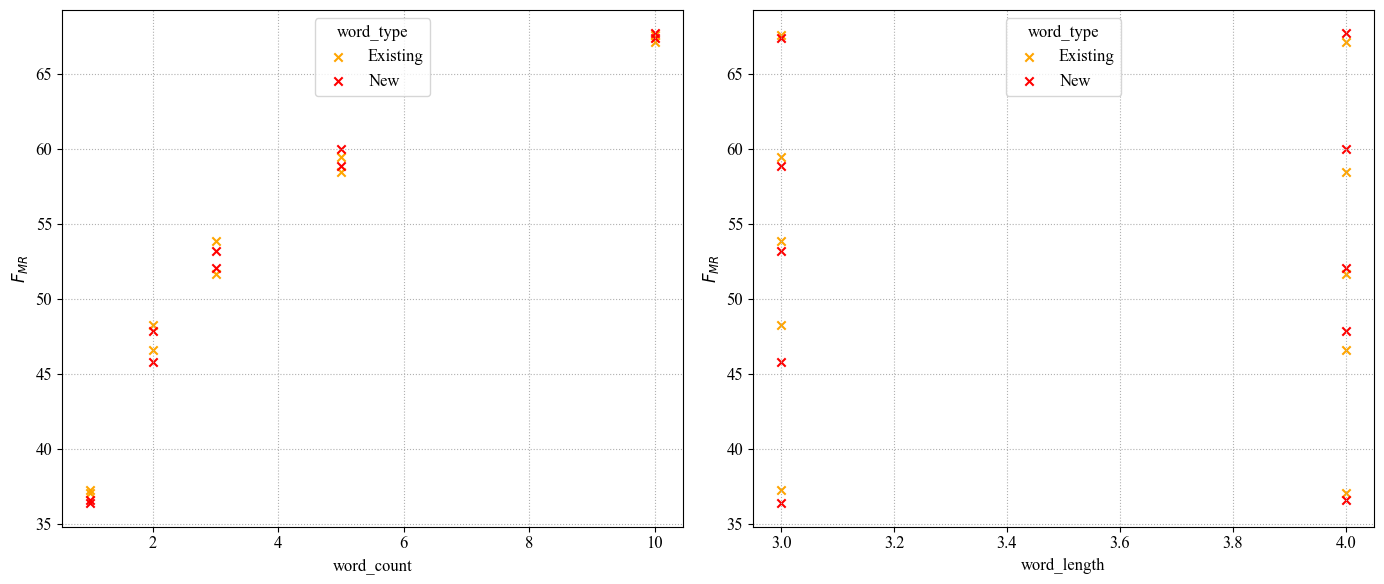

In [229]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'add_word_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


axs[0].scatter(df.loc[df['word_type'] == 'existing', 'word_count'], df.loc[df['word_type'] == 'existing', 'Fail %'], label='Existing', color='orange', marker='x')
axs[0].scatter(df.loc[df['word_type'] == 'new', 'word_count'], df.loc[df['word_type'] == 'new', 'Fail %'], label='New', color='red', marker='x')
axs[0].set_xlabel('word_count')
axs[0].set_ylabel('$F_{MR}$')
axs[0].legend(title='word_type', loc='upper center')
axs[0].grid(True, linestyle=':', linewidth=0.8)


axs[1].scatter(df.loc[df['word_type'] == 'existing', 'word_length'], df.loc[df['word_type'] == 'existing', 'Fail %'], label='Existing', color='orange', marker='x')
axs[1].scatter(df.loc[df['word_type'] == 'new', 'word_length'], df.loc[df['word_type'] == 'new', 'Fail %'], label='New', color='red', marker='x')
axs[1].set_xlabel('word_length')
axs[1].set_ylabel('$F_{MR}$')
axs[1].legend(title='word_type')
axs[1].legend(title='word_type', loc='upper center')
axs[1].grid(True, linestyle=':', linewidth=0.8)
plt.savefig(f"../Report/scatter_plot/{file_name}.png")
plt.tight_layout()
plt.show()


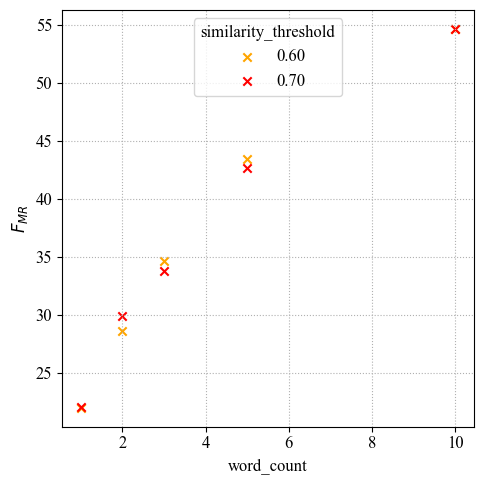

In [230]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'swap_word_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))


axs.scatter(df.loc[df['similarity_threshold'] == 0.60, 'word_count'], df.loc[df['similarity_threshold'] == 0.60, 'Fail %'], label='0.60', color='orange', marker='x')
axs.scatter(df.loc[df['similarity_threshold'] == 0.60, 'word_count'], df.loc[df['similarity_threshold'] == 0.70, 'Fail %'], label='0.70', color='red', marker='x')
axs.set_xlabel('word_count')
axs.set_ylabel('$F_{MR}$')
axs.legend(title='similarity_threshold', loc='upper center')
axs.grid(True, linestyle=':', linewidth=0.8)
plt.savefig(f"../Report/scatter_plot/{file_name}.png")
plt.tight_layout()
plt.show()


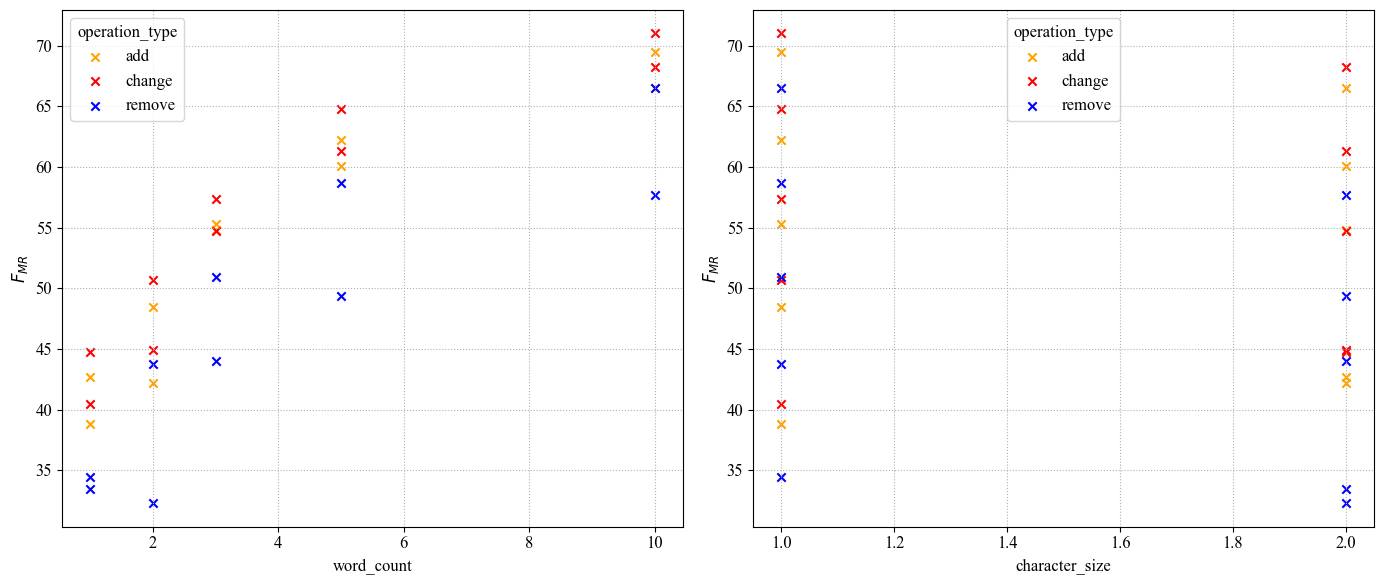

In [231]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'mistake_word_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


axs[0].scatter(df.loc[df['operation_type'] == 'add', 'word_count'], df.loc[df['operation_type'] == 'add', 'Fail %'], label='add', color='orange', marker='x')
axs[0].scatter(df.loc[df['operation_type'] == 'change', 'word_count'], df.loc[df['operation_type'] == 'change', 'Fail %'], label='change', color='red', marker='x')
axs[0].scatter(df.loc[df['operation_type'] == 'remove', 'word_count'], df.loc[df['operation_type'] == 'remove', 'Fail %'], label='remove', color='blue', marker='x')
axs[0].set_xlabel('word_count')
axs[0].set_ylabel('$F_{MR}$')
axs[0].legend(title='operation_type', loc='upper left')
axs[0].grid(True, linestyle=':', linewidth=0.8)

axs[1].scatter(df.loc[df['operation_type'] == 'add', 'character_size'], df.loc[df['operation_type'] == 'add', 'Fail %'], label='add', color='orange', marker='x')
axs[1].scatter(df.loc[df['operation_type'] == 'change', 'character_size'], df.loc[df['operation_type'] == 'change', 'Fail %'], label='change', color='red', marker='x')
axs[1].scatter(df.loc[df['operation_type'] == 'remove', 'character_size'], df.loc[df['operation_type'] == 'remove', 'Fail %'], label='remove', color='blue', marker='x')
axs[1].set_xlabel('character_size')
axs[1].set_ylabel('$F_{MR}$')
axs[1].legend(title='operation_type', loc='upper center')
axs[1].grid(True, linestyle=':', linewidth=0.8)

plt.savefig(f"../Report/scatter_plot/{file_name}.png")
plt.tight_layout()
plt.show()


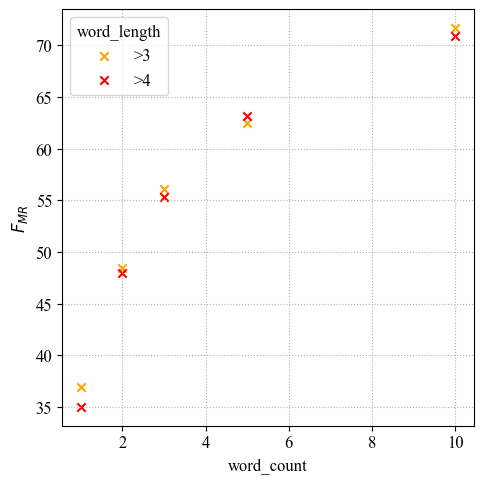

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'remove_word_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))


axs.scatter(df.loc[df['word_length'] == 3, 'word_count'], df.loc[df['word_length'] == 3, 'Fail %'], label='>3', color='orange', marker='x')
axs.scatter(df.loc[df['word_length'] == 4, 'word_count'], df.loc[df['word_length'] == 4, 'Fail %'], label='>4', color='red', marker='x')
axs.set_xlabel('word_count')
axs.set_ylabel('$F_{MR}$')
axs.legend(title='word_length', loc='upper left')
axs.grid(True, linestyle=':', linewidth=0.8)
plt.savefig(f"../Report/scatter_plot/{file_name}.png")
plt.tight_layout()
plt.show()

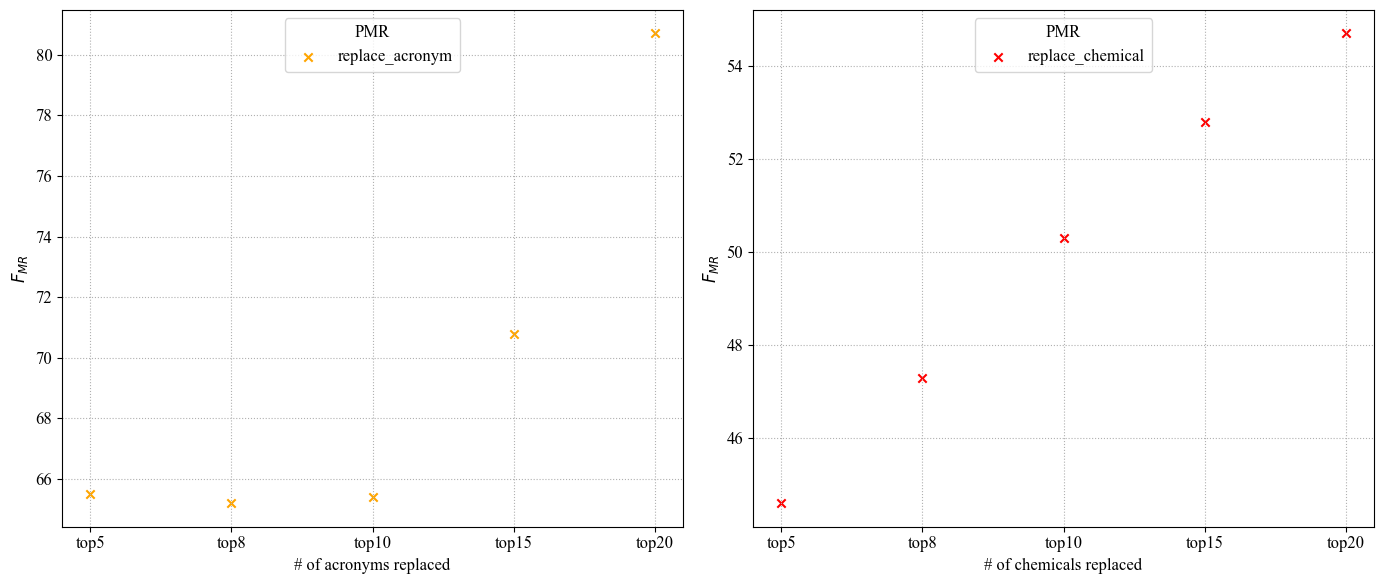

In [233]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'replace_acronym_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)

file_name1 = 'replace_chemical_pmr'
file_path1 = f'../Report/scatter_plot/{file_name1}.csv'
df1 = pd.read_csv(file_path1)
df1['Fail %'] = df1['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


axs[0].scatter(df['Top #'], df['Fail %'], label='replace_acronym', color='orange', marker='x')
axs[0].set_xlabel('# of acronyms replaced')
axs[0].set_ylabel('$F_{MR}$')
axs[0].legend(title='PMR', loc='upper center')
axs[0].grid(True, linestyle=':', linewidth=0.8)

# df.loc[df['operation_type'] == 'swap', 'list'], df.loc[df['operation_type'] == 'swap', 'Fail %']
axs[1].scatter(df1['Top #'], df1['Fail %'], label='replace_chemical', color='red', marker='x')
axs[1].set_xlabel('# of chemicals replaced')
axs[1].set_ylabel('$F_{MR}$')
axs[1].legend(title='PMR', loc='upper center')
axs[1].grid(True, linestyle=':', linewidth=0.8)
plt.savefig(f"../Report/scatter_plot/{file_name}_{file_name1}.png")
plt.tight_layout()
plt.show()

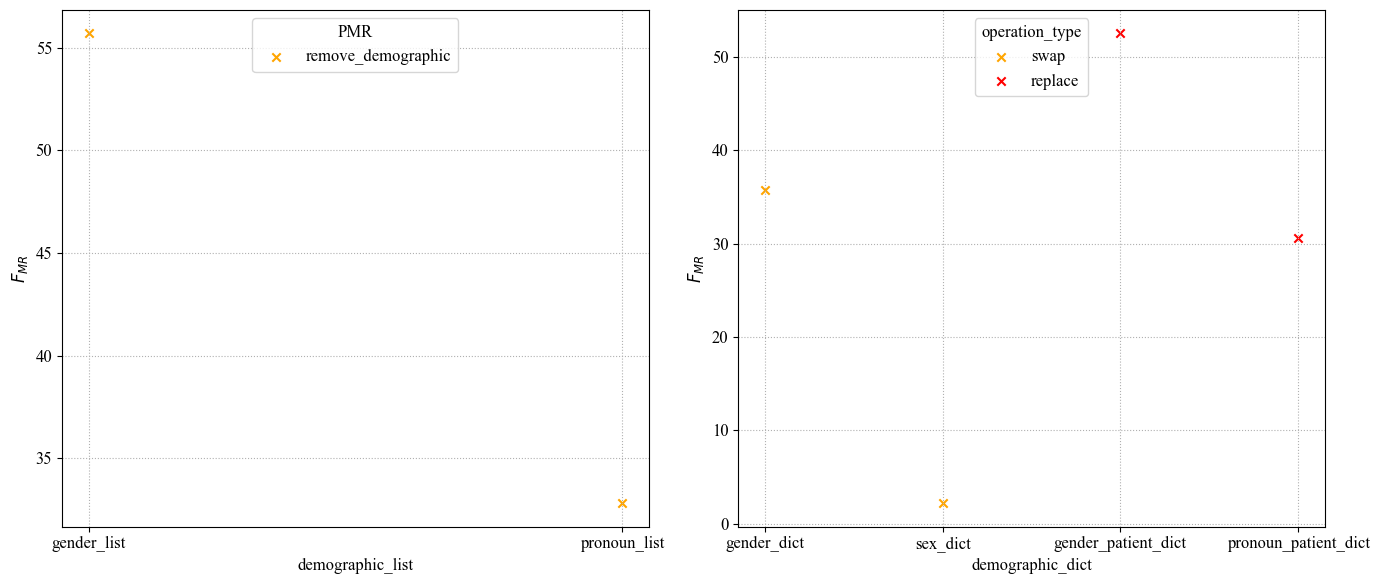

In [236]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mticker
file_name = 'remove_demographic_pmr'
file_path = f'../Report/scatter_plot/{file_name}.csv'

df = pd.read_csv(file_path)
df['Fail %'] = df['Fail %'].str.rstrip('%').astype(float).round(1)

file_name1 = 'demographic_change_pmr'
file_path1 = f'../Report/scatter_plot/{file_name1}.csv'
df1 = pd.read_csv(file_path1)
df1['Fail %'] = df1['Fail %'].str.rstrip('%').astype(float).round(1)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12
})
fig, axs = plt.subplots(1, 2, figsize=(14, 6))


axs[0].scatter(df['list'], df['Fail %'], label='remove_demographic', color='orange', marker='x')
axs[0].set_xlabel('demographic_list')
axs[0].set_ylabel('$F_{MR}$')
axs[0].legend(title='PMR', loc='upper center')
axs[0].grid(True, linestyle=':', linewidth=0.8)

# df.loc[df['operation_type'] == 'swap', 'list'], df.loc[df['operation_type'] == 'swap', 'Fail %']
axs[1].scatter(df1.loc[df1['operation_type'] == 'swap', 'list'], df1.loc[df1['operation_type'] == 'swap', 'Fail %'], label='swap', color='orange', marker='x')
axs[1].scatter(df1.loc[df1['operation_type'] == 'replace', 'list'], df1.loc[df1['operation_type'] == 'replace', 'Fail %'], label='replace', color='red', marker='x')
axs[1].set_xlabel('demographic_dict')
axs[1].set_ylabel('$F_{MR}$')
axs[1].legend(title='operation_type', loc='upper center')
axs[1].grid(True, linestyle=':', linewidth=0.8)
plt.savefig(f"../Report/scatter_plot/{file_name}_{file_name1}.png")
plt.tight_layout()
plt.show()

In [ ]:
# {`sex m:sex f', `sex f:sex m', `man:women', `women:man', `girl:boy', `boy:girl', `he:she', `him:her', `himself:herself', `his:hers', `she:he', `her:him', `herself:himself', `hers:his'}
# {`sex m:patient', `sex f:patient', `man:patient', `women:patient', `girl:patient', `boy:patient', `he:patient', `him:patient', `himself:patient', `his:patient', `she:patient', `her:patient', `herself:patient', `hers:patient'}